Use kernel conda_tensorflow_p36

In [1]:
import datetime as dt
import gc
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

plt.style.use('ggplot')

Using TensorFlow backend.


## Define helper functions

In [2]:
# Function to replace every NULL column with the mean from the training set (Naive Bayes)
def replace_nans_mean(df, split_date):
    split_idx = np.max(df.loc[df['date']<split_date].index.values)
    df_cp = df.copy()
    for col in df_cp.columns:
        if col == 'date':
            continue
        naive_estimate = df_cp.loc[:split_idx, col].mean()
        df_cp.loc[pd.isnull(df_cp[col]), col] = naive_estimate
        
    return df_cp

# Function to build 3-dimensional ndarray for LSTM based on input df and lookback window
def build_lstm_data(df, window):
    X = []
    y = []
    for i in range(len(df)-window):
        temp_set = df[i:(i+window)].copy()
        X.append(temp_set[:,1:])
        y.append(temp_set[window-1,0])

    return np.array(X), np.array(y)

## Tom Brady

In [4]:
# Read in data
brady = pd.read_csv('../data/data_final/final/features_raw/brady.csv')

# Select features for RNN, along with target. Specifically, remove averages.
features = [
    'target',
    'date',
    'player_played',
    'player_home',
    'betting_over_under_line',
    'betting_spread',
    'weather_temperature',
    'weather_wind_mph',
    'weather_humidity',
    'weather_inclement',
    'defense_fumbles_forced_moving_avg_1',
    'defense_fumbles_forced_moving_avg_3',
    'defense_fumbles_forced_moving_avg_5',
    'defense_interceptions_moving_avg_1',
    'defense_interceptions_moving_avg_3',
    'defense_interceptions_moving_avg_5',
    'defense_pass_yards_allowed_moving_avg_1',
    'defense_pass_yards_allowed_moving_avg_3',
    'defense_pass_yards_allowed_moving_avg_5',
    'defense_rush_yards_allowed_moving_avg_1',
    'defense_rush_yards_allowed_moving_avg_3',
    'defense_rush_yards_allowed_moving_avg_5',
    'defense_sacks_moving_avg_1',
    'defense_sacks_moving_avg_3',
    'defense_sacks_moving_avg_5',
    'defense_points_allowed_moving_avg_1',
    'defense_points_allowed_moving_avg_3',
    'defense_points_allowed_moving_avg_5',
    'twitter_pct_player_tweets',
    'twitter_pct_opponent_tweets',
    'twitter_count_player_swing_1_3',
    'twitter_count_opponent_swing_1_3',
    'twitter_player_net_sentiment',
    'twitter_opponent_net_sentiment',
    'twitter_player_pct_neutral',
    'twitter_opponent_pct_neutral',
    'twitter_net_sentiment_player_swing_1_3',
    'twitter_net_sentiment_opponent_swing_1_3',
    'twitter_pct_neutral_player_swing_1_3',
    'twitter_pct_neutral_opponent_swing_1_3'
]

brady = brady.loc[:, features]
brady['date'] = pd.to_datetime(brady['date'])

In [5]:
split_date = pd.Timestamp(2012,5,1)        
brady = replace_nans_mean(brady, split_date)

In [13]:
# Train + test set indices
train_idx = brady.loc[brady['date']<split_date].index.values
test_idx = brady.loc[brady['date']>split_date].index.values

# Scale Features
brady.drop('date', axis=1, inplace=True)
scaler = MinMaxScaler()
scaler.fit(brady)
brady = scaler.transform(brady)

# Train + test sets
train, test = brady[train_idx], brady[test_idx]

# Split to X and Y
# X_train, X_test, y_train, y_test = X, y = brady.iloc[:,1:], brady.iloc[:,0]

In [7]:
# Create train and test sets
window = 5
X, y = build_lstm_data(brady, window)
X_train, y_train = X[(train_idx-window)[window:]], y[(train_idx-window)[window:]]
X_test, y_test = X[(test_idx-window)], y[(test_idx-window)]

In [8]:
# Invert scaling of y for testing comparison
y_inv = np.concatenate((y_test.reshape(len(y_test),1), test[:,1:]), axis=1)
y_inv = scaler.inverse_transform(y_inv)
y_inv = y_inv[:,0]

In [8]:
%%time
# Build networks. Loop n times to deal with ranodmness.
n_loops = 10
rmses, maes = [], []
best_rmse, best_mae = 100, 100
best_model = None
best_preds = []

for i in range(0, n_loops):
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(Dropout(.3))
    model.add(LSTM(20))
    model.add(Dropout(.3))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    
    # Fit network
    lstm_model = model.fit(X_train, y_train, epochs=1000, batch_size=5, validation_data = (X_test, y_test), verbose=2, shuffle=False)
    
    # Make predictions for test set
    preds = model.predict(X_test)
    
    # Invert scaling for preds
    preds_inv = np.concatenate((preds, test[:,1:]), axis=1)
    preds_inv = scaler.inverse_transform(preds_inv)
    preds_inv = preds_inv[:,0]
    
    # Calculate RMSE and MAE
    rmses.append(np.sqrt(mean_squared_error(y_inv, preds_inv)))
    maes.append(mean_absolute_error(y_inv, preds_inv))
    
    if maes[i] < best_mae:
        best_rmse = rmses[i]
        best_mae = maes[i]
        best_model = lstm_model
        best_preds = preds_inv
        
    gc.collect()
    

W1106 23:25:35.640559 140147024881472 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1106 23:25:35.659396 140147024881472 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1106 23:25:35.662045 140147024881472 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1106 23:25:37.041940 140147024881472 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:13

Train on 26 samples, validate on 16 samples
Epoch 1/1000
 - 5s - loss: 0.3367 - val_loss: 0.2013
Epoch 2/1000
 - 0s - loss: 0.2365 - val_loss: 0.2187
Epoch 3/1000
 - 0s - loss: 0.2256 - val_loss: 0.2423
Epoch 4/1000
 - 0s - loss: 0.2935 - val_loss: 0.2265
Epoch 5/1000
 - 0s - loss: 0.2436 - val_loss: 0.2261
Epoch 6/1000
 - 0s - loss: 0.2917 - val_loss: 0.2199
Epoch 7/1000
 - 0s - loss: 0.2222 - val_loss: 0.2181
Epoch 8/1000
 - 0s - loss: 0.2558 - val_loss: 0.2212
Epoch 9/1000
 - 0s - loss: 0.2128 - val_loss: 0.2176
Epoch 10/1000
 - 0s - loss: 0.2227 - val_loss: 0.2160
Epoch 11/1000
 - 0s - loss: 0.2182 - val_loss: 0.2233
Epoch 12/1000
 - 0s - loss: 0.2116 - val_loss: 0.2321
Epoch 13/1000
 - 0s - loss: 0.2515 - val_loss: 0.2477
Epoch 14/1000
 - 0s - loss: 0.2124 - val_loss: 0.2553
Epoch 15/1000
 - 0s - loss: 0.2200 - val_loss: 0.2191
Epoch 16/1000
 - 0s - loss: 0.2075 - val_loss: 0.2123
Epoch 17/1000
 - 0s - loss: 0.1834 - val_loss: 0.2206
Epoch 18/1000
 - 0s - loss: 0.2299 - val_loss: 

 - 0s - loss: 0.1190 - val_loss: 0.1655
Epoch 152/1000
 - 0s - loss: 0.1053 - val_loss: 0.2365
Epoch 153/1000
 - 0s - loss: 0.1089 - val_loss: 0.1690
Epoch 154/1000
 - 0s - loss: 0.0909 - val_loss: 0.1585
Epoch 155/1000
 - 0s - loss: 0.1032 - val_loss: 0.1625
Epoch 156/1000
 - 0s - loss: 0.0995 - val_loss: 0.2332
Epoch 157/1000
 - 0s - loss: 0.1195 - val_loss: 0.1994
Epoch 158/1000
 - 0s - loss: 0.1047 - val_loss: 0.1480
Epoch 159/1000
 - 0s - loss: 0.1163 - val_loss: 0.2129
Epoch 160/1000
 - 0s - loss: 0.1146 - val_loss: 0.1941
Epoch 161/1000
 - 0s - loss: 0.0945 - val_loss: 0.1476
Epoch 162/1000
 - 0s - loss: 0.0994 - val_loss: 0.1534
Epoch 163/1000
 - 0s - loss: 0.0909 - val_loss: 0.1861
Epoch 164/1000
 - 0s - loss: 0.0894 - val_loss: 0.1669
Epoch 165/1000
 - 0s - loss: 0.0898 - val_loss: 0.1722
Epoch 166/1000
 - 0s - loss: 0.1070 - val_loss: 0.1942
Epoch 167/1000
 - 0s - loss: 0.0975 - val_loss: 0.1878
Epoch 168/1000
 - 0s - loss: 0.1000 - val_loss: 0.1917
Epoch 169/1000
 - 0s - lo

 - 0s - loss: 0.0598 - val_loss: 0.1880
Epoch 301/1000
 - 0s - loss: 0.0655 - val_loss: 0.1785
Epoch 302/1000
 - 0s - loss: 0.0539 - val_loss: 0.1606
Epoch 303/1000
 - 0s - loss: 0.0699 - val_loss: 0.1613
Epoch 304/1000
 - 0s - loss: 0.0586 - val_loss: 0.1684
Epoch 305/1000
 - 0s - loss: 0.0503 - val_loss: 0.1747
Epoch 306/1000
 - 0s - loss: 0.0517 - val_loss: 0.2336
Epoch 307/1000
 - 0s - loss: 0.0853 - val_loss: 0.1832
Epoch 308/1000
 - 0s - loss: 0.0629 - val_loss: 0.1665
Epoch 309/1000
 - 0s - loss: 0.0520 - val_loss: 0.1890
Epoch 310/1000
 - 0s - loss: 0.0541 - val_loss: 0.1795
Epoch 311/1000
 - 0s - loss: 0.0371 - val_loss: 0.2042
Epoch 312/1000
 - 0s - loss: 0.0574 - val_loss: 0.1747
Epoch 313/1000
 - 0s - loss: 0.0579 - val_loss: 0.1801
Epoch 314/1000
 - 0s - loss: 0.0427 - val_loss: 0.1908
Epoch 315/1000
 - 0s - loss: 0.0578 - val_loss: 0.1629
Epoch 316/1000
 - 0s - loss: 0.0654 - val_loss: 0.1672
Epoch 317/1000
 - 0s - loss: 0.0588 - val_loss: 0.1761
Epoch 318/1000
 - 0s - lo

 - 0s - loss: 0.0389 - val_loss: 0.1719
Epoch 450/1000
 - 0s - loss: 0.0554 - val_loss: 0.1740
Epoch 451/1000
 - 0s - loss: 0.0586 - val_loss: 0.1786
Epoch 452/1000
 - 0s - loss: 0.0406 - val_loss: 0.1580
Epoch 453/1000
 - 0s - loss: 0.0581 - val_loss: 0.1673
Epoch 454/1000
 - 0s - loss: 0.0522 - val_loss: 0.1649
Epoch 455/1000
 - 0s - loss: 0.0467 - val_loss: 0.1605
Epoch 456/1000
 - 0s - loss: 0.0556 - val_loss: 0.1565
Epoch 457/1000
 - 0s - loss: 0.0435 - val_loss: 0.1918
Epoch 458/1000
 - 0s - loss: 0.0794 - val_loss: 0.1767
Epoch 459/1000
 - 0s - loss: 0.0575 - val_loss: 0.1547
Epoch 460/1000
 - 0s - loss: 0.0712 - val_loss: 0.1707
Epoch 461/1000
 - 0s - loss: 0.0524 - val_loss: 0.1960
Epoch 462/1000
 - 0s - loss: 0.0619 - val_loss: 0.1650
Epoch 463/1000
 - 0s - loss: 0.0489 - val_loss: 0.1616
Epoch 464/1000
 - 0s - loss: 0.0472 - val_loss: 0.1677
Epoch 465/1000
 - 0s - loss: 0.0402 - val_loss: 0.1646
Epoch 466/1000
 - 0s - loss: 0.0452 - val_loss: 0.1621
Epoch 467/1000
 - 0s - lo

 - 0s - loss: 0.0503 - val_loss: 0.1657
Epoch 599/1000
 - 0s - loss: 0.0383 - val_loss: 0.1648
Epoch 600/1000
 - 0s - loss: 0.0452 - val_loss: 0.1608
Epoch 601/1000
 - 0s - loss: 0.0462 - val_loss: 0.1642
Epoch 602/1000
 - 0s - loss: 0.0468 - val_loss: 0.1589
Epoch 603/1000
 - 0s - loss: 0.0396 - val_loss: 0.1621
Epoch 604/1000
 - 0s - loss: 0.0410 - val_loss: 0.1741
Epoch 605/1000
 - 0s - loss: 0.0483 - val_loss: 0.1672
Epoch 606/1000
 - 0s - loss: 0.0338 - val_loss: 0.1715
Epoch 607/1000
 - 0s - loss: 0.0303 - val_loss: 0.1765
Epoch 608/1000
 - 0s - loss: 0.0528 - val_loss: 0.1640
Epoch 609/1000
 - 0s - loss: 0.0464 - val_loss: 0.1625
Epoch 610/1000
 - 0s - loss: 0.0452 - val_loss: 0.1672
Epoch 611/1000
 - 0s - loss: 0.0525 - val_loss: 0.1610
Epoch 612/1000
 - 0s - loss: 0.0510 - val_loss: 0.1605
Epoch 613/1000
 - 0s - loss: 0.0379 - val_loss: 0.1746
Epoch 614/1000
 - 0s - loss: 0.0444 - val_loss: 0.1676
Epoch 615/1000
 - 0s - loss: 0.0377 - val_loss: 0.1674
Epoch 616/1000
 - 0s - lo

 - 0s - loss: 0.0337 - val_loss: 0.1681
Epoch 748/1000
 - 0s - loss: 0.0283 - val_loss: 0.1639
Epoch 749/1000
 - 0s - loss: 0.0494 - val_loss: 0.1622
Epoch 750/1000
 - 0s - loss: 0.0434 - val_loss: 0.1658
Epoch 751/1000
 - 0s - loss: 0.0490 - val_loss: 0.1656
Epoch 752/1000
 - 0s - loss: 0.0461 - val_loss: 0.1603
Epoch 753/1000
 - 0s - loss: 0.0282 - val_loss: 0.1622
Epoch 754/1000
 - 0s - loss: 0.0424 - val_loss: 0.1670
Epoch 755/1000
 - 0s - loss: 0.0397 - val_loss: 0.1603
Epoch 756/1000
 - 0s - loss: 0.0457 - val_loss: 0.1599
Epoch 757/1000
 - 0s - loss: 0.0551 - val_loss: 0.1612
Epoch 758/1000
 - 0s - loss: 0.0329 - val_loss: 0.1685
Epoch 759/1000
 - 0s - loss: 0.0417 - val_loss: 0.1673
Epoch 760/1000
 - 0s - loss: 0.0262 - val_loss: 0.1737
Epoch 761/1000
 - 0s - loss: 0.0331 - val_loss: 0.1774
Epoch 762/1000
 - 0s - loss: 0.0452 - val_loss: 0.1619
Epoch 763/1000
 - 0s - loss: 0.0579 - val_loss: 0.1615
Epoch 764/1000
 - 0s - loss: 0.0371 - val_loss: 0.1706
Epoch 765/1000
 - 0s - lo

 - 0s - loss: 0.0385 - val_loss: 0.1649
Epoch 897/1000
 - 0s - loss: 0.0500 - val_loss: 0.1678
Epoch 898/1000
 - 0s - loss: 0.0294 - val_loss: 0.1644
Epoch 899/1000
 - 0s - loss: 0.0387 - val_loss: 0.1658
Epoch 900/1000
 - 0s - loss: 0.0386 - val_loss: 0.1656
Epoch 901/1000
 - 0s - loss: 0.0461 - val_loss: 0.1655
Epoch 902/1000
 - 0s - loss: 0.0445 - val_loss: 0.1674
Epoch 903/1000
 - 0s - loss: 0.0527 - val_loss: 0.1659
Epoch 904/1000
 - 0s - loss: 0.0406 - val_loss: 0.1660
Epoch 905/1000
 - 0s - loss: 0.0330 - val_loss: 0.1670
Epoch 906/1000
 - 0s - loss: 0.0410 - val_loss: 0.1667
Epoch 907/1000
 - 0s - loss: 0.0380 - val_loss: 0.1673
Epoch 908/1000
 - 0s - loss: 0.0360 - val_loss: 0.1659
Epoch 909/1000
 - 0s - loss: 0.0534 - val_loss: 0.1666
Epoch 910/1000
 - 0s - loss: 0.0410 - val_loss: 0.1674
Epoch 911/1000
 - 0s - loss: 0.0345 - val_loss: 0.1674
Epoch 912/1000
 - 0s - loss: 0.0373 - val_loss: 0.1674
Epoch 913/1000
 - 0s - loss: 0.0360 - val_loss: 0.1692
Epoch 914/1000
 - 0s - lo

Epoch 46/1000
 - 0s - loss: 0.1465 - val_loss: 0.2127
Epoch 47/1000
 - 0s - loss: 0.1933 - val_loss: 0.2835
Epoch 48/1000
 - 0s - loss: 0.1883 - val_loss: 0.2444
Epoch 49/1000
 - 0s - loss: 0.1644 - val_loss: 0.2023
Epoch 50/1000
 - 0s - loss: 0.1662 - val_loss: 0.2400
Epoch 51/1000
 - 0s - loss: 0.1843 - val_loss: 0.2767
Epoch 52/1000
 - 0s - loss: 0.1771 - val_loss: 0.2409
Epoch 53/1000
 - 0s - loss: 0.1732 - val_loss: 0.2011
Epoch 54/1000
 - 0s - loss: 0.1597 - val_loss: 0.2349
Epoch 55/1000
 - 0s - loss: 0.1620 - val_loss: 0.2518
Epoch 56/1000
 - 0s - loss: 0.1635 - val_loss: 0.2117
Epoch 57/1000
 - 0s - loss: 0.1649 - val_loss: 0.2475
Epoch 58/1000
 - 0s - loss: 0.1900 - val_loss: 0.2592
Epoch 59/1000
 - 0s - loss: 0.1440 - val_loss: 0.2397
Epoch 60/1000
 - 0s - loss: 0.1872 - val_loss: 0.2536
Epoch 61/1000
 - 0s - loss: 0.1595 - val_loss: 0.2780
Epoch 62/1000
 - 0s - loss: 0.1630 - val_loss: 0.2401
Epoch 63/1000
 - 0s - loss: 0.1342 - val_loss: 0.2234
Epoch 64/1000
 - 0s - loss: 

Epoch 196/1000
 - 0s - loss: 0.0895 - val_loss: 0.2031
Epoch 197/1000
 - 0s - loss: 0.0823 - val_loss: 0.1919
Epoch 198/1000
 - 0s - loss: 0.0792 - val_loss: 0.2315
Epoch 199/1000
 - 0s - loss: 0.0883 - val_loss: 0.2040
Epoch 200/1000
 - 0s - loss: 0.0988 - val_loss: 0.2242
Epoch 201/1000
 - 0s - loss: 0.0771 - val_loss: 0.1919
Epoch 202/1000
 - 0s - loss: 0.0867 - val_loss: 0.2301
Epoch 203/1000
 - 0s - loss: 0.0834 - val_loss: 0.2304
Epoch 204/1000
 - 0s - loss: 0.0833 - val_loss: 0.2575
Epoch 205/1000
 - 0s - loss: 0.0890 - val_loss: 0.2313
Epoch 206/1000
 - 0s - loss: 0.1003 - val_loss: 0.2324
Epoch 207/1000
 - 0s - loss: 0.0756 - val_loss: 0.2065
Epoch 208/1000
 - 0s - loss: 0.0912 - val_loss: 0.2256
Epoch 209/1000
 - 0s - loss: 0.1006 - val_loss: 0.2328
Epoch 210/1000
 - 0s - loss: 0.0805 - val_loss: 0.2277
Epoch 211/1000
 - 0s - loss: 0.0910 - val_loss: 0.2270
Epoch 212/1000
 - 0s - loss: 0.0868 - val_loss: 0.1994
Epoch 213/1000
 - 0s - loss: 0.0848 - val_loss: 0.1951
Epoch 214/

Epoch 345/1000
 - 0s - loss: 0.0658 - val_loss: 0.1905
Epoch 346/1000
 - 0s - loss: 0.0641 - val_loss: 0.2182
Epoch 347/1000
 - 0s - loss: 0.0679 - val_loss: 0.1941
Epoch 348/1000
 - 0s - loss: 0.0624 - val_loss: 0.2070
Epoch 349/1000
 - 0s - loss: 0.0642 - val_loss: 0.2317
Epoch 350/1000
 - 0s - loss: 0.0508 - val_loss: 0.2109
Epoch 351/1000
 - 0s - loss: 0.0630 - val_loss: 0.2034
Epoch 352/1000
 - 0s - loss: 0.0498 - val_loss: 0.1873
Epoch 353/1000
 - 0s - loss: 0.0603 - val_loss: 0.2382
Epoch 354/1000
 - 0s - loss: 0.0839 - val_loss: 0.2309
Epoch 355/1000
 - 0s - loss: 0.0719 - val_loss: 0.1895
Epoch 356/1000
 - 0s - loss: 0.0580 - val_loss: 0.2084
Epoch 357/1000
 - 0s - loss: 0.0389 - val_loss: 0.2032
Epoch 358/1000
 - 0s - loss: 0.0561 - val_loss: 0.2236
Epoch 359/1000
 - 0s - loss: 0.0338 - val_loss: 0.2078
Epoch 360/1000
 - 0s - loss: 0.0466 - val_loss: 0.2097
Epoch 361/1000
 - 0s - loss: 0.0455 - val_loss: 0.2316
Epoch 362/1000
 - 0s - loss: 0.0394 - val_loss: 0.2415
Epoch 363/

Epoch 494/1000
 - 0s - loss: 0.0458 - val_loss: 0.1910
Epoch 495/1000
 - 0s - loss: 0.0445 - val_loss: 0.2008
Epoch 496/1000
 - 0s - loss: 0.0509 - val_loss: 0.2061
Epoch 497/1000
 - 0s - loss: 0.0302 - val_loss: 0.2188
Epoch 498/1000
 - 0s - loss: 0.0526 - val_loss: 0.2223
Epoch 499/1000
 - 0s - loss: 0.0630 - val_loss: 0.2052
Epoch 500/1000
 - 0s - loss: 0.0485 - val_loss: 0.2274
Epoch 501/1000
 - 0s - loss: 0.0458 - val_loss: 0.2033
Epoch 502/1000
 - 0s - loss: 0.0441 - val_loss: 0.2126
Epoch 503/1000
 - 0s - loss: 0.0356 - val_loss: 0.2050
Epoch 504/1000
 - 0s - loss: 0.0397 - val_loss: 0.2054
Epoch 505/1000
 - 0s - loss: 0.0443 - val_loss: 0.2211
Epoch 506/1000
 - 0s - loss: 0.0472 - val_loss: 0.1982
Epoch 507/1000
 - 0s - loss: 0.0700 - val_loss: 0.1964
Epoch 508/1000
 - 0s - loss: 0.0569 - val_loss: 0.2173
Epoch 509/1000
 - 0s - loss: 0.0514 - val_loss: 0.2129
Epoch 510/1000
 - 0s - loss: 0.0439 - val_loss: 0.2233
Epoch 511/1000
 - 0s - loss: 0.0539 - val_loss: 0.2152
Epoch 512/

Epoch 643/1000
 - 0s - loss: 0.0567 - val_loss: 0.1983
Epoch 644/1000
 - 0s - loss: 0.0365 - val_loss: 0.2003
Epoch 645/1000
 - 0s - loss: 0.0354 - val_loss: 0.2136
Epoch 646/1000
 - 0s - loss: 0.0319 - val_loss: 0.2188
Epoch 647/1000
 - 0s - loss: 0.0495 - val_loss: 0.2089
Epoch 648/1000
 - 0s - loss: 0.0429 - val_loss: 0.2062
Epoch 649/1000
 - 0s - loss: 0.0397 - val_loss: 0.2197
Epoch 650/1000
 - 0s - loss: 0.0386 - val_loss: 0.2082
Epoch 651/1000
 - 0s - loss: 0.0477 - val_loss: 0.2098
Epoch 652/1000
 - 0s - loss: 0.0378 - val_loss: 0.2339
Epoch 653/1000
 - 0s - loss: 0.0481 - val_loss: 0.2189
Epoch 654/1000
 - 0s - loss: 0.0404 - val_loss: 0.2182
Epoch 655/1000
 - 0s - loss: 0.0370 - val_loss: 0.2117
Epoch 656/1000
 - 0s - loss: 0.0337 - val_loss: 0.2047
Epoch 657/1000
 - 0s - loss: 0.0435 - val_loss: 0.2037
Epoch 658/1000
 - 0s - loss: 0.0373 - val_loss: 0.1916
Epoch 659/1000
 - 0s - loss: 0.0386 - val_loss: 0.2103
Epoch 660/1000
 - 0s - loss: 0.0528 - val_loss: 0.2233
Epoch 661/

Epoch 792/1000
 - 0s - loss: 0.0269 - val_loss: 0.2073
Epoch 793/1000
 - 0s - loss: 0.0408 - val_loss: 0.2026
Epoch 794/1000
 - 0s - loss: 0.0509 - val_loss: 0.2005
Epoch 795/1000
 - 0s - loss: 0.0411 - val_loss: 0.1914
Epoch 796/1000
 - 0s - loss: 0.0371 - val_loss: 0.2020
Epoch 797/1000
 - 0s - loss: 0.0415 - val_loss: 0.2053
Epoch 798/1000
 - 0s - loss: 0.0450 - val_loss: 0.2149
Epoch 799/1000
 - 0s - loss: 0.0410 - val_loss: 0.2119
Epoch 800/1000
 - 0s - loss: 0.0321 - val_loss: 0.1978
Epoch 801/1000
 - 0s - loss: 0.0538 - val_loss: 0.1969
Epoch 802/1000
 - 0s - loss: 0.0399 - val_loss: 0.2068
Epoch 803/1000
 - 0s - loss: 0.0434 - val_loss: 0.1991
Epoch 804/1000
 - 0s - loss: 0.0366 - val_loss: 0.1903
Epoch 805/1000
 - 0s - loss: 0.0459 - val_loss: 0.1939
Epoch 806/1000
 - 0s - loss: 0.0399 - val_loss: 0.2033
Epoch 807/1000
 - 0s - loss: 0.0292 - val_loss: 0.2009
Epoch 808/1000
 - 0s - loss: 0.0326 - val_loss: 0.2086
Epoch 809/1000
 - 0s - loss: 0.0330 - val_loss: 0.2127
Epoch 810/

Epoch 941/1000
 - 0s - loss: 0.0443 - val_loss: 0.1935
Epoch 942/1000
 - 0s - loss: 0.0556 - val_loss: 0.1935
Epoch 943/1000
 - 0s - loss: 0.0507 - val_loss: 0.2006
Epoch 944/1000
 - 0s - loss: 0.0473 - val_loss: 0.2088
Epoch 945/1000
 - 0s - loss: 0.0300 - val_loss: 0.2057
Epoch 946/1000
 - 0s - loss: 0.0528 - val_loss: 0.1999
Epoch 947/1000
 - 0s - loss: 0.0454 - val_loss: 0.2076
Epoch 948/1000
 - 0s - loss: 0.0476 - val_loss: 0.2118
Epoch 949/1000
 - 0s - loss: 0.0285 - val_loss: 0.2093
Epoch 950/1000
 - 0s - loss: 0.0329 - val_loss: 0.2091
Epoch 951/1000
 - 0s - loss: 0.0349 - val_loss: 0.2087
Epoch 952/1000
 - 0s - loss: 0.0416 - val_loss: 0.1947
Epoch 953/1000
 - 0s - loss: 0.0458 - val_loss: 0.1913
Epoch 954/1000
 - 0s - loss: 0.0397 - val_loss: 0.1931
Epoch 955/1000
 - 0s - loss: 0.0332 - val_loss: 0.1938
Epoch 956/1000
 - 0s - loss: 0.0417 - val_loss: 0.1951
Epoch 957/1000
 - 0s - loss: 0.0359 - val_loss: 0.2048
Epoch 958/1000
 - 0s - loss: 0.0371 - val_loss: 0.2038
Epoch 959/

Epoch 91/1000
 - 0s - loss: 0.1280 - val_loss: 0.2136
Epoch 92/1000
 - 0s - loss: 0.1270 - val_loss: 0.1874
Epoch 93/1000
 - 0s - loss: 0.1331 - val_loss: 0.1976
Epoch 94/1000
 - 0s - loss: 0.1243 - val_loss: 0.2401
Epoch 95/1000
 - 0s - loss: 0.1204 - val_loss: 0.1719
Epoch 96/1000
 - 0s - loss: 0.1323 - val_loss: 0.2128
Epoch 97/1000
 - 0s - loss: 0.1130 - val_loss: 0.2216
Epoch 98/1000
 - 0s - loss: 0.1143 - val_loss: 0.1679
Epoch 99/1000
 - 0s - loss: 0.1300 - val_loss: 0.2124
Epoch 100/1000
 - 0s - loss: 0.1132 - val_loss: 0.2260
Epoch 101/1000
 - 0s - loss: 0.1077 - val_loss: 0.2208
Epoch 102/1000
 - 0s - loss: 0.1273 - val_loss: 0.2361
Epoch 103/1000
 - 0s - loss: 0.1286 - val_loss: 0.1986
Epoch 104/1000
 - 0s - loss: 0.1096 - val_loss: 0.2143
Epoch 105/1000
 - 0s - loss: 0.1193 - val_loss: 0.2505
Epoch 106/1000
 - 0s - loss: 0.0963 - val_loss: 0.2044
Epoch 107/1000
 - 0s - loss: 0.1046 - val_loss: 0.2457
Epoch 108/1000
 - 0s - loss: 0.0945 - val_loss: 0.2124
Epoch 109/1000
 - 0

 - 0s - loss: 0.0506 - val_loss: 0.1732
Epoch 241/1000
 - 0s - loss: 0.0828 - val_loss: 0.1675
Epoch 242/1000
 - 0s - loss: 0.0632 - val_loss: 0.1825
Epoch 243/1000
 - 0s - loss: 0.0776 - val_loss: 0.1816
Epoch 244/1000
 - 0s - loss: 0.0660 - val_loss: 0.1649
Epoch 245/1000
 - 0s - loss: 0.1047 - val_loss: 0.1648
Epoch 246/1000
 - 0s - loss: 0.0648 - val_loss: 0.1882
Epoch 247/1000
 - 0s - loss: 0.0793 - val_loss: 0.1719
Epoch 248/1000
 - 0s - loss: 0.0772 - val_loss: 0.1622
Epoch 249/1000
 - 0s - loss: 0.0531 - val_loss: 0.1922
Epoch 250/1000
 - 0s - loss: 0.0901 - val_loss: 0.1706
Epoch 251/1000
 - 0s - loss: 0.0780 - val_loss: 0.1596
Epoch 252/1000
 - 0s - loss: 0.0756 - val_loss: 0.1831
Epoch 253/1000
 - 0s - loss: 0.0700 - val_loss: 0.1684
Epoch 254/1000
 - 0s - loss: 0.0633 - val_loss: 0.1642
Epoch 255/1000
 - 0s - loss: 0.0691 - val_loss: 0.1734
Epoch 256/1000
 - 0s - loss: 0.0640 - val_loss: 0.1605
Epoch 257/1000
 - 0s - loss: 0.0719 - val_loss: 0.1648
Epoch 258/1000
 - 0s - lo

 - 0s - loss: 0.0447 - val_loss: 0.1918
Epoch 390/1000
 - 0s - loss: 0.0479 - val_loss: 0.1773
Epoch 391/1000
 - 0s - loss: 0.0570 - val_loss: 0.1755
Epoch 392/1000
 - 0s - loss: 0.0524 - val_loss: 0.1749
Epoch 393/1000
 - 0s - loss: 0.0650 - val_loss: 0.1658
Epoch 394/1000
 - 0s - loss: 0.0646 - val_loss: 0.1667
Epoch 395/1000
 - 0s - loss: 0.0586 - val_loss: 0.1718
Epoch 396/1000
 - 0s - loss: 0.0474 - val_loss: 0.1746
Epoch 397/1000
 - 0s - loss: 0.0584 - val_loss: 0.2047
Epoch 398/1000
 - 0s - loss: 0.0747 - val_loss: 0.1804
Epoch 399/1000
 - 0s - loss: 0.0509 - val_loss: 0.1788
Epoch 400/1000
 - 0s - loss: 0.0442 - val_loss: 0.1742
Epoch 401/1000
 - 0s - loss: 0.0316 - val_loss: 0.1741
Epoch 402/1000
 - 0s - loss: 0.0274 - val_loss: 0.1723
Epoch 403/1000
 - 0s - loss: 0.0494 - val_loss: 0.1776
Epoch 404/1000
 - 0s - loss: 0.0405 - val_loss: 0.1857
Epoch 405/1000
 - 0s - loss: 0.0456 - val_loss: 0.1795
Epoch 406/1000
 - 0s - loss: 0.0373 - val_loss: 0.1836
Epoch 407/1000
 - 0s - lo

 - 0s - loss: 0.0595 - val_loss: 0.2017
Epoch 539/1000
 - 0s - loss: 0.0479 - val_loss: 0.1915
Epoch 540/1000
 - 0s - loss: 0.0784 - val_loss: 0.1818
Epoch 541/1000
 - 0s - loss: 0.0401 - val_loss: 0.2012
Epoch 542/1000
 - 0s - loss: 0.0691 - val_loss: 0.1968
Epoch 543/1000
 - 0s - loss: 0.0388 - val_loss: 0.1773
Epoch 544/1000
 - 0s - loss: 0.0641 - val_loss: 0.1758
Epoch 545/1000
 - 0s - loss: 0.0549 - val_loss: 0.1860
Epoch 546/1000
 - 0s - loss: 0.0595 - val_loss: 0.1900
Epoch 547/1000
 - 0s - loss: 0.0434 - val_loss: 0.1781
Epoch 548/1000
 - 0s - loss: 0.0531 - val_loss: 0.1844
Epoch 549/1000
 - 0s - loss: 0.0409 - val_loss: 0.1960
Epoch 550/1000
 - 0s - loss: 0.0434 - val_loss: 0.1839
Epoch 551/1000
 - 0s - loss: 0.0567 - val_loss: 0.1788
Epoch 552/1000
 - 0s - loss: 0.0436 - val_loss: 0.1929
Epoch 553/1000
 - 0s - loss: 0.0691 - val_loss: 0.1956
Epoch 554/1000
 - 0s - loss: 0.0409 - val_loss: 0.1915
Epoch 555/1000
 - 0s - loss: 0.0482 - val_loss: 0.1869
Epoch 556/1000
 - 0s - lo

 - 0s - loss: 0.0397 - val_loss: 0.1817
Epoch 688/1000
 - 0s - loss: 0.0464 - val_loss: 0.1856
Epoch 689/1000
 - 0s - loss: 0.0555 - val_loss: 0.1912
Epoch 690/1000
 - 0s - loss: 0.0463 - val_loss: 0.1786
Epoch 691/1000
 - 0s - loss: 0.0495 - val_loss: 0.1824
Epoch 692/1000
 - 0s - loss: 0.0426 - val_loss: 0.1775
Epoch 693/1000
 - 0s - loss: 0.0308 - val_loss: 0.1761
Epoch 694/1000
 - 0s - loss: 0.0443 - val_loss: 0.1772
Epoch 695/1000
 - 0s - loss: 0.0253 - val_loss: 0.1821
Epoch 696/1000
 - 0s - loss: 0.0404 - val_loss: 0.1777
Epoch 697/1000
 - 0s - loss: 0.0517 - val_loss: 0.1814
Epoch 698/1000
 - 0s - loss: 0.0391 - val_loss: 0.1831
Epoch 699/1000
 - 0s - loss: 0.0410 - val_loss: 0.1798
Epoch 700/1000
 - 0s - loss: 0.0398 - val_loss: 0.1745
Epoch 701/1000
 - 0s - loss: 0.0416 - val_loss: 0.1748
Epoch 702/1000
 - 0s - loss: 0.0372 - val_loss: 0.1744
Epoch 703/1000
 - 0s - loss: 0.0449 - val_loss: 0.1768
Epoch 704/1000
 - 0s - loss: 0.0550 - val_loss: 0.1781
Epoch 705/1000
 - 0s - lo

 - 0s - loss: 0.0327 - val_loss: 0.1809
Epoch 837/1000
 - 0s - loss: 0.0398 - val_loss: 0.1792
Epoch 838/1000
 - 0s - loss: 0.0327 - val_loss: 0.1806
Epoch 839/1000
 - 0s - loss: 0.0423 - val_loss: 0.1852
Epoch 840/1000
 - 0s - loss: 0.0458 - val_loss: 0.1813
Epoch 841/1000
 - 0s - loss: 0.0459 - val_loss: 0.1792
Epoch 842/1000
 - 0s - loss: 0.0292 - val_loss: 0.1855
Epoch 843/1000
 - 0s - loss: 0.0499 - val_loss: 0.1841
Epoch 844/1000
 - 0s - loss: 0.0418 - val_loss: 0.1797
Epoch 845/1000
 - 0s - loss: 0.0370 - val_loss: 0.1810
Epoch 846/1000
 - 0s - loss: 0.0384 - val_loss: 0.1793
Epoch 847/1000
 - 0s - loss: 0.0300 - val_loss: 0.1770
Epoch 848/1000
 - 0s - loss: 0.0350 - val_loss: 0.1777
Epoch 849/1000
 - 0s - loss: 0.0329 - val_loss: 0.1803
Epoch 850/1000
 - 0s - loss: 0.0529 - val_loss: 0.1837
Epoch 851/1000
 - 0s - loss: 0.0295 - val_loss: 0.1778
Epoch 852/1000
 - 0s - loss: 0.0407 - val_loss: 0.1865
Epoch 853/1000
 - 0s - loss: 0.0568 - val_loss: 0.1844
Epoch 854/1000
 - 0s - lo

 - 0s - loss: 0.0288 - val_loss: 0.1919
Epoch 986/1000
 - 0s - loss: 0.0297 - val_loss: 0.1925
Epoch 987/1000
 - 0s - loss: 0.0492 - val_loss: 0.1859
Epoch 988/1000
 - 0s - loss: 0.0344 - val_loss: 0.1768
Epoch 989/1000
 - 0s - loss: 0.0381 - val_loss: 0.1780
Epoch 990/1000
 - 0s - loss: 0.0444 - val_loss: 0.1859
Epoch 991/1000
 - 0s - loss: 0.0523 - val_loss: 0.1834
Epoch 992/1000
 - 0s - loss: 0.0349 - val_loss: 0.1793
Epoch 993/1000
 - 0s - loss: 0.0418 - val_loss: 0.1778
Epoch 994/1000
 - 0s - loss: 0.0269 - val_loss: 0.1790
Epoch 995/1000
 - 0s - loss: 0.0258 - val_loss: 0.1780
Epoch 996/1000
 - 0s - loss: 0.0328 - val_loss: 0.1779
Epoch 997/1000
 - 0s - loss: 0.0273 - val_loss: 0.1840
Epoch 998/1000
 - 0s - loss: 0.0379 - val_loss: 0.1820
Epoch 999/1000
 - 0s - loss: 0.0339 - val_loss: 0.1775
Epoch 1000/1000
 - 0s - loss: 0.0391 - val_loss: 0.1755
Train on 26 samples, validate on 16 samples
Epoch 1/1000
 - 6s - loss: 0.3536 - val_loss: 0.2118
Epoch 2/1000
 - 0s - loss: 0.2438 - v

Epoch 136/1000
 - 0s - loss: 0.1141 - val_loss: 0.1789
Epoch 137/1000
 - 0s - loss: 0.1175 - val_loss: 0.1989
Epoch 138/1000
 - 0s - loss: 0.1311 - val_loss: 0.2505
Epoch 139/1000
 - 0s - loss: 0.1305 - val_loss: 0.2015
Epoch 140/1000
 - 0s - loss: 0.1271 - val_loss: 0.1767
Epoch 141/1000
 - 0s - loss: 0.1154 - val_loss: 0.2113
Epoch 142/1000
 - 0s - loss: 0.1068 - val_loss: 0.1946
Epoch 143/1000
 - 0s - loss: 0.1136 - val_loss: 0.1920
Epoch 144/1000
 - 0s - loss: 0.1141 - val_loss: 0.1949
Epoch 145/1000
 - 0s - loss: 0.1008 - val_loss: 0.1853
Epoch 146/1000
 - 0s - loss: 0.1011 - val_loss: 0.1893
Epoch 147/1000
 - 0s - loss: 0.1183 - val_loss: 0.1747
Epoch 148/1000
 - 0s - loss: 0.1006 - val_loss: 0.2097
Epoch 149/1000
 - 0s - loss: 0.1241 - val_loss: 0.2082
Epoch 150/1000
 - 0s - loss: 0.1010 - val_loss: 0.2141
Epoch 151/1000
 - 0s - loss: 0.1074 - val_loss: 0.1987
Epoch 152/1000
 - 0s - loss: 0.1108 - val_loss: 0.1786
Epoch 153/1000
 - 0s - loss: 0.1215 - val_loss: 0.1772
Epoch 154/

Epoch 285/1000
 - 0s - loss: 0.0633 - val_loss: 0.1818
Epoch 286/1000
 - 0s - loss: 0.0753 - val_loss: 0.1800
Epoch 287/1000
 - 0s - loss: 0.0693 - val_loss: 0.1965
Epoch 288/1000
 - 0s - loss: 0.0863 - val_loss: 0.1895
Epoch 289/1000
 - 0s - loss: 0.0457 - val_loss: 0.1808
Epoch 290/1000
 - 0s - loss: 0.0666 - val_loss: 0.1768
Epoch 291/1000
 - 0s - loss: 0.0530 - val_loss: 0.1812
Epoch 292/1000
 - 0s - loss: 0.0580 - val_loss: 0.1776
Epoch 293/1000
 - 0s - loss: 0.0593 - val_loss: 0.1807
Epoch 294/1000
 - 0s - loss: 0.0679 - val_loss: 0.1794
Epoch 295/1000
 - 0s - loss: 0.0474 - val_loss: 0.1777
Epoch 296/1000
 - 0s - loss: 0.0668 - val_loss: 0.1740
Epoch 297/1000
 - 0s - loss: 0.0558 - val_loss: 0.1835
Epoch 298/1000
 - 0s - loss: 0.0717 - val_loss: 0.1800
Epoch 299/1000
 - 0s - loss: 0.0756 - val_loss: 0.1819
Epoch 300/1000
 - 0s - loss: 0.0727 - val_loss: 0.1812
Epoch 301/1000
 - 0s - loss: 0.0748 - val_loss: 0.1939
Epoch 302/1000
 - 0s - loss: 0.0643 - val_loss: 0.1783
Epoch 303/

Epoch 434/1000
 - 0s - loss: 0.0445 - val_loss: 0.1792
Epoch 435/1000
 - 0s - loss: 0.0335 - val_loss: 0.1797
Epoch 436/1000
 - 0s - loss: 0.0457 - val_loss: 0.1772
Epoch 437/1000
 - 0s - loss: 0.0391 - val_loss: 0.1756
Epoch 438/1000
 - 0s - loss: 0.0561 - val_loss: 0.1786
Epoch 439/1000
 - 0s - loss: 0.0386 - val_loss: 0.1821
Epoch 440/1000
 - 0s - loss: 0.0402 - val_loss: 0.1779
Epoch 441/1000
 - 0s - loss: 0.0439 - val_loss: 0.1811
Epoch 442/1000
 - 0s - loss: 0.0345 - val_loss: 0.1821
Epoch 443/1000
 - 0s - loss: 0.0356 - val_loss: 0.1748
Epoch 444/1000
 - 0s - loss: 0.0541 - val_loss: 0.1724
Epoch 445/1000
 - 0s - loss: 0.0376 - val_loss: 0.1816
Epoch 446/1000
 - 0s - loss: 0.0337 - val_loss: 0.1758
Epoch 447/1000
 - 0s - loss: 0.0732 - val_loss: 0.1702
Epoch 448/1000
 - 0s - loss: 0.0620 - val_loss: 0.1736
Epoch 449/1000
 - 0s - loss: 0.0428 - val_loss: 0.1859
Epoch 450/1000
 - 0s - loss: 0.0542 - val_loss: 0.1810
Epoch 451/1000
 - 0s - loss: 0.0367 - val_loss: 0.1769
Epoch 452/

Epoch 583/1000
 - 0s - loss: 0.0448 - val_loss: 0.1777
Epoch 584/1000
 - 0s - loss: 0.0471 - val_loss: 0.1755
Epoch 585/1000
 - 0s - loss: 0.0539 - val_loss: 0.1778
Epoch 586/1000
 - 0s - loss: 0.0473 - val_loss: 0.1790
Epoch 587/1000
 - 0s - loss: 0.0590 - val_loss: 0.1766
Epoch 588/1000
 - 0s - loss: 0.0426 - val_loss: 0.1786
Epoch 589/1000
 - 0s - loss: 0.0457 - val_loss: 0.1810
Epoch 590/1000
 - 0s - loss: 0.0482 - val_loss: 0.1788
Epoch 591/1000
 - 0s - loss: 0.0438 - val_loss: 0.1727
Epoch 592/1000
 - 0s - loss: 0.0523 - val_loss: 0.1794
Epoch 593/1000
 - 0s - loss: 0.0525 - val_loss: 0.1813
Epoch 594/1000
 - 0s - loss: 0.0458 - val_loss: 0.1765
Epoch 595/1000
 - 0s - loss: 0.0383 - val_loss: 0.1787
Epoch 596/1000
 - 0s - loss: 0.0460 - val_loss: 0.1782
Epoch 597/1000
 - 0s - loss: 0.0492 - val_loss: 0.1796
Epoch 598/1000
 - 0s - loss: 0.0437 - val_loss: 0.1811
Epoch 599/1000
 - 0s - loss: 0.0343 - val_loss: 0.1811
Epoch 600/1000
 - 0s - loss: 0.0339 - val_loss: 0.1806
Epoch 601/

Epoch 732/1000
 - 0s - loss: 0.0482 - val_loss: 0.1746
Epoch 733/1000
 - 0s - loss: 0.0519 - val_loss: 0.1816
Epoch 734/1000
 - 0s - loss: 0.0518 - val_loss: 0.1894
Epoch 735/1000
 - 0s - loss: 0.0532 - val_loss: 0.1781
Epoch 736/1000
 - 0s - loss: 0.0398 - val_loss: 0.1754
Epoch 737/1000
 - 0s - loss: 0.0462 - val_loss: 0.1796
Epoch 738/1000
 - 0s - loss: 0.0484 - val_loss: 0.1836
Epoch 739/1000
 - 0s - loss: 0.0333 - val_loss: 0.1801
Epoch 740/1000
 - 0s - loss: 0.0272 - val_loss: 0.1799
Epoch 741/1000
 - 0s - loss: 0.0409 - val_loss: 0.1842
Epoch 742/1000
 - 0s - loss: 0.0464 - val_loss: 0.1828
Epoch 743/1000
 - 0s - loss: 0.0559 - val_loss: 0.1775
Epoch 744/1000
 - 0s - loss: 0.0345 - val_loss: 0.1815
Epoch 745/1000
 - 0s - loss: 0.0335 - val_loss: 0.1859
Epoch 746/1000
 - 0s - loss: 0.0443 - val_loss: 0.1818
Epoch 747/1000
 - 0s - loss: 0.0357 - val_loss: 0.1780
Epoch 748/1000
 - 0s - loss: 0.0368 - val_loss: 0.1774
Epoch 749/1000
 - 0s - loss: 0.0433 - val_loss: 0.1801
Epoch 750/

Epoch 881/1000
 - 0s - loss: 0.0384 - val_loss: 0.1758
Epoch 882/1000
 - 0s - loss: 0.0417 - val_loss: 0.1750
Epoch 883/1000
 - 0s - loss: 0.0322 - val_loss: 0.1733
Epoch 884/1000
 - 0s - loss: 0.0352 - val_loss: 0.1761
Epoch 885/1000
 - 0s - loss: 0.0302 - val_loss: 0.1811
Epoch 886/1000
 - 0s - loss: 0.0517 - val_loss: 0.1799
Epoch 887/1000
 - 0s - loss: 0.0413 - val_loss: 0.1800
Epoch 888/1000
 - 0s - loss: 0.0361 - val_loss: 0.1796
Epoch 889/1000
 - 0s - loss: 0.0414 - val_loss: 0.1747
Epoch 890/1000
 - 0s - loss: 0.0515 - val_loss: 0.1744
Epoch 891/1000
 - 0s - loss: 0.0372 - val_loss: 0.1769
Epoch 892/1000
 - 0s - loss: 0.0326 - val_loss: 0.1744
Epoch 893/1000
 - 0s - loss: 0.0418 - val_loss: 0.1759
Epoch 894/1000
 - 0s - loss: 0.0378 - val_loss: 0.1766
Epoch 895/1000
 - 0s - loss: 0.0273 - val_loss: 0.1737
Epoch 896/1000
 - 0s - loss: 0.0418 - val_loss: 0.1748
Epoch 897/1000
 - 0s - loss: 0.0330 - val_loss: 0.1751
Epoch 898/1000
 - 0s - loss: 0.0368 - val_loss: 0.1739
Epoch 899/

Epoch 30/1000
 - 0s - loss: 0.1814 - val_loss: 0.2058
Epoch 31/1000
 - 0s - loss: 0.1547 - val_loss: 0.2739
Epoch 32/1000
 - 0s - loss: 0.1969 - val_loss: 0.2618
Epoch 33/1000
 - 0s - loss: 0.1667 - val_loss: 0.1994
Epoch 34/1000
 - 0s - loss: 0.1805 - val_loss: 0.2255
Epoch 35/1000
 - 0s - loss: 0.1875 - val_loss: 0.2395
Epoch 36/1000
 - 0s - loss: 0.1862 - val_loss: 0.2057
Epoch 37/1000
 - 0s - loss: 0.1546 - val_loss: 0.2346
Epoch 38/1000
 - 0s - loss: 0.1875 - val_loss: 0.2179
Epoch 39/1000
 - 0s - loss: 0.1521 - val_loss: 0.2537
Epoch 40/1000
 - 0s - loss: 0.1835 - val_loss: 0.2119
Epoch 41/1000
 - 0s - loss: 0.2078 - val_loss: 0.1959
Epoch 42/1000
 - 0s - loss: 0.1616 - val_loss: 0.3132
Epoch 43/1000
 - 0s - loss: 0.1624 - val_loss: 0.1889
Epoch 44/1000
 - 0s - loss: 0.1768 - val_loss: 0.2010
Epoch 45/1000
 - 0s - loss: 0.1612 - val_loss: 0.2571
Epoch 46/1000
 - 0s - loss: 0.1684 - val_loss: 0.2147
Epoch 47/1000
 - 0s - loss: 0.1252 - val_loss: 0.2124
Epoch 48/1000
 - 0s - loss: 

 - 0s - loss: 0.1125 - val_loss: 0.2406
Epoch 181/1000
 - 0s - loss: 0.1374 - val_loss: 0.2009
Epoch 182/1000
 - 0s - loss: 0.0923 - val_loss: 0.1671
Epoch 183/1000
 - 0s - loss: 0.0909 - val_loss: 0.2031
Epoch 184/1000
 - 0s - loss: 0.1062 - val_loss: 0.1784
Epoch 185/1000
 - 0s - loss: 0.0915 - val_loss: 0.1715
Epoch 186/1000
 - 0s - loss: 0.0793 - val_loss: 0.1833
Epoch 187/1000
 - 0s - loss: 0.0951 - val_loss: 0.2008
Epoch 188/1000
 - 0s - loss: 0.0817 - val_loss: 0.1744
Epoch 189/1000
 - 0s - loss: 0.0869 - val_loss: 0.1792
Epoch 190/1000
 - 0s - loss: 0.0758 - val_loss: 0.1694
Epoch 191/1000
 - 0s - loss: 0.0749 - val_loss: 0.1864
Epoch 192/1000
 - 0s - loss: 0.0778 - val_loss: 0.1684
Epoch 193/1000
 - 0s - loss: 0.0893 - val_loss: 0.1742
Epoch 194/1000
 - 0s - loss: 0.0959 - val_loss: 0.2000
Epoch 195/1000
 - 0s - loss: 0.0838 - val_loss: 0.1990
Epoch 196/1000
 - 0s - loss: 0.0941 - val_loss: 0.1682
Epoch 197/1000
 - 0s - loss: 0.1143 - val_loss: 0.1674
Epoch 198/1000
 - 0s - lo

 - 0s - loss: 0.0619 - val_loss: 0.1792
Epoch 330/1000
 - 0s - loss: 0.0700 - val_loss: 0.2301
Epoch 331/1000
 - 0s - loss: 0.0758 - val_loss: 0.2029
Epoch 332/1000
 - 0s - loss: 0.0616 - val_loss: 0.2254
Epoch 333/1000
 - 0s - loss: 0.0792 - val_loss: 0.2396
Epoch 334/1000
 - 0s - loss: 0.0571 - val_loss: 0.1759
Epoch 335/1000
 - 0s - loss: 0.0857 - val_loss: 0.1739
Epoch 336/1000
 - 0s - loss: 0.0619 - val_loss: 0.2077
Epoch 337/1000
 - 0s - loss: 0.0708 - val_loss: 0.1729
Epoch 338/1000
 - 0s - loss: 0.0621 - val_loss: 0.1737
Epoch 339/1000
 - 0s - loss: 0.0565 - val_loss: 0.1920
Epoch 340/1000
 - 0s - loss: 0.0536 - val_loss: 0.1802
Epoch 341/1000
 - 0s - loss: 0.0492 - val_loss: 0.2092
Epoch 342/1000
 - 0s - loss: 0.0656 - val_loss: 0.1933
Epoch 343/1000
 - 0s - loss: 0.0589 - val_loss: 0.1820
Epoch 344/1000
 - 0s - loss: 0.0462 - val_loss: 0.1993
Epoch 345/1000
 - 0s - loss: 0.0486 - val_loss: 0.1841
Epoch 346/1000
 - 0s - loss: 0.0659 - val_loss: 0.1821
Epoch 347/1000
 - 0s - lo

 - 0s - loss: 0.0494 - val_loss: 0.2007
Epoch 479/1000
 - 0s - loss: 0.0519 - val_loss: 0.1888
Epoch 480/1000
 - 0s - loss: 0.0550 - val_loss: 0.1944
Epoch 481/1000
 - 0s - loss: 0.0605 - val_loss: 0.2069
Epoch 482/1000
 - 0s - loss: 0.0446 - val_loss: 0.1921
Epoch 483/1000
 - 0s - loss: 0.0376 - val_loss: 0.1832
Epoch 484/1000
 - 0s - loss: 0.0384 - val_loss: 0.1839
Epoch 485/1000
 - 0s - loss: 0.0537 - val_loss: 0.1901
Epoch 486/1000
 - 0s - loss: 0.0484 - val_loss: 0.1980
Epoch 487/1000
 - 0s - loss: 0.0383 - val_loss: 0.1960
Epoch 488/1000
 - 0s - loss: 0.0626 - val_loss: 0.2049
Epoch 489/1000
 - 0s - loss: 0.0554 - val_loss: 0.1973
Epoch 490/1000
 - 0s - loss: 0.0636 - val_loss: 0.1833
Epoch 491/1000
 - 0s - loss: 0.0517 - val_loss: 0.1905
Epoch 492/1000
 - 0s - loss: 0.0774 - val_loss: 0.2013
Epoch 493/1000
 - 0s - loss: 0.0684 - val_loss: 0.1787
Epoch 494/1000
 - 0s - loss: 0.0445 - val_loss: 0.1821
Epoch 495/1000
 - 0s - loss: 0.0392 - val_loss: 0.1911
Epoch 496/1000
 - 0s - lo

 - 0s - loss: 0.0398 - val_loss: 0.1768
Epoch 628/1000
 - 0s - loss: 0.0372 - val_loss: 0.1819
Epoch 629/1000
 - 0s - loss: 0.0378 - val_loss: 0.1796
Epoch 630/1000
 - 0s - loss: 0.0503 - val_loss: 0.1884
Epoch 631/1000
 - 0s - loss: 0.0373 - val_loss: 0.1849
Epoch 632/1000
 - 0s - loss: 0.0408 - val_loss: 0.1863
Epoch 633/1000
 - 0s - loss: 0.0314 - val_loss: 0.1766
Epoch 634/1000
 - 0s - loss: 0.0430 - val_loss: 0.1809
Epoch 635/1000
 - 0s - loss: 0.0423 - val_loss: 0.1790
Epoch 636/1000
 - 0s - loss: 0.0331 - val_loss: 0.1808
Epoch 637/1000
 - 0s - loss: 0.0512 - val_loss: 0.1881
Epoch 638/1000
 - 0s - loss: 0.0391 - val_loss: 0.1832
Epoch 639/1000
 - 0s - loss: 0.0384 - val_loss: 0.1869
Epoch 640/1000
 - 0s - loss: 0.0464 - val_loss: 0.1946
Epoch 641/1000
 - 0s - loss: 0.0411 - val_loss: 0.1954
Epoch 642/1000
 - 0s - loss: 0.0462 - val_loss: 0.1919
Epoch 643/1000
 - 0s - loss: 0.0495 - val_loss: 0.1876
Epoch 644/1000
 - 0s - loss: 0.0312 - val_loss: 0.1851
Epoch 645/1000
 - 0s - lo

 - 0s - loss: 0.0477 - val_loss: 0.1804
Epoch 777/1000
 - 0s - loss: 0.0343 - val_loss: 0.1875
Epoch 778/1000
 - 0s - loss: 0.0532 - val_loss: 0.1972
Epoch 779/1000
 - 0s - loss: 0.0515 - val_loss: 0.1765
Epoch 780/1000
 - 0s - loss: 0.0545 - val_loss: 0.1746
Epoch 781/1000
 - 0s - loss: 0.0574 - val_loss: 0.1771
Epoch 782/1000
 - 0s - loss: 0.0603 - val_loss: 0.1829
Epoch 783/1000
 - 0s - loss: 0.0468 - val_loss: 0.1755
Epoch 784/1000
 - 0s - loss: 0.0500 - val_loss: 0.1767
Epoch 785/1000
 - 0s - loss: 0.0465 - val_loss: 0.1769
Epoch 786/1000
 - 0s - loss: 0.0433 - val_loss: 0.1774
Epoch 787/1000
 - 0s - loss: 0.0382 - val_loss: 0.1775
Epoch 788/1000
 - 0s - loss: 0.0289 - val_loss: 0.1799
Epoch 789/1000
 - 0s - loss: 0.0355 - val_loss: 0.1827
Epoch 790/1000
 - 0s - loss: 0.0353 - val_loss: 0.1775
Epoch 791/1000
 - 0s - loss: 0.0485 - val_loss: 0.1764
Epoch 792/1000
 - 0s - loss: 0.0358 - val_loss: 0.1800
Epoch 793/1000
 - 0s - loss: 0.0478 - val_loss: 0.1858
Epoch 794/1000
 - 0s - lo

 - 0s - loss: 0.0401 - val_loss: 0.1769
Epoch 926/1000
 - 0s - loss: 0.0400 - val_loss: 0.1791
Epoch 927/1000
 - 0s - loss: 0.0340 - val_loss: 0.1811
Epoch 928/1000
 - 0s - loss: 0.0350 - val_loss: 0.1803
Epoch 929/1000
 - 0s - loss: 0.0396 - val_loss: 0.1798
Epoch 930/1000
 - 0s - loss: 0.0562 - val_loss: 0.1789
Epoch 931/1000
 - 0s - loss: 0.0299 - val_loss: 0.1812
Epoch 932/1000
 - 0s - loss: 0.0581 - val_loss: 0.1831
Epoch 933/1000
 - 0s - loss: 0.0469 - val_loss: 0.1813
Epoch 934/1000
 - 0s - loss: 0.0307 - val_loss: 0.1800
Epoch 935/1000
 - 0s - loss: 0.0501 - val_loss: 0.1807
Epoch 936/1000
 - 0s - loss: 0.0417 - val_loss: 0.1817
Epoch 937/1000
 - 0s - loss: 0.0446 - val_loss: 0.1812
Epoch 938/1000
 - 0s - loss: 0.0437 - val_loss: 0.1830
Epoch 939/1000
 - 0s - loss: 0.0466 - val_loss: 0.1823
Epoch 940/1000
 - 0s - loss: 0.0427 - val_loss: 0.1795
Epoch 941/1000
 - 0s - loss: 0.0412 - val_loss: 0.1767
Epoch 942/1000
 - 0s - loss: 0.0396 - val_loss: 0.1787
Epoch 943/1000
 - 0s - lo

Epoch 75/1000
 - 0s - loss: 0.1200 - val_loss: 0.2502
Epoch 76/1000
 - 0s - loss: 0.1316 - val_loss: 0.2201
Epoch 77/1000
 - 0s - loss: 0.1187 - val_loss: 0.2012
Epoch 78/1000
 - 0s - loss: 0.1570 - val_loss: 0.2241
Epoch 79/1000
 - 0s - loss: 0.1255 - val_loss: 0.2313
Epoch 80/1000
 - 0s - loss: 0.1114 - val_loss: 0.1807
Epoch 81/1000
 - 0s - loss: 0.1388 - val_loss: 0.2238
Epoch 82/1000
 - 0s - loss: 0.1260 - val_loss: 0.2054
Epoch 83/1000
 - 0s - loss: 0.1063 - val_loss: 0.2643
Epoch 84/1000
 - 0s - loss: 0.1241 - val_loss: 0.2614
Epoch 85/1000
 - 0s - loss: 0.1259 - val_loss: 0.2358
Epoch 86/1000
 - 0s - loss: 0.1082 - val_loss: 0.2836
Epoch 87/1000
 - 0s - loss: 0.1040 - val_loss: 0.2559
Epoch 88/1000
 - 0s - loss: 0.1143 - val_loss: 0.1915
Epoch 89/1000
 - 0s - loss: 0.1157 - val_loss: 0.2941
Epoch 90/1000
 - 0s - loss: 0.0936 - val_loss: 0.1814
Epoch 91/1000
 - 0s - loss: 0.1497 - val_loss: 0.3006
Epoch 92/1000
 - 0s - loss: 0.1575 - val_loss: 0.1785
Epoch 93/1000
 - 0s - loss: 

Epoch 225/1000
 - 0s - loss: 0.1142 - val_loss: 0.1876
Epoch 226/1000
 - 0s - loss: 0.0835 - val_loss: 0.1552
Epoch 227/1000
 - 0s - loss: 0.0681 - val_loss: 0.2105
Epoch 228/1000
 - 0s - loss: 0.0743 - val_loss: 0.2156
Epoch 229/1000
 - 0s - loss: 0.0811 - val_loss: 0.2008
Epoch 230/1000
 - 0s - loss: 0.0710 - val_loss: 0.2197
Epoch 231/1000
 - 0s - loss: 0.0826 - val_loss: 0.1875
Epoch 232/1000
 - 0s - loss: 0.0792 - val_loss: 0.2190
Epoch 233/1000
 - 0s - loss: 0.0898 - val_loss: 0.2252
Epoch 234/1000
 - 0s - loss: 0.0621 - val_loss: 0.1622
Epoch 235/1000
 - 0s - loss: 0.1183 - val_loss: 0.1999
Epoch 236/1000
 - 0s - loss: 0.0557 - val_loss: 0.2131
Epoch 237/1000
 - 0s - loss: 0.0807 - val_loss: 0.2111
Epoch 238/1000
 - 0s - loss: 0.0714 - val_loss: 0.1558
Epoch 239/1000
 - 0s - loss: 0.0867 - val_loss: 0.1843
Epoch 240/1000
 - 0s - loss: 0.0708 - val_loss: 0.1695
Epoch 241/1000
 - 0s - loss: 0.0607 - val_loss: 0.1643
Epoch 242/1000
 - 0s - loss: 0.0639 - val_loss: 0.2295
Epoch 243/

Epoch 374/1000
 - 0s - loss: 0.0544 - val_loss: 0.1635
Epoch 375/1000
 - 0s - loss: 0.1049 - val_loss: 0.1711
Epoch 376/1000
 - 0s - loss: 0.0518 - val_loss: 0.2069
Epoch 377/1000
 - 0s - loss: 0.0713 - val_loss: 0.1989
Epoch 378/1000
 - 0s - loss: 0.0659 - val_loss: 0.1826
Epoch 379/1000
 - 0s - loss: 0.0597 - val_loss: 0.1866
Epoch 380/1000
 - 0s - loss: 0.0491 - val_loss: 0.1986
Epoch 381/1000
 - 0s - loss: 0.0595 - val_loss: 0.1725
Epoch 382/1000
 - 0s - loss: 0.0565 - val_loss: 0.2060
Epoch 383/1000
 - 0s - loss: 0.0460 - val_loss: 0.2031
Epoch 384/1000
 - 0s - loss: 0.0415 - val_loss: 0.1875
Epoch 385/1000
 - 0s - loss: 0.0414 - val_loss: 0.1976
Epoch 386/1000
 - 0s - loss: 0.0387 - val_loss: 0.1816
Epoch 387/1000
 - 0s - loss: 0.0496 - val_loss: 0.2272
Epoch 388/1000
 - 0s - loss: 0.1140 - val_loss: 0.1952
Epoch 389/1000
 - 0s - loss: 0.0536 - val_loss: 0.1811
Epoch 390/1000
 - 0s - loss: 0.0602 - val_loss: 0.1931
Epoch 391/1000
 - 0s - loss: 0.0515 - val_loss: 0.1952
Epoch 392/

Epoch 523/1000
 - 0s - loss: 0.0652 - val_loss: 0.2110
Epoch 524/1000
 - 0s - loss: 0.0571 - val_loss: 0.1866
Epoch 525/1000
 - 0s - loss: 0.0484 - val_loss: 0.1918
Epoch 526/1000
 - 0s - loss: 0.0443 - val_loss: 0.2105
Epoch 527/1000
 - 0s - loss: 0.0630 - val_loss: 0.2119
Epoch 528/1000
 - 0s - loss: 0.0423 - val_loss: 0.2202
Epoch 529/1000
 - 0s - loss: 0.0475 - val_loss: 0.1969
Epoch 530/1000
 - 0s - loss: 0.0513 - val_loss: 0.1854
Epoch 531/1000
 - 0s - loss: 0.0545 - val_loss: 0.2008
Epoch 532/1000
 - 0s - loss: 0.0418 - val_loss: 0.1845
Epoch 533/1000
 - 0s - loss: 0.0595 - val_loss: 0.1890
Epoch 534/1000
 - 0s - loss: 0.0436 - val_loss: 0.2081
Epoch 535/1000
 - 0s - loss: 0.0544 - val_loss: 0.1687
Epoch 536/1000
 - 0s - loss: 0.0468 - val_loss: 0.1944
Epoch 537/1000
 - 0s - loss: 0.0499 - val_loss: 0.1788
Epoch 538/1000
 - 0s - loss: 0.0548 - val_loss: 0.1783
Epoch 539/1000
 - 0s - loss: 0.0354 - val_loss: 0.1950
Epoch 540/1000
 - 0s - loss: 0.0467 - val_loss: 0.1869
Epoch 541/

Epoch 672/1000
 - 1s - loss: 0.0383 - val_loss: 0.1882
Epoch 673/1000
 - 1s - loss: 0.0390 - val_loss: 0.1774
Epoch 674/1000
 - 1s - loss: 0.0375 - val_loss: 0.1865
Epoch 675/1000
 - 1s - loss: 0.0431 - val_loss: 0.2055
Epoch 676/1000
 - 1s - loss: 0.0575 - val_loss: 0.1980
Epoch 677/1000
 - 1s - loss: 0.0362 - val_loss: 0.1912
Epoch 678/1000
 - 1s - loss: 0.0395 - val_loss: 0.1770
Epoch 679/1000
 - 1s - loss: 0.0487 - val_loss: 0.1728
Epoch 680/1000
 - 1s - loss: 0.0497 - val_loss: 0.1950
Epoch 681/1000
 - 1s - loss: 0.0460 - val_loss: 0.1745
Epoch 682/1000
 - 1s - loss: 0.0585 - val_loss: 0.1724
Epoch 683/1000
 - 1s - loss: 0.0318 - val_loss: 0.1942
Epoch 684/1000
 - 1s - loss: 0.0643 - val_loss: 0.1930
Epoch 685/1000
 - 1s - loss: 0.0510 - val_loss: 0.1754
Epoch 686/1000
 - 1s - loss: 0.0468 - val_loss: 0.1763
Epoch 687/1000
 - 1s - loss: 0.0400 - val_loss: 0.1931
Epoch 688/1000
 - 1s - loss: 0.0388 - val_loss: 0.1923
Epoch 689/1000
 - 1s - loss: 0.0269 - val_loss: 0.1919
Epoch 690/

Epoch 821/1000
 - 1s - loss: 0.0389 - val_loss: 0.1754
Epoch 822/1000
 - 1s - loss: 0.0456 - val_loss: 0.1878
Epoch 823/1000
 - 1s - loss: 0.0432 - val_loss: 0.2084
Epoch 824/1000
 - 1s - loss: 0.0555 - val_loss: 0.1916
Epoch 825/1000
 - 1s - loss: 0.0501 - val_loss: 0.1804
Epoch 826/1000
 - 1s - loss: 0.0362 - val_loss: 0.1809
Epoch 827/1000
 - 1s - loss: 0.0341 - val_loss: 0.1943
Epoch 828/1000
 - 1s - loss: 0.0614 - val_loss: 0.2033
Epoch 829/1000
 - 1s - loss: 0.0546 - val_loss: 0.1889
Epoch 830/1000
 - 1s - loss: 0.0347 - val_loss: 0.1846
Epoch 831/1000
 - 1s - loss: 0.0428 - val_loss: 0.1947
Epoch 832/1000
 - 1s - loss: 0.0581 - val_loss: 0.1961
Epoch 833/1000
 - 1s - loss: 0.0333 - val_loss: 0.1847
Epoch 834/1000
 - 1s - loss: 0.0333 - val_loss: 0.1986
Epoch 835/1000
 - 1s - loss: 0.0387 - val_loss: 0.1883
Epoch 836/1000
 - 1s - loss: 0.0337 - val_loss: 0.1836
Epoch 837/1000
 - 1s - loss: 0.0427 - val_loss: 0.1790
Epoch 838/1000
 - 1s - loss: 0.0324 - val_loss: 0.1863
Epoch 839/

Epoch 970/1000
 - 0s - loss: 0.0332 - val_loss: 0.1865
Epoch 971/1000
 - 0s - loss: 0.0375 - val_loss: 0.1838
Epoch 972/1000
 - 0s - loss: 0.0339 - val_loss: 0.1961
Epoch 973/1000
 - 0s - loss: 0.0462 - val_loss: 0.1900
Epoch 974/1000
 - 0s - loss: 0.0406 - val_loss: 0.1837
Epoch 975/1000
 - 0s - loss: 0.0364 - val_loss: 0.1912
Epoch 976/1000
 - 0s - loss: 0.0464 - val_loss: 0.1854
Epoch 977/1000
 - 0s - loss: 0.0394 - val_loss: 0.1837
Epoch 978/1000
 - 0s - loss: 0.0451 - val_loss: 0.2013
Epoch 979/1000
 - 0s - loss: 0.0442 - val_loss: 0.2072
Epoch 980/1000
 - 0s - loss: 0.0476 - val_loss: 0.1891
Epoch 981/1000
 - 0s - loss: 0.0520 - val_loss: 0.1928
Epoch 982/1000
 - 0s - loss: 0.0330 - val_loss: 0.1958
Epoch 983/1000
 - 0s - loss: 0.0408 - val_loss: 0.1904
Epoch 984/1000
 - 0s - loss: 0.0398 - val_loss: 0.1972
Epoch 985/1000
 - 0s - loss: 0.0361 - val_loss: 0.1914
Epoch 986/1000
 - 0s - loss: 0.0410 - val_loss: 0.1816
Epoch 987/1000
 - 0s - loss: 0.0581 - val_loss: 0.1809
Epoch 988/

 - 0s - loss: 0.1246 - val_loss: 0.1994
Epoch 121/1000
 - 0s - loss: 0.1334 - val_loss: 0.2576
Epoch 122/1000
 - 0s - loss: 0.1152 - val_loss: 0.1882
Epoch 123/1000
 - 0s - loss: 0.1283 - val_loss: 0.1922
Epoch 124/1000
 - 0s - loss: 0.0998 - val_loss: 0.1904
Epoch 125/1000
 - 0s - loss: 0.1419 - val_loss: 0.2083
Epoch 126/1000
 - 0s - loss: 0.1319 - val_loss: 0.2313
Epoch 127/1000
 - 0s - loss: 0.1087 - val_loss: 0.1729
Epoch 128/1000
 - 0s - loss: 0.1131 - val_loss: 0.2273
Epoch 129/1000
 - 0s - loss: 0.1444 - val_loss: 0.2608
Epoch 130/1000
 - 0s - loss: 0.1136 - val_loss: 0.1698
Epoch 131/1000
 - 0s - loss: 0.1080 - val_loss: 0.2144
Epoch 132/1000
 - 0s - loss: 0.1249 - val_loss: 0.2984
Epoch 133/1000
 - 0s - loss: 0.1179 - val_loss: 0.1963
Epoch 134/1000
 - 0s - loss: 0.0917 - val_loss: 0.2307
Epoch 135/1000
 - 0s - loss: 0.1147 - val_loss: 0.2250
Epoch 136/1000
 - 0s - loss: 0.1024 - val_loss: 0.1820
Epoch 137/1000
 - 0s - loss: 0.0867 - val_loss: 0.2144
Epoch 138/1000
 - 0s - lo

 - 1s - loss: 0.0758 - val_loss: 0.2028
Epoch 270/1000
 - 1s - loss: 0.0689 - val_loss: 0.2358
Epoch 271/1000
 - 1s - loss: 0.0713 - val_loss: 0.2055
Epoch 272/1000
 - 1s - loss: 0.0640 - val_loss: 0.1985
Epoch 273/1000
 - 1s - loss: 0.0619 - val_loss: 0.2053
Epoch 274/1000
 - 1s - loss: 0.0522 - val_loss: 0.2087
Epoch 275/1000
 - 1s - loss: 0.0838 - val_loss: 0.2281
Epoch 276/1000
 - 1s - loss: 0.0533 - val_loss: 0.2015
Epoch 277/1000
 - 1s - loss: 0.0850 - val_loss: 0.1986
Epoch 278/1000
 - 1s - loss: 0.0598 - val_loss: 0.2523
Epoch 279/1000
 - 1s - loss: 0.0924 - val_loss: 0.2148
Epoch 280/1000
 - 1s - loss: 0.0783 - val_loss: 0.1894
Epoch 281/1000
 - 1s - loss: 0.0724 - val_loss: 0.2038
Epoch 282/1000
 - 1s - loss: 0.0846 - val_loss: 0.2360
Epoch 283/1000
 - 1s - loss: 0.0891 - val_loss: 0.1998
Epoch 284/1000
 - 1s - loss: 0.0632 - val_loss: 0.2196
Epoch 285/1000
 - 1s - loss: 0.0475 - val_loss: 0.2825
Epoch 286/1000
 - 1s - loss: 0.0814 - val_loss: 0.2185
Epoch 287/1000
 - 1s - lo

 - 1s - loss: 0.0704 - val_loss: 0.2041
Epoch 419/1000
 - 1s - loss: 0.0511 - val_loss: 0.1878
Epoch 420/1000
 - 1s - loss: 0.0455 - val_loss: 0.1890
Epoch 421/1000
 - 1s - loss: 0.0518 - val_loss: 0.1861
Epoch 422/1000
 - 1s - loss: 0.0476 - val_loss: 0.1961
Epoch 423/1000
 - 1s - loss: 0.0671 - val_loss: 0.2056
Epoch 424/1000
 - 1s - loss: 0.0583 - val_loss: 0.1895
Epoch 425/1000
 - 1s - loss: 0.0758 - val_loss: 0.1942
Epoch 426/1000
 - 1s - loss: 0.0599 - val_loss: 0.2290
Epoch 427/1000
 - 1s - loss: 0.0498 - val_loss: 0.1827
Epoch 428/1000
 - 1s - loss: 0.0868 - val_loss: 0.1808
Epoch 429/1000
 - 1s - loss: 0.0444 - val_loss: 0.1962
Epoch 430/1000
 - 1s - loss: 0.0759 - val_loss: 0.1850
Epoch 431/1000
 - 1s - loss: 0.0627 - val_loss: 0.1799
Epoch 432/1000
 - 1s - loss: 0.0631 - val_loss: 0.1933
Epoch 433/1000
 - 1s - loss: 0.0539 - val_loss: 0.1942
Epoch 434/1000
 - 1s - loss: 0.0407 - val_loss: 0.1885
Epoch 435/1000
 - 1s - loss: 0.0475 - val_loss: 0.2216
Epoch 436/1000
 - 1s - lo

 - 0s - loss: 0.0534 - val_loss: 0.1940
Epoch 568/1000
 - 0s - loss: 0.0493 - val_loss: 0.1934
Epoch 569/1000
 - 0s - loss: 0.0520 - val_loss: 0.1901
Epoch 570/1000
 - 0s - loss: 0.0487 - val_loss: 0.1902
Epoch 571/1000
 - 0s - loss: 0.0355 - val_loss: 0.1903
Epoch 572/1000
 - 0s - loss: 0.0448 - val_loss: 0.1908
Epoch 573/1000
 - 0s - loss: 0.0402 - val_loss: 0.1915
Epoch 574/1000
 - 0s - loss: 0.0518 - val_loss: 0.1878
Epoch 575/1000
 - 0s - loss: 0.0531 - val_loss: 0.1844
Epoch 576/1000
 - 0s - loss: 0.0411 - val_loss: 0.1855
Epoch 577/1000
 - 0s - loss: 0.0404 - val_loss: 0.1866
Epoch 578/1000
 - 0s - loss: 0.0383 - val_loss: 0.1854
Epoch 579/1000
 - 0s - loss: 0.0425 - val_loss: 0.1863
Epoch 580/1000
 - 0s - loss: 0.0477 - val_loss: 0.1863
Epoch 581/1000
 - 0s - loss: 0.0422 - val_loss: 0.1914
Epoch 582/1000
 - 0s - loss: 0.0654 - val_loss: 0.1911
Epoch 583/1000
 - 0s - loss: 0.0448 - val_loss: 0.1850
Epoch 584/1000
 - 0s - loss: 0.0502 - val_loss: 0.1886
Epoch 585/1000
 - 0s - lo

 - 0s - loss: 0.0448 - val_loss: 0.1971
Epoch 717/1000
 - 0s - loss: 0.0372 - val_loss: 0.1952
Epoch 718/1000
 - 0s - loss: 0.0457 - val_loss: 0.1947
Epoch 719/1000
 - 0s - loss: 0.0354 - val_loss: 0.1953
Epoch 720/1000
 - 0s - loss: 0.0302 - val_loss: 0.1923
Epoch 721/1000
 - 0s - loss: 0.0404 - val_loss: 0.1912
Epoch 722/1000
 - 0s - loss: 0.0335 - val_loss: 0.1931
Epoch 723/1000
 - 0s - loss: 0.0389 - val_loss: 0.1934
Epoch 724/1000
 - 0s - loss: 0.0451 - val_loss: 0.1936
Epoch 725/1000
 - 0s - loss: 0.0337 - val_loss: 0.2008
Epoch 726/1000
 - 0s - loss: 0.0498 - val_loss: 0.2011
Epoch 727/1000
 - 0s - loss: 0.0438 - val_loss: 0.1942
Epoch 728/1000
 - 0s - loss: 0.0333 - val_loss: 0.1948
Epoch 729/1000
 - 0s - loss: 0.0345 - val_loss: 0.1940
Epoch 730/1000
 - 0s - loss: 0.0456 - val_loss: 0.1931
Epoch 731/1000
 - 0s - loss: 0.0322 - val_loss: 0.1908
Epoch 732/1000
 - 0s - loss: 0.0377 - val_loss: 0.1908
Epoch 733/1000
 - 0s - loss: 0.0457 - val_loss: 0.1918
Epoch 734/1000
 - 0s - lo

 - 0s - loss: 0.0335 - val_loss: 0.1901
Epoch 866/1000
 - 0s - loss: 0.0380 - val_loss: 0.1906
Epoch 867/1000
 - 0s - loss: 0.0460 - val_loss: 0.1936
Epoch 868/1000
 - 0s - loss: 0.0292 - val_loss: 0.1907
Epoch 869/1000
 - 0s - loss: 0.0393 - val_loss: 0.1885
Epoch 870/1000
 - 0s - loss: 0.0409 - val_loss: 0.1883
Epoch 871/1000
 - 0s - loss: 0.0444 - val_loss: 0.1905
Epoch 872/1000
 - 0s - loss: 0.0349 - val_loss: 0.1938
Epoch 873/1000
 - 0s - loss: 0.0469 - val_loss: 0.1955
Epoch 874/1000
 - 0s - loss: 0.0430 - val_loss: 0.1967
Epoch 875/1000
 - 0s - loss: 0.0406 - val_loss: 0.1956
Epoch 876/1000
 - 0s - loss: 0.0464 - val_loss: 0.1914
Epoch 877/1000
 - 0s - loss: 0.0402 - val_loss: 0.1878
Epoch 878/1000
 - 0s - loss: 0.0364 - val_loss: 0.1882
Epoch 879/1000
 - 0s - loss: 0.0503 - val_loss: 0.1893
Epoch 880/1000
 - 0s - loss: 0.0399 - val_loss: 0.1910
Epoch 881/1000
 - 0s - loss: 0.0316 - val_loss: 0.1899
Epoch 882/1000
 - 0s - loss: 0.0348 - val_loss: 0.1897
Epoch 883/1000
 - 0s - lo

Epoch 14/1000
 - 1s - loss: 0.2494 - val_loss: 0.2517
Epoch 15/1000
 - 1s - loss: 0.2388 - val_loss: 0.2551
Epoch 16/1000
 - 1s - loss: 0.2457 - val_loss: 0.2297
Epoch 17/1000
 - 1s - loss: 0.2175 - val_loss: 0.2276
Epoch 18/1000
 - 1s - loss: 0.2109 - val_loss: 0.2278
Epoch 19/1000
 - 1s - loss: 0.1734 - val_loss: 0.2401
Epoch 20/1000
 - 1s - loss: 0.2256 - val_loss: 0.2355
Epoch 21/1000
 - 1s - loss: 0.1782 - val_loss: 0.2330
Epoch 22/1000
 - 1s - loss: 0.1813 - val_loss: 0.2547
Epoch 23/1000
 - 1s - loss: 0.2069 - val_loss: 0.2429
Epoch 24/1000
 - 1s - loss: 0.1755 - val_loss: 0.2381
Epoch 25/1000
 - 1s - loss: 0.1594 - val_loss: 0.2590
Epoch 26/1000
 - 1s - loss: 0.2166 - val_loss: 0.2388
Epoch 27/1000
 - 1s - loss: 0.1777 - val_loss: 0.2290
Epoch 28/1000
 - 1s - loss: 0.1854 - val_loss: 0.2295
Epoch 29/1000
 - 1s - loss: 0.1698 - val_loss: 0.2532
Epoch 30/1000
 - 1s - loss: 0.1913 - val_loss: 0.2534
Epoch 31/1000
 - 1s - loss: 0.1921 - val_loss: 0.2245
Epoch 32/1000
 - 1s - loss: 

Epoch 165/1000
 - 1s - loss: 0.0880 - val_loss: 0.2001
Epoch 166/1000
 - 1s - loss: 0.0872 - val_loss: 0.1868
Epoch 167/1000
 - 1s - loss: 0.0888 - val_loss: 0.1973
Epoch 168/1000
 - 0s - loss: 0.0980 - val_loss: 0.1988
Epoch 169/1000
 - 0s - loss: 0.1039 - val_loss: 0.1845
Epoch 170/1000
 - 0s - loss: 0.1102 - val_loss: 0.2064
Epoch 171/1000
 - 0s - loss: 0.0904 - val_loss: 0.1775
Epoch 172/1000
 - 0s - loss: 0.1232 - val_loss: 0.1971
Epoch 173/1000
 - 0s - loss: 0.1113 - val_loss: 0.2249
Epoch 174/1000
 - 0s - loss: 0.1008 - val_loss: 0.1791
Epoch 175/1000
 - 0s - loss: 0.0849 - val_loss: 0.1930
Epoch 176/1000
 - 0s - loss: 0.0819 - val_loss: 0.2222
Epoch 177/1000
 - 0s - loss: 0.1260 - val_loss: 0.1836
Epoch 178/1000
 - 0s - loss: 0.0845 - val_loss: 0.1899
Epoch 179/1000
 - 0s - loss: 0.0915 - val_loss: 0.2032
Epoch 180/1000
 - 0s - loss: 0.1017 - val_loss: 0.2113
Epoch 181/1000
 - 0s - loss: 0.1090 - val_loss: 0.2180
Epoch 182/1000
 - 0s - loss: 0.0996 - val_loss: 0.1780
Epoch 183/

Epoch 314/1000
 - 0s - loss: 0.0598 - val_loss: 0.1822
Epoch 315/1000
 - 0s - loss: 0.0626 - val_loss: 0.1886
Epoch 316/1000
 - 0s - loss: 0.0615 - val_loss: 0.1817
Epoch 317/1000
 - 0s - loss: 0.0610 - val_loss: 0.1767
Epoch 318/1000
 - 0s - loss: 0.0582 - val_loss: 0.1958
Epoch 319/1000
 - 0s - loss: 0.0603 - val_loss: 0.1806
Epoch 320/1000
 - 0s - loss: 0.0573 - val_loss: 0.1822
Epoch 321/1000
 - 0s - loss: 0.0549 - val_loss: 0.1742
Epoch 322/1000
 - 0s - loss: 0.0618 - val_loss: 0.1735
Epoch 323/1000
 - 0s - loss: 0.0665 - val_loss: 0.1742
Epoch 324/1000
 - 0s - loss: 0.0608 - val_loss: 0.1877
Epoch 325/1000
 - 0s - loss: 0.0662 - val_loss: 0.1931
Epoch 326/1000
 - 0s - loss: 0.1037 - val_loss: 0.2186
Epoch 327/1000
 - 0s - loss: 0.0932 - val_loss: 0.1815
Epoch 328/1000
 - 0s - loss: 0.0500 - val_loss: 0.1803
Epoch 329/1000
 - 0s - loss: 0.0536 - val_loss: 0.1814
Epoch 330/1000
 - 0s - loss: 0.0641 - val_loss: 0.1844
Epoch 331/1000
 - 0s - loss: 0.0438 - val_loss: 0.1788
Epoch 332/

Epoch 463/1000
 - 0s - loss: 0.0549 - val_loss: 0.1829
Epoch 464/1000
 - 0s - loss: 0.0581 - val_loss: 0.1792
Epoch 465/1000
 - 0s - loss: 0.0522 - val_loss: 0.1794
Epoch 466/1000
 - 0s - loss: 0.0546 - val_loss: 0.1758
Epoch 467/1000
 - 0s - loss: 0.0406 - val_loss: 0.1791
Epoch 468/1000
 - 0s - loss: 0.0336 - val_loss: 0.1787
Epoch 469/1000
 - 0s - loss: 0.0558 - val_loss: 0.1783
Epoch 470/1000
 - 0s - loss: 0.0366 - val_loss: 0.1798
Epoch 471/1000
 - 0s - loss: 0.0404 - val_loss: 0.1784
Epoch 472/1000
 - 0s - loss: 0.0327 - val_loss: 0.1770
Epoch 473/1000
 - 0s - loss: 0.0427 - val_loss: 0.1803
Epoch 474/1000
 - 0s - loss: 0.0635 - val_loss: 0.1816
Epoch 475/1000
 - 0s - loss: 0.0392 - val_loss: 0.1819
Epoch 476/1000
 - 0s - loss: 0.0594 - val_loss: 0.1748
Epoch 477/1000
 - 0s - loss: 0.0368 - val_loss: 0.1760
Epoch 478/1000
 - 0s - loss: 0.0525 - val_loss: 0.1792
Epoch 479/1000
 - 0s - loss: 0.0380 - val_loss: 0.1759
Epoch 480/1000
 - 0s - loss: 0.0485 - val_loss: 0.1769
Epoch 481/

Epoch 612/1000
 - 1s - loss: 0.0385 - val_loss: 0.1711
Epoch 613/1000
 - 1s - loss: 0.0461 - val_loss: 0.1791
Epoch 614/1000
 - 1s - loss: 0.0623 - val_loss: 0.1696
Epoch 615/1000
 - 1s - loss: 0.0538 - val_loss: 0.1746
Epoch 616/1000
 - 1s - loss: 0.0641 - val_loss: 0.1726
Epoch 617/1000
 - 1s - loss: 0.0431 - val_loss: 0.1754
Epoch 618/1000
 - 1s - loss: 0.0350 - val_loss: 0.1734
Epoch 619/1000
 - 1s - loss: 0.0406 - val_loss: 0.1732
Epoch 620/1000
 - 1s - loss: 0.0376 - val_loss: 0.1746
Epoch 621/1000
 - 1s - loss: 0.0537 - val_loss: 0.1798
Epoch 622/1000
 - 1s - loss: 0.0540 - val_loss: 0.1736
Epoch 623/1000
 - 1s - loss: 0.0484 - val_loss: 0.1750
Epoch 624/1000
 - 1s - loss: 0.0431 - val_loss: 0.1737
Epoch 625/1000
 - 1s - loss: 0.0490 - val_loss: 0.1698
Epoch 626/1000
 - 1s - loss: 0.0457 - val_loss: 0.1713
Epoch 627/1000
 - 1s - loss: 0.0455 - val_loss: 0.1712
Epoch 628/1000
 - 1s - loss: 0.0419 - val_loss: 0.1724
Epoch 629/1000
 - 1s - loss: 0.0451 - val_loss: 0.1723
Epoch 630/

Epoch 761/1000
 - 1s - loss: 0.0352 - val_loss: 0.1689
Epoch 762/1000
 - 1s - loss: 0.0369 - val_loss: 0.1694
Epoch 763/1000
 - 1s - loss: 0.0358 - val_loss: 0.1687
Epoch 764/1000
 - 1s - loss: 0.0372 - val_loss: 0.1680
Epoch 765/1000
 - 1s - loss: 0.0390 - val_loss: 0.1700
Epoch 766/1000
 - 1s - loss: 0.0407 - val_loss: 0.1703
Epoch 767/1000
 - 1s - loss: 0.0320 - val_loss: 0.1697
Epoch 768/1000
 - 1s - loss: 0.0345 - val_loss: 0.1706
Epoch 769/1000
 - 1s - loss: 0.0320 - val_loss: 0.1695
Epoch 770/1000
 - 1s - loss: 0.0405 - val_loss: 0.1666
Epoch 771/1000
 - 1s - loss: 0.0334 - val_loss: 0.1679
Epoch 772/1000
 - 1s - loss: 0.0406 - val_loss: 0.1641
Epoch 773/1000
 - 1s - loss: 0.0343 - val_loss: 0.1655
Epoch 774/1000
 - 1s - loss: 0.0400 - val_loss: 0.1645
Epoch 775/1000
 - 1s - loss: 0.0332 - val_loss: 0.1671
Epoch 776/1000
 - 1s - loss: 0.0417 - val_loss: 0.1680
Epoch 777/1000
 - 1s - loss: 0.0589 - val_loss: 0.1706
Epoch 778/1000
 - 1s - loss: 0.0498 - val_loss: 0.1675
Epoch 779/

Epoch 910/1000
 - 0s - loss: 0.0368 - val_loss: 0.1682
Epoch 911/1000
 - 0s - loss: 0.0551 - val_loss: 0.1700
Epoch 912/1000
 - 0s - loss: 0.0381 - val_loss: 0.1696
Epoch 913/1000
 - 0s - loss: 0.0475 - val_loss: 0.1706
Epoch 914/1000
 - 0s - loss: 0.0394 - val_loss: 0.1711
Epoch 915/1000
 - 0s - loss: 0.0559 - val_loss: 0.1698
Epoch 916/1000
 - 0s - loss: 0.0377 - val_loss: 0.1690
Epoch 917/1000
 - 0s - loss: 0.0325 - val_loss: 0.1690
Epoch 918/1000
 - 0s - loss: 0.0358 - val_loss: 0.1700
Epoch 919/1000
 - 0s - loss: 0.0415 - val_loss: 0.1691
Epoch 920/1000
 - 0s - loss: 0.0347 - val_loss: 0.1670
Epoch 921/1000
 - 0s - loss: 0.0553 - val_loss: 0.1686
Epoch 922/1000
 - 0s - loss: 0.0317 - val_loss: 0.1683
Epoch 923/1000
 - 0s - loss: 0.0426 - val_loss: 0.1712
Epoch 924/1000
 - 0s - loss: 0.0377 - val_loss: 0.1727
Epoch 925/1000
 - 0s - loss: 0.0402 - val_loss: 0.1720
Epoch 926/1000
 - 0s - loss: 0.0449 - val_loss: 0.1720
Epoch 927/1000
 - 0s - loss: 0.0477 - val_loss: 0.1720
Epoch 928/

Epoch 60/1000
 - 0s - loss: 0.1488 - val_loss: 0.2044
Epoch 61/1000
 - 0s - loss: 0.1544 - val_loss: 0.1714
Epoch 62/1000
 - 0s - loss: 0.1651 - val_loss: 0.1983
Epoch 63/1000
 - 0s - loss: 0.1508 - val_loss: 0.2178
Epoch 64/1000
 - 0s - loss: 0.1375 - val_loss: 0.1710
Epoch 65/1000
 - 0s - loss: 0.1518 - val_loss: 0.1901
Epoch 66/1000
 - 0s - loss: 0.1528 - val_loss: 0.2347
Epoch 67/1000
 - 0s - loss: 0.1628 - val_loss: 0.2149
Epoch 68/1000
 - 0s - loss: 0.1172 - val_loss: 0.1751
Epoch 69/1000
 - 0s - loss: 0.1460 - val_loss: 0.2205
Epoch 70/1000
 - 0s - loss: 0.1465 - val_loss: 0.1680
Epoch 71/1000
 - 0s - loss: 0.1690 - val_loss: 0.1812
Epoch 72/1000
 - 0s - loss: 0.1473 - val_loss: 0.1655
Epoch 73/1000
 - 0s - loss: 0.1248 - val_loss: 0.2046
Epoch 74/1000
 - 0s - loss: 0.1280 - val_loss: 0.1692
Epoch 75/1000
 - 0s - loss: 0.1186 - val_loss: 0.1823
Epoch 76/1000
 - 0s - loss: 0.1462 - val_loss: 0.2112
Epoch 77/1000
 - 0s - loss: 0.1510 - val_loss: 0.1601
Epoch 78/1000
 - 0s - loss: 

Epoch 210/1000
 - 1s - loss: 0.1058 - val_loss: 0.1486
Epoch 211/1000
 - 1s - loss: 0.0796 - val_loss: 0.1794
Epoch 212/1000
 - 1s - loss: 0.0834 - val_loss: 0.1622
Epoch 213/1000
 - 1s - loss: 0.0826 - val_loss: 0.1502
Epoch 214/1000
 - 1s - loss: 0.0890 - val_loss: 0.1491
Epoch 215/1000
 - 1s - loss: 0.0887 - val_loss: 0.1705
Epoch 216/1000
 - 1s - loss: 0.1040 - val_loss: 0.1942
Epoch 217/1000
 - 1s - loss: 0.0837 - val_loss: 0.1447
Epoch 218/1000
 - 1s - loss: 0.1318 - val_loss: 0.1509
Epoch 219/1000
 - 1s - loss: 0.1199 - val_loss: 0.1577
Epoch 220/1000
 - 1s - loss: 0.0854 - val_loss: 0.1642
Epoch 221/1000
 - 1s - loss: 0.0699 - val_loss: 0.1508
Epoch 222/1000
 - 1s - loss: 0.0762 - val_loss: 0.1525
Epoch 223/1000
 - 1s - loss: 0.0734 - val_loss: 0.1593
Epoch 224/1000
 - 1s - loss: 0.0771 - val_loss: 0.1565
Epoch 225/1000
 - 1s - loss: 0.0870 - val_loss: 0.1535
Epoch 226/1000
 - 1s - loss: 0.0766 - val_loss: 0.1665
Epoch 227/1000
 - 1s - loss: 0.0786 - val_loss: 0.1554
Epoch 228/

Epoch 359/1000
 - 1s - loss: 0.0631 - val_loss: 0.1540
Epoch 360/1000
 - 1s - loss: 0.0498 - val_loss: 0.1547
Epoch 361/1000
 - 1s - loss: 0.0696 - val_loss: 0.1916
Epoch 362/1000
 - 1s - loss: 0.0590 - val_loss: 0.1614
Epoch 363/1000
 - 1s - loss: 0.0598 - val_loss: 0.1557
Epoch 364/1000
 - 1s - loss: 0.0487 - val_loss: 0.1958
Epoch 365/1000
 - 1s - loss: 0.0701 - val_loss: 0.1532
Epoch 366/1000
 - 1s - loss: 0.0696 - val_loss: 0.1542
Epoch 367/1000
 - 1s - loss: 0.0682 - val_loss: 0.1976
Epoch 368/1000
 - 1s - loss: 0.0742 - val_loss: 0.1516
Epoch 369/1000
 - 1s - loss: 0.0481 - val_loss: 0.1700
Epoch 370/1000
 - 1s - loss: 0.0585 - val_loss: 0.1685
Epoch 371/1000
 - 1s - loss: 0.0509 - val_loss: 0.1637
Epoch 372/1000
 - 1s - loss: 0.0445 - val_loss: 0.1528
Epoch 373/1000
 - 1s - loss: 0.0591 - val_loss: 0.1535
Epoch 374/1000
 - 1s - loss: 0.0498 - val_loss: 0.1664
Epoch 375/1000
 - 1s - loss: 0.0680 - val_loss: 0.1541
Epoch 376/1000
 - 1s - loss: 0.0458 - val_loss: 0.1533
Epoch 377/

Epoch 508/1000
 - 0s - loss: 0.0576 - val_loss: 0.1530
Epoch 509/1000
 - 0s - loss: 0.0406 - val_loss: 0.1598
Epoch 510/1000
 - 0s - loss: 0.0417 - val_loss: 0.1574
Epoch 511/1000
 - 0s - loss: 0.0470 - val_loss: 0.1522
Epoch 512/1000
 - 0s - loss: 0.0380 - val_loss: 0.1579
Epoch 513/1000
 - 0s - loss: 0.0491 - val_loss: 0.1650
Epoch 514/1000
 - 0s - loss: 0.0524 - val_loss: 0.1505
Epoch 515/1000
 - 0s - loss: 0.0517 - val_loss: 0.1614
Epoch 516/1000
 - 0s - loss: 0.0487 - val_loss: 0.1546
Epoch 517/1000
 - 0s - loss: 0.0632 - val_loss: 0.1565
Epoch 518/1000
 - 0s - loss: 0.0508 - val_loss: 0.1777
Epoch 519/1000
 - 0s - loss: 0.0815 - val_loss: 0.1610
Epoch 520/1000
 - 0s - loss: 0.0460 - val_loss: 0.1570
Epoch 521/1000
 - 0s - loss: 0.0446 - val_loss: 0.1845
Epoch 522/1000
 - 0s - loss: 0.0535 - val_loss: 0.1532
Epoch 523/1000
 - 0s - loss: 0.0578 - val_loss: 0.1658
Epoch 524/1000
 - 0s - loss: 0.0614 - val_loss: 0.1799
Epoch 525/1000
 - 0s - loss: 0.0502 - val_loss: 0.1505
Epoch 526/

Epoch 657/1000
 - 0s - loss: 0.0374 - val_loss: 0.1530
Epoch 658/1000
 - 0s - loss: 0.0480 - val_loss: 0.1616
Epoch 659/1000
 - 0s - loss: 0.0374 - val_loss: 0.1640
Epoch 660/1000
 - 0s - loss: 0.0442 - val_loss: 0.1945
Epoch 661/1000
 - 0s - loss: 0.0515 - val_loss: 0.1588
Epoch 662/1000
 - 0s - loss: 0.0528 - val_loss: 0.1617
Epoch 663/1000
 - 0s - loss: 0.0444 - val_loss: 0.1563
Epoch 664/1000
 - 0s - loss: 0.0505 - val_loss: 0.1552
Epoch 665/1000
 - 0s - loss: 0.0481 - val_loss: 0.1698
Epoch 666/1000
 - 0s - loss: 0.0625 - val_loss: 0.1592
Epoch 667/1000
 - 0s - loss: 0.0433 - val_loss: 0.1637
Epoch 668/1000
 - 0s - loss: 0.0405 - val_loss: 0.1753
Epoch 669/1000
 - 0s - loss: 0.0479 - val_loss: 0.1640
Epoch 670/1000
 - 0s - loss: 0.0627 - val_loss: 0.1602
Epoch 671/1000
 - 0s - loss: 0.0326 - val_loss: 0.1977
Epoch 672/1000
 - 0s - loss: 0.0655 - val_loss: 0.1671
Epoch 673/1000
 - 0s - loss: 0.0527 - val_loss: 0.1618
Epoch 674/1000
 - 0s - loss: 0.0595 - val_loss: 0.1614
Epoch 675/

Epoch 806/1000
 - 1s - loss: 0.0439 - val_loss: 0.1605
Epoch 807/1000
 - 1s - loss: 0.0492 - val_loss: 0.1607
Epoch 808/1000
 - 1s - loss: 0.0385 - val_loss: 0.1629
Epoch 809/1000
 - 1s - loss: 0.0495 - val_loss: 0.1688
Epoch 810/1000
 - 1s - loss: 0.0450 - val_loss: 0.1643
Epoch 811/1000
 - 1s - loss: 0.0319 - val_loss: 0.1670
Epoch 812/1000
 - 1s - loss: 0.0390 - val_loss: 0.1628
Epoch 813/1000
 - 1s - loss: 0.0382 - val_loss: 0.1651
Epoch 814/1000
 - 1s - loss: 0.0292 - val_loss: 0.1604
Epoch 815/1000
 - 1s - loss: 0.0460 - val_loss: 0.1613
Epoch 816/1000
 - 1s - loss: 0.0338 - val_loss: 0.1828
Epoch 817/1000
 - 1s - loss: 0.0554 - val_loss: 0.1622
Epoch 818/1000
 - 1s - loss: 0.0533 - val_loss: 0.1598
Epoch 819/1000
 - 1s - loss: 0.0594 - val_loss: 0.1631
Epoch 820/1000
 - 1s - loss: 0.0503 - val_loss: 0.1633
Epoch 821/1000
 - 1s - loss: 0.0348 - val_loss: 0.1655
Epoch 822/1000
 - 1s - loss: 0.0397 - val_loss: 0.1738
Epoch 823/1000
 - 1s - loss: 0.0476 - val_loss: 0.1747
Epoch 824/

Epoch 955/1000
 - 1s - loss: 0.0545 - val_loss: 0.1615
Epoch 956/1000
 - 1s - loss: 0.0305 - val_loss: 0.1606
Epoch 957/1000
 - 1s - loss: 0.0274 - val_loss: 0.1604
Epoch 958/1000
 - 1s - loss: 0.0348 - val_loss: 0.1601
Epoch 959/1000
 - 1s - loss: 0.0372 - val_loss: 0.1640
Epoch 960/1000
 - 1s - loss: 0.0371 - val_loss: 0.1837
Epoch 961/1000
 - 1s - loss: 0.0536 - val_loss: 0.1682
Epoch 962/1000
 - 1s - loss: 0.0322 - val_loss: 0.1631
Epoch 963/1000
 - 1s - loss: 0.0405 - val_loss: 0.1595
Epoch 964/1000
 - 1s - loss: 0.0344 - val_loss: 0.1582
Epoch 965/1000
 - 1s - loss: 0.0358 - val_loss: 0.1611
Epoch 966/1000
 - 1s - loss: 0.0341 - val_loss: 0.1603
Epoch 967/1000
 - 1s - loss: 0.0270 - val_loss: 0.1723
Epoch 968/1000
 - 1s - loss: 0.0539 - val_loss: 0.1750
Epoch 969/1000
 - 1s - loss: 0.0552 - val_loss: 0.1617
Epoch 970/1000
 - 1s - loss: 0.0443 - val_loss: 0.1619
Epoch 971/1000
 - 1s - loss: 0.0404 - val_loss: 0.1612
Epoch 972/1000
 - 1s - loss: 0.0364 - val_loss: 0.1654
Epoch 973/

 - 0s - loss: 0.1293 - val_loss: 0.1600
Epoch 106/1000
 - 0s - loss: 0.1851 - val_loss: 0.1714
Epoch 107/1000
 - 0s - loss: 0.1431 - val_loss: 0.3079
Epoch 108/1000
 - 0s - loss: 0.1361 - val_loss: 0.2952
Epoch 109/1000
 - 0s - loss: 0.1082 - val_loss: 0.1887
Epoch 110/1000
 - 0s - loss: 0.1257 - val_loss: 0.2636
Epoch 111/1000
 - 0s - loss: 0.1367 - val_loss: 0.2918
Epoch 112/1000
 - 0s - loss: 0.1297 - val_loss: 0.2241
Epoch 113/1000
 - 0s - loss: 0.1137 - val_loss: 0.3021
Epoch 114/1000
 - 0s - loss: 0.1013 - val_loss: 0.2588
Epoch 115/1000
 - 0s - loss: 0.1348 - val_loss: 0.1699
Epoch 116/1000
 - 0s - loss: 0.1569 - val_loss: 0.2282
Epoch 117/1000
 - 0s - loss: 0.1323 - val_loss: 0.3493
Epoch 118/1000
 - 0s - loss: 0.1742 - val_loss: 0.2993
Epoch 119/1000
 - 0s - loss: 0.1110 - val_loss: 0.1817
Epoch 120/1000
 - 0s - loss: 0.1187 - val_loss: 0.2251
Epoch 121/1000
 - 0s - loss: 0.1164 - val_loss: 0.2083
Epoch 122/1000
 - 0s - loss: 0.1314 - val_loss: 0.1859
Epoch 123/1000
 - 0s - lo

 - 0s - loss: 0.0797 - val_loss: 0.1821
Epoch 255/1000
 - 0s - loss: 0.0487 - val_loss: 0.2177
Epoch 256/1000
 - 0s - loss: 0.0709 - val_loss: 0.2141
Epoch 257/1000
 - 0s - loss: 0.0691 - val_loss: 0.1823
Epoch 258/1000
 - 0s - loss: 0.0552 - val_loss: 0.2014
Epoch 259/1000
 - 0s - loss: 0.0644 - val_loss: 0.1987
Epoch 260/1000
 - 0s - loss: 0.0777 - val_loss: 0.1715
Epoch 261/1000
 - 0s - loss: 0.0583 - val_loss: 0.1848
Epoch 262/1000
 - 0s - loss: 0.0425 - val_loss: 0.1912
Epoch 263/1000
 - 0s - loss: 0.0542 - val_loss: 0.2175
Epoch 264/1000
 - 0s - loss: 0.0709 - val_loss: 0.2056
Epoch 265/1000
 - 0s - loss: 0.0655 - val_loss: 0.1878
Epoch 266/1000
 - 0s - loss: 0.0647 - val_loss: 0.2144
Epoch 267/1000
 - 0s - loss: 0.0524 - val_loss: 0.1772
Epoch 268/1000
 - 0s - loss: 0.0723 - val_loss: 0.1784
Epoch 269/1000
 - 0s - loss: 0.0661 - val_loss: 0.2097
Epoch 270/1000
 - 0s - loss: 0.0739 - val_loss: 0.1813
Epoch 271/1000
 - 0s - loss: 0.0653 - val_loss: 0.1928
Epoch 272/1000
 - 0s - lo

 - 0s - loss: 0.0432 - val_loss: 0.1996
Epoch 404/1000
 - 0s - loss: 0.0518 - val_loss: 0.1828
Epoch 405/1000
 - 0s - loss: 0.0497 - val_loss: 0.1783
Epoch 406/1000
 - 1s - loss: 0.0514 - val_loss: 0.2108
Epoch 407/1000
 - 1s - loss: 0.0595 - val_loss: 0.1995
Epoch 408/1000
 - 1s - loss: 0.0399 - val_loss: 0.1811
Epoch 409/1000
 - 1s - loss: 0.0730 - val_loss: 0.1753
Epoch 410/1000
 - 1s - loss: 0.0752 - val_loss: 0.2131
Epoch 411/1000
 - 1s - loss: 0.0548 - val_loss: 0.1778
Epoch 412/1000
 - 1s - loss: 0.0381 - val_loss: 0.1732
Epoch 413/1000
 - 1s - loss: 0.0562 - val_loss: 0.1778
Epoch 414/1000
 - 1s - loss: 0.0496 - val_loss: 0.1918
Epoch 415/1000
 - 1s - loss: 0.0419 - val_loss: 0.1891
Epoch 416/1000
 - 1s - loss: 0.0371 - val_loss: 0.1827
Epoch 417/1000
 - 1s - loss: 0.0341 - val_loss: 0.1756
Epoch 418/1000
 - 1s - loss: 0.0576 - val_loss: 0.1750
Epoch 419/1000
 - 1s - loss: 0.0478 - val_loss: 0.1784
Epoch 420/1000
 - 1s - loss: 0.0666 - val_loss: 0.1874
Epoch 421/1000
 - 1s - lo

 - 1s - loss: 0.0426 - val_loss: 0.1917
Epoch 553/1000
 - 1s - loss: 0.0378 - val_loss: 0.1969
Epoch 554/1000
 - 1s - loss: 0.0420 - val_loss: 0.1877
Epoch 555/1000
 - 1s - loss: 0.0650 - val_loss: 0.1776
Epoch 556/1000
 - 1s - loss: 0.0406 - val_loss: 0.1862
Epoch 557/1000
 - 1s - loss: 0.0462 - val_loss: 0.1763
Epoch 558/1000
 - 1s - loss: 0.0502 - val_loss: 0.1748
Epoch 559/1000
 - 1s - loss: 0.0450 - val_loss: 0.1916
Epoch 560/1000
 - 1s - loss: 0.0504 - val_loss: 0.1799
Epoch 561/1000
 - 1s - loss: 0.0535 - val_loss: 0.1770
Epoch 562/1000
 - 1s - loss: 0.0424 - val_loss: 0.1830
Epoch 563/1000
 - 1s - loss: 0.0510 - val_loss: 0.1846
Epoch 564/1000
 - 1s - loss: 0.0433 - val_loss: 0.1805
Epoch 565/1000
 - 1s - loss: 0.0408 - val_loss: 0.1794
Epoch 566/1000
 - 1s - loss: 0.0471 - val_loss: 0.1872
Epoch 567/1000
 - 1s - loss: 0.0529 - val_loss: 0.1894
Epoch 568/1000
 - 1s - loss: 0.0485 - val_loss: 0.1859
Epoch 569/1000
 - 1s - loss: 0.0532 - val_loss: 0.1972
Epoch 570/1000
 - 1s - lo

 - 0s - loss: 0.0547 - val_loss: 0.1876
Epoch 702/1000
 - 0s - loss: 0.0557 - val_loss: 0.1841
Epoch 703/1000
 - 0s - loss: 0.0370 - val_loss: 0.1972
Epoch 704/1000
 - 0s - loss: 0.0438 - val_loss: 0.2078
Epoch 705/1000
 - 0s - loss: 0.0417 - val_loss: 0.1842
Epoch 706/1000
 - 0s - loss: 0.0401 - val_loss: 0.1826
Epoch 707/1000
 - 0s - loss: 0.0420 - val_loss: 0.1815
Epoch 708/1000
 - 0s - loss: 0.0309 - val_loss: 0.1854
Epoch 709/1000
 - 0s - loss: 0.0407 - val_loss: 0.1835
Epoch 710/1000
 - 0s - loss: 0.0428 - val_loss: 0.1783
Epoch 711/1000
 - 0s - loss: 0.0356 - val_loss: 0.1851
Epoch 712/1000
 - 0s - loss: 0.0450 - val_loss: 0.1765
Epoch 713/1000
 - 0s - loss: 0.0371 - val_loss: 0.1765
Epoch 714/1000
 - 0s - loss: 0.0411 - val_loss: 0.1808
Epoch 715/1000
 - 0s - loss: 0.0542 - val_loss: 0.1943
Epoch 716/1000
 - 0s - loss: 0.0503 - val_loss: 0.1828
Epoch 717/1000
 - 0s - loss: 0.0398 - val_loss: 0.1824
Epoch 718/1000
 - 0s - loss: 0.0446 - val_loss: 0.1922
Epoch 719/1000
 - 0s - lo

 - 0s - loss: 0.0363 - val_loss: 0.1885
Epoch 851/1000
 - 0s - loss: 0.0328 - val_loss: 0.1871
Epoch 852/1000
 - 0s - loss: 0.0376 - val_loss: 0.1859
Epoch 853/1000
 - 0s - loss: 0.0323 - val_loss: 0.1868
Epoch 854/1000
 - 0s - loss: 0.0399 - val_loss: 0.1880
Epoch 855/1000
 - 0s - loss: 0.0271 - val_loss: 0.1878
Epoch 856/1000
 - 0s - loss: 0.0357 - val_loss: 0.1870
Epoch 857/1000
 - 0s - loss: 0.0474 - val_loss: 0.1853
Epoch 858/1000
 - 0s - loss: 0.0429 - val_loss: 0.1866
Epoch 859/1000
 - 0s - loss: 0.0417 - val_loss: 0.1863
Epoch 860/1000
 - 0s - loss: 0.0541 - val_loss: 0.1880
Epoch 861/1000
 - 0s - loss: 0.0414 - val_loss: 0.1906
Epoch 862/1000
 - 0s - loss: 0.0258 - val_loss: 0.1912
Epoch 863/1000
 - 0s - loss: 0.0211 - val_loss: 0.1897
Epoch 864/1000
 - 0s - loss: 0.0314 - val_loss: 0.1885
Epoch 865/1000
 - 0s - loss: 0.0378 - val_loss: 0.1885
Epoch 866/1000
 - 0s - loss: 0.0320 - val_loss: 0.1862
Epoch 867/1000
 - 0s - loss: 0.0346 - val_loss: 0.1853
Epoch 868/1000
 - 0s - lo

 - 0s - loss: 0.0342 - val_loss: 0.1866
Epoch 1000/1000
 - 0s - loss: 0.0350 - val_loss: 0.1876
CPU times: user 1h 22min 26s, sys: 40min 26s, total: 2h 2min 53s
Wall time: 50min 29s


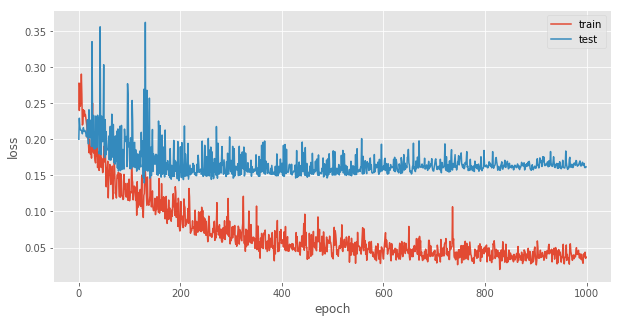

In [9]:
# Plot loss curve for best model
plt.rcParams['figure.figsize'] = (10, 5)

plt.plot(best_model.history['loss'], label='train')
plt.plot(best_model.history['val_loss'], label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [10]:
# Print RMSES and MAES
print('Best RMSE: {:.2f}'.format(best_rmse))
print('Best MAE: {:.2f}'.format(best_mae))
print('Average RMSE: {:.2f}'.format(np.mean(rmses)))
print('Average MAE: {:.2f}'.format(np.mean(maes)))

Best RMSE: 5.18
Best MAE: 3.96
Average RMSE: 5.64
Average MAE: 4.45


{'whiskers': [<matplotlib.lines.Line2D at 0x7f756af8f940>,
 'caps': [<matplotlib.lines.Line2D at 0x7f756af9a0b8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f756af8f7f0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f756af9a748>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f756af9aa90>,
 'means': []}

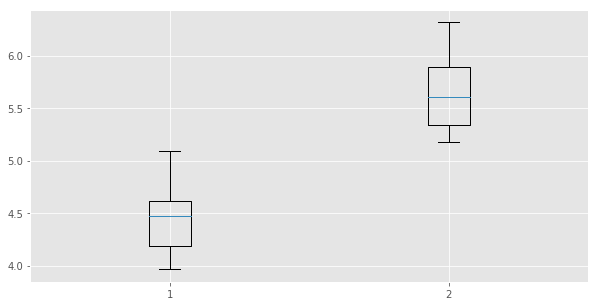

In [11]:
plt.boxplot([maes, rmses])
plt.xticks([1,2],['MAE', 'RMSE'])
plt.show()

Text(0.5, 1.0, 'Tom Brady Fantasy Points 2012, Predicted vs Actual')

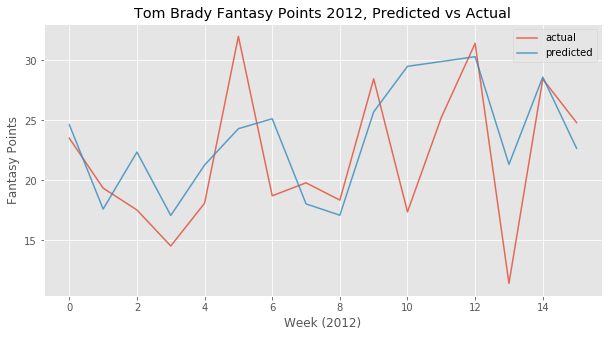

In [12]:
plt.rcParams['figure.figsize'] = (10, 5)
fig, ax = plt.subplots()
plot1 = ax.plot(y_inv, alpha = 0.8, label='actual')
plot1 = ax.plot(best_preds, alpha = 0.8, label='predicted')
ax.legend()
plt.xlabel('Week (2012)')
plt.ylabel('Fantasy Points')
plt.title('Tom Brady Fantasy Points 2012, Predicted vs Actual')

##### Iterative Training

In [9]:
# Remake training and test sets for iterative training
window = 5
X, y = build_lstm_data(brady, window)
X_train, y_train = X[(train_idx-window)[window:]], y[(train_idx-window)[window:]]
X_test, y_test = X[(test_idx-window)], y[(test_idx-window)]

In [15]:
%%time
# Rebuild network for iterative training - stateful model with one batch
n_loops = 10
rmses, maes = [], []
best_rmse, best_mae = 100, 100
best_model = None
best_preds = []

for i in range(0, n_loops):
    model = Sequential()
    model.add(LSTM(50, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), return_sequences=True, stateful=True))
    model.add(Dropout(0.3))
    model.add(LSTM(20))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    # Fit network
    n_iters = 1000
    for k in range(n_iters):
        t0 = time.time()
        model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=0, shuffle=False)
        print('Epoch {}/{}'.format(k+1, n_iters))
        print('{:.2f}s'.format(time.time()-t0))
        model.reset_states()   
        
                
    # Make predictions for test set
    preds = []
    for j in range(len(y_test)):
        X_test_formatted = X_test[j].reshape(1, X_test[j].shape[0], X_test[j].shape[1])
        preds.append(model.predict(X_test_formatted)[0])
        X_train_upd = np.append(X_train, X_test_formatted, axis=0)
        y_train_upd = np.append(y_train, y_test[j])
        model.fit(X_train_upd, y_train_upd, epochs=10, batch_size=1, verbose=0, shuffle=False)
        model.reset_states()    

    # Invert scaling for preds
    preds_inv = np.concatenate((preds, test[:,1:]), axis=1)
    preds_inv = scaler.inverse_transform(preds_inv)
    preds_inv = preds_inv[:,0]
    
    # Calculate RMSE and MAE
    rmses.append(np.sqrt(mean_squared_error(y_inv, preds_inv)))
    maes.append(mean_absolute_error(y_inv, preds_inv))
    
    if maes[i] < best_mae:
        best_rmse = rmses[i]
        best_mae = maes[i]
        best_model = model
        best_preds = preds_inv
        
    gc.collect()
             

Epoch 1/1000
3.82s
Epoch 2/1000
0.11s
Epoch 3/1000
0.18s
Epoch 4/1000
0.14s
Epoch 5/1000
0.11s
Epoch 6/1000
0.11s
Epoch 7/1000
0.10s
Epoch 8/1000
0.11s
Epoch 9/1000
0.11s
Epoch 10/1000
0.11s
Epoch 11/1000
0.10s
Epoch 12/1000
0.14s
Epoch 13/1000
0.15s
Epoch 14/1000
0.11s
Epoch 15/1000
0.11s
Epoch 16/1000
0.13s
Epoch 17/1000
0.15s
Epoch 18/1000
0.12s
Epoch 19/1000
0.11s
Epoch 20/1000
0.10s
Epoch 21/1000
0.10s
Epoch 22/1000
0.11s
Epoch 23/1000
0.11s
Epoch 24/1000
0.11s
Epoch 25/1000
0.12s
Epoch 26/1000
0.13s
Epoch 27/1000
0.10s
Epoch 28/1000
0.10s
Epoch 29/1000
0.12s
Epoch 30/1000
0.11s
Epoch 31/1000
0.10s
Epoch 32/1000
0.12s
Epoch 33/1000
0.13s
Epoch 34/1000
0.12s
Epoch 35/1000
0.12s
Epoch 36/1000
0.10s
Epoch 37/1000
0.11s
Epoch 38/1000
0.12s
Epoch 39/1000
0.11s
Epoch 40/1000
0.11s
Epoch 41/1000
0.10s
Epoch 42/1000
0.13s
Epoch 43/1000
0.11s
Epoch 44/1000
0.13s
Epoch 45/1000
0.12s
Epoch 46/1000
0.13s
Epoch 47/1000
0.11s
Epoch 48/1000
0.10s
Epoch 49/1000
0.10s
Epoch 50/1000
0.12s
Epoch 51/

Epoch 399/1000
0.10s
Epoch 400/1000
0.09s
Epoch 401/1000
0.10s
Epoch 402/1000
0.10s
Epoch 403/1000
0.10s
Epoch 404/1000
0.10s
Epoch 405/1000
0.11s
Epoch 406/1000
0.10s
Epoch 407/1000
0.10s
Epoch 408/1000
0.12s
Epoch 409/1000
0.15s
Epoch 410/1000
0.16s
Epoch 411/1000
0.16s
Epoch 412/1000
0.15s
Epoch 413/1000
0.11s
Epoch 414/1000
0.10s
Epoch 415/1000
0.10s
Epoch 416/1000
0.11s
Epoch 417/1000
0.12s
Epoch 418/1000
0.12s
Epoch 419/1000
0.10s
Epoch 420/1000
0.12s
Epoch 421/1000
0.10s
Epoch 422/1000
0.15s
Epoch 423/1000
0.16s
Epoch 424/1000
0.17s
Epoch 425/1000
0.17s
Epoch 426/1000
0.17s
Epoch 427/1000
0.17s
Epoch 428/1000
0.13s
Epoch 429/1000
0.10s
Epoch 430/1000
0.10s
Epoch 431/1000
0.11s
Epoch 432/1000
0.10s
Epoch 433/1000
0.15s
Epoch 434/1000
0.12s
Epoch 435/1000
0.13s
Epoch 436/1000
0.16s
Epoch 437/1000
0.15s
Epoch 438/1000
0.11s
Epoch 439/1000
0.15s
Epoch 440/1000
0.12s
Epoch 441/1000
0.15s
Epoch 442/1000
0.14s
Epoch 443/1000
0.11s
Epoch 444/1000
0.12s
Epoch 445/1000
0.14s
Epoch 446/100

Epoch 790/1000
0.10s
Epoch 791/1000
0.12s
Epoch 792/1000
0.14s
Epoch 793/1000
0.16s
Epoch 794/1000
0.16s
Epoch 795/1000
0.16s
Epoch 796/1000
0.15s
Epoch 797/1000
0.12s
Epoch 798/1000
0.14s
Epoch 799/1000
0.12s
Epoch 800/1000
0.15s
Epoch 801/1000
0.16s
Epoch 802/1000
0.15s
Epoch 803/1000
0.14s
Epoch 804/1000
0.13s
Epoch 805/1000
0.17s
Epoch 806/1000
0.16s
Epoch 807/1000
0.17s
Epoch 808/1000
0.19s
Epoch 809/1000
0.13s
Epoch 810/1000
0.14s
Epoch 811/1000
0.16s
Epoch 812/1000
0.13s
Epoch 813/1000
0.18s
Epoch 814/1000
0.14s
Epoch 815/1000
0.17s
Epoch 816/1000
0.13s
Epoch 817/1000
0.12s
Epoch 818/1000
0.12s
Epoch 819/1000
0.13s
Epoch 820/1000
0.11s
Epoch 821/1000
0.11s
Epoch 822/1000
0.12s
Epoch 823/1000
0.15s
Epoch 824/1000
0.10s
Epoch 825/1000
0.13s
Epoch 826/1000
0.11s
Epoch 827/1000
0.14s
Epoch 828/1000
0.12s
Epoch 829/1000
0.11s
Epoch 830/1000
0.11s
Epoch 831/1000
0.13s
Epoch 832/1000
0.14s
Epoch 833/1000
0.15s
Epoch 834/1000
0.11s
Epoch 835/1000
0.12s
Epoch 836/1000
0.11s
Epoch 837/100

Epoch 186/1000
0.13s
Epoch 187/1000
0.13s
Epoch 188/1000
0.14s
Epoch 189/1000
0.14s
Epoch 190/1000
0.14s
Epoch 191/1000
0.13s
Epoch 192/1000
0.14s
Epoch 193/1000
0.12s
Epoch 194/1000
0.13s
Epoch 195/1000
0.12s
Epoch 196/1000
0.13s
Epoch 197/1000
0.12s
Epoch 198/1000
0.14s
Epoch 199/1000
0.13s
Epoch 200/1000
0.13s
Epoch 201/1000
0.12s
Epoch 202/1000
0.14s
Epoch 203/1000
0.14s
Epoch 204/1000
0.15s
Epoch 205/1000
0.16s
Epoch 206/1000
0.17s
Epoch 207/1000
0.14s
Epoch 208/1000
0.12s
Epoch 209/1000
0.12s
Epoch 210/1000
0.13s
Epoch 211/1000
0.14s
Epoch 212/1000
0.12s
Epoch 213/1000
0.12s
Epoch 214/1000
0.14s
Epoch 215/1000
0.13s
Epoch 216/1000
0.11s
Epoch 217/1000
0.11s
Epoch 218/1000
0.10s
Epoch 219/1000
0.14s
Epoch 220/1000
0.12s
Epoch 221/1000
0.11s
Epoch 222/1000
0.10s
Epoch 223/1000
0.12s
Epoch 224/1000
0.11s
Epoch 225/1000
0.10s
Epoch 226/1000
0.15s
Epoch 227/1000
0.16s
Epoch 228/1000
0.16s
Epoch 229/1000
0.12s
Epoch 230/1000
0.11s
Epoch 231/1000
0.11s
Epoch 232/1000
0.11s
Epoch 233/100

Epoch 577/1000
0.10s
Epoch 578/1000
0.10s
Epoch 579/1000
0.12s
Epoch 580/1000
0.11s
Epoch 581/1000
0.12s
Epoch 582/1000
0.11s
Epoch 583/1000
0.13s
Epoch 584/1000
0.11s
Epoch 585/1000
0.12s
Epoch 586/1000
0.10s
Epoch 587/1000
0.12s
Epoch 588/1000
0.12s
Epoch 589/1000
0.12s
Epoch 590/1000
0.12s
Epoch 591/1000
0.11s
Epoch 592/1000
0.11s
Epoch 593/1000
0.11s
Epoch 594/1000
0.11s
Epoch 595/1000
0.11s
Epoch 596/1000
0.12s
Epoch 597/1000
0.13s
Epoch 598/1000
0.11s
Epoch 599/1000
0.11s
Epoch 600/1000
0.12s
Epoch 601/1000
0.10s
Epoch 602/1000
0.11s
Epoch 603/1000
0.12s
Epoch 604/1000
0.10s
Epoch 605/1000
0.12s
Epoch 606/1000
0.11s
Epoch 607/1000
0.13s
Epoch 608/1000
0.12s
Epoch 609/1000
0.14s
Epoch 610/1000
0.11s
Epoch 611/1000
0.12s
Epoch 612/1000
0.10s
Epoch 613/1000
0.11s
Epoch 614/1000
0.11s
Epoch 615/1000
0.10s
Epoch 616/1000
0.11s
Epoch 617/1000
0.10s
Epoch 618/1000
0.11s
Epoch 619/1000
0.12s
Epoch 620/1000
0.12s
Epoch 621/1000
0.11s
Epoch 622/1000
0.11s
Epoch 623/1000
0.12s
Epoch 624/100

Epoch 968/1000
0.11s
Epoch 969/1000
0.11s
Epoch 970/1000
0.11s
Epoch 971/1000
0.10s
Epoch 972/1000
0.10s
Epoch 973/1000
0.11s
Epoch 974/1000
0.10s
Epoch 975/1000
0.11s
Epoch 976/1000
0.11s
Epoch 977/1000
0.11s
Epoch 978/1000
0.11s
Epoch 979/1000
0.10s
Epoch 980/1000
0.11s
Epoch 981/1000
0.10s
Epoch 982/1000
0.11s
Epoch 983/1000
0.10s
Epoch 984/1000
0.11s
Epoch 985/1000
0.10s
Epoch 986/1000
0.11s
Epoch 987/1000
0.11s
Epoch 988/1000
0.10s
Epoch 989/1000
0.11s
Epoch 990/1000
0.10s
Epoch 991/1000
0.12s
Epoch 992/1000
0.10s
Epoch 993/1000
0.10s
Epoch 994/1000
0.11s
Epoch 995/1000
0.10s
Epoch 996/1000
0.11s
Epoch 997/1000
0.10s
Epoch 998/1000
0.10s
Epoch 999/1000
0.11s
Epoch 1000/1000
0.11s
Epoch 1/1000
3.95s
Epoch 2/1000
0.12s
Epoch 3/1000
0.11s
Epoch 4/1000
0.10s
Epoch 5/1000
0.11s
Epoch 6/1000
0.10s
Epoch 7/1000
0.10s
Epoch 8/1000
0.09s
Epoch 9/1000
0.10s
Epoch 10/1000
0.11s
Epoch 11/1000
0.10s
Epoch 12/1000
0.10s
Epoch 13/1000
0.10s
Epoch 14/1000
0.10s
Epoch 15/1000
0.11s
Epoch 16/1000
0

Epoch 365/1000
0.11s
Epoch 366/1000
0.10s
Epoch 367/1000
0.10s
Epoch 368/1000
0.11s
Epoch 369/1000
0.11s
Epoch 370/1000
0.11s
Epoch 371/1000
0.10s
Epoch 372/1000
0.11s
Epoch 373/1000
0.10s
Epoch 374/1000
0.10s
Epoch 375/1000
0.11s
Epoch 376/1000
0.10s
Epoch 377/1000
0.11s
Epoch 378/1000
0.10s
Epoch 379/1000
0.11s
Epoch 380/1000
0.10s
Epoch 381/1000
0.10s
Epoch 382/1000
0.11s
Epoch 383/1000
0.10s
Epoch 384/1000
0.11s
Epoch 385/1000
0.11s
Epoch 386/1000
0.11s
Epoch 387/1000
0.11s
Epoch 388/1000
0.11s
Epoch 389/1000
0.11s
Epoch 390/1000
0.10s
Epoch 391/1000
0.11s
Epoch 392/1000
0.10s
Epoch 393/1000
0.11s
Epoch 394/1000
0.11s
Epoch 395/1000
0.10s
Epoch 396/1000
0.10s
Epoch 397/1000
0.10s
Epoch 398/1000
0.11s
Epoch 399/1000
0.10s
Epoch 400/1000
0.11s
Epoch 401/1000
0.11s
Epoch 402/1000
0.10s
Epoch 403/1000
0.11s
Epoch 404/1000
0.10s
Epoch 405/1000
0.11s
Epoch 406/1000
0.10s
Epoch 407/1000
0.10s
Epoch 408/1000
0.11s
Epoch 409/1000
0.10s
Epoch 410/1000
0.11s
Epoch 411/1000
0.10s
Epoch 412/100

Epoch 757/1000
0.13s
Epoch 758/1000
0.11s
Epoch 759/1000
0.10s
Epoch 760/1000
0.11s
Epoch 761/1000
0.11s
Epoch 762/1000
0.15s
Epoch 763/1000
0.15s
Epoch 764/1000
0.16s
Epoch 765/1000
0.15s
Epoch 766/1000
0.12s
Epoch 767/1000
0.17s
Epoch 768/1000
0.17s
Epoch 769/1000
0.17s
Epoch 770/1000
0.10s
Epoch 771/1000
0.09s
Epoch 772/1000
0.11s
Epoch 773/1000
0.09s
Epoch 774/1000
0.11s
Epoch 775/1000
0.12s
Epoch 776/1000
0.11s
Epoch 777/1000
0.11s
Epoch 778/1000
0.13s
Epoch 779/1000
0.15s
Epoch 780/1000
0.16s
Epoch 781/1000
0.15s
Epoch 782/1000
0.11s
Epoch 783/1000
0.11s
Epoch 784/1000
0.16s
Epoch 785/1000
0.16s
Epoch 786/1000
0.18s
Epoch 787/1000
0.17s
Epoch 788/1000
0.18s
Epoch 789/1000
0.11s
Epoch 790/1000
0.12s
Epoch 791/1000
0.14s
Epoch 792/1000
0.14s
Epoch 793/1000
0.13s
Epoch 794/1000
0.13s
Epoch 795/1000
0.12s
Epoch 796/1000
0.13s
Epoch 797/1000
0.12s
Epoch 798/1000
0.13s
Epoch 799/1000
0.13s
Epoch 800/1000
0.13s
Epoch 801/1000
0.12s
Epoch 802/1000
0.13s
Epoch 803/1000
0.12s
Epoch 804/100

Epoch 153/1000
0.12s
Epoch 154/1000
0.12s
Epoch 155/1000
0.11s
Epoch 156/1000
0.10s
Epoch 157/1000
0.13s
Epoch 158/1000
0.11s
Epoch 159/1000
0.13s
Epoch 160/1000
0.11s
Epoch 161/1000
0.12s
Epoch 162/1000
0.11s
Epoch 163/1000
0.13s
Epoch 164/1000
0.11s
Epoch 165/1000
0.12s
Epoch 166/1000
0.11s
Epoch 167/1000
0.13s
Epoch 168/1000
0.12s
Epoch 169/1000
0.13s
Epoch 170/1000
0.11s
Epoch 171/1000
0.11s
Epoch 172/1000
0.13s
Epoch 173/1000
0.13s
Epoch 174/1000
0.14s
Epoch 175/1000
0.13s
Epoch 176/1000
0.12s
Epoch 177/1000
0.13s
Epoch 178/1000
0.11s
Epoch 179/1000
0.10s
Epoch 180/1000
0.11s
Epoch 181/1000
0.10s
Epoch 182/1000
0.12s
Epoch 183/1000
0.11s
Epoch 184/1000
0.15s
Epoch 185/1000
0.18s
Epoch 186/1000
0.18s
Epoch 187/1000
0.17s
Epoch 188/1000
0.13s
Epoch 189/1000
0.16s
Epoch 190/1000
0.13s
Epoch 191/1000
0.10s
Epoch 192/1000
0.10s
Epoch 193/1000
0.11s
Epoch 194/1000
0.10s
Epoch 195/1000
0.12s
Epoch 196/1000
0.10s
Epoch 197/1000
0.11s
Epoch 198/1000
0.10s
Epoch 199/1000
0.10s
Epoch 200/100

Epoch 545/1000
0.12s
Epoch 546/1000
0.13s
Epoch 547/1000
0.13s
Epoch 548/1000
0.13s
Epoch 549/1000
0.12s
Epoch 550/1000
0.13s
Epoch 551/1000
0.12s
Epoch 552/1000
0.13s
Epoch 553/1000
0.11s
Epoch 554/1000
0.13s
Epoch 555/1000
0.13s
Epoch 556/1000
0.13s
Epoch 557/1000
0.11s
Epoch 558/1000
0.13s
Epoch 559/1000
0.13s
Epoch 560/1000
0.14s
Epoch 561/1000
0.14s
Epoch 562/1000
0.14s
Epoch 563/1000
0.15s
Epoch 564/1000
0.13s
Epoch 565/1000
0.13s
Epoch 566/1000
0.13s
Epoch 567/1000
0.14s
Epoch 568/1000
0.12s
Epoch 569/1000
0.13s
Epoch 570/1000
0.13s
Epoch 571/1000
0.15s
Epoch 572/1000
0.14s
Epoch 573/1000
0.13s
Epoch 574/1000
0.12s
Epoch 575/1000
0.14s
Epoch 576/1000
0.16s
Epoch 577/1000
0.12s
Epoch 578/1000
0.15s
Epoch 579/1000
0.15s
Epoch 580/1000
0.15s
Epoch 581/1000
0.13s
Epoch 582/1000
0.14s
Epoch 583/1000
0.13s
Epoch 584/1000
0.14s
Epoch 585/1000
0.17s
Epoch 586/1000
0.15s
Epoch 587/1000
0.13s
Epoch 588/1000
0.15s
Epoch 589/1000
0.17s
Epoch 590/1000
0.16s
Epoch 591/1000
0.12s
Epoch 592/100

Epoch 937/1000
0.12s
Epoch 938/1000
0.11s
Epoch 939/1000
0.11s
Epoch 940/1000
0.12s
Epoch 941/1000
0.12s
Epoch 942/1000
0.14s
Epoch 943/1000
0.13s
Epoch 944/1000
0.12s
Epoch 945/1000
0.11s
Epoch 946/1000
0.12s
Epoch 947/1000
0.18s
Epoch 948/1000
0.31s
Epoch 949/1000
0.11s
Epoch 950/1000
0.10s
Epoch 951/1000
0.11s
Epoch 952/1000
0.11s
Epoch 953/1000
0.10s
Epoch 954/1000
0.11s
Epoch 955/1000
0.11s
Epoch 956/1000
0.12s
Epoch 957/1000
0.11s
Epoch 958/1000
0.12s
Epoch 959/1000
0.11s
Epoch 960/1000
0.10s
Epoch 961/1000
0.11s
Epoch 962/1000
0.09s
Epoch 963/1000
0.11s
Epoch 964/1000
0.10s
Epoch 965/1000
0.10s
Epoch 966/1000
0.11s
Epoch 967/1000
0.10s
Epoch 968/1000
0.12s
Epoch 969/1000
0.12s
Epoch 970/1000
0.11s
Epoch 971/1000
0.12s
Epoch 972/1000
0.10s
Epoch 973/1000
0.10s
Epoch 974/1000
0.11s
Epoch 975/1000
0.11s
Epoch 976/1000
0.10s
Epoch 977/1000
0.10s
Epoch 978/1000
0.10s
Epoch 979/1000
0.10s
Epoch 980/1000
0.11s
Epoch 981/1000
0.11s
Epoch 982/1000
0.10s
Epoch 983/1000
0.11s
Epoch 984/100

Epoch 333/1000
0.14s
Epoch 334/1000
0.11s
Epoch 335/1000
0.12s
Epoch 336/1000
0.11s
Epoch 337/1000
0.11s
Epoch 338/1000
0.13s
Epoch 339/1000
0.11s
Epoch 340/1000
0.11s
Epoch 341/1000
0.11s
Epoch 342/1000
0.12s
Epoch 343/1000
0.11s
Epoch 344/1000
0.12s
Epoch 345/1000
0.11s
Epoch 346/1000
0.12s
Epoch 347/1000
0.11s
Epoch 348/1000
0.10s
Epoch 349/1000
0.11s
Epoch 350/1000
0.11s
Epoch 351/1000
0.11s
Epoch 352/1000
0.10s
Epoch 353/1000
0.12s
Epoch 354/1000
0.11s
Epoch 355/1000
0.12s
Epoch 356/1000
0.10s
Epoch 357/1000
0.10s
Epoch 358/1000
0.12s
Epoch 359/1000
0.10s
Epoch 360/1000
0.10s
Epoch 361/1000
0.10s
Epoch 362/1000
0.10s
Epoch 363/1000
0.11s
Epoch 364/1000
0.10s
Epoch 365/1000
0.10s
Epoch 366/1000
0.10s
Epoch 367/1000
0.10s
Epoch 368/1000
0.16s
Epoch 369/1000
0.13s
Epoch 370/1000
0.10s
Epoch 371/1000
0.10s
Epoch 372/1000
0.11s
Epoch 373/1000
0.10s
Epoch 374/1000
0.11s
Epoch 375/1000
0.10s
Epoch 376/1000
0.10s
Epoch 377/1000
0.12s
Epoch 378/1000
0.10s
Epoch 379/1000
0.12s
Epoch 380/100

Epoch 724/1000
0.15s
Epoch 725/1000
0.16s
Epoch 726/1000
0.15s
Epoch 727/1000
0.14s
Epoch 728/1000
0.11s
Epoch 729/1000
0.12s
Epoch 730/1000
0.15s
Epoch 731/1000
0.16s
Epoch 732/1000
0.15s
Epoch 733/1000
0.15s
Epoch 734/1000
0.14s
Epoch 735/1000
0.13s
Epoch 736/1000
0.13s
Epoch 737/1000
0.11s
Epoch 738/1000
0.12s
Epoch 739/1000
0.13s
Epoch 740/1000
0.14s
Epoch 741/1000
0.13s
Epoch 742/1000
0.13s
Epoch 743/1000
0.12s
Epoch 744/1000
0.12s
Epoch 745/1000
0.11s
Epoch 746/1000
0.13s
Epoch 747/1000
0.12s
Epoch 748/1000
0.13s
Epoch 749/1000
0.10s
Epoch 750/1000
0.10s
Epoch 751/1000
0.11s
Epoch 752/1000
0.11s
Epoch 753/1000
0.12s
Epoch 754/1000
0.10s
Epoch 755/1000
0.11s
Epoch 756/1000
0.12s
Epoch 757/1000
0.10s
Epoch 758/1000
0.11s
Epoch 759/1000
0.11s
Epoch 760/1000
0.12s
Epoch 761/1000
0.11s
Epoch 762/1000
0.11s
Epoch 763/1000
0.10s
Epoch 764/1000
0.10s
Epoch 765/1000
0.11s
Epoch 766/1000
0.10s
Epoch 767/1000
0.11s
Epoch 768/1000
0.10s
Epoch 769/1000
0.10s
Epoch 770/1000
0.10s
Epoch 771/100

Epoch 121/1000
0.10s
Epoch 122/1000
0.13s
Epoch 123/1000
0.10s
Epoch 124/1000
0.12s
Epoch 125/1000
0.12s
Epoch 126/1000
0.12s
Epoch 127/1000
0.11s
Epoch 128/1000
0.12s
Epoch 129/1000
0.13s
Epoch 130/1000
0.14s
Epoch 131/1000
0.11s
Epoch 132/1000
0.12s
Epoch 133/1000
0.12s
Epoch 134/1000
0.12s
Epoch 135/1000
0.11s
Epoch 136/1000
0.10s
Epoch 137/1000
0.10s
Epoch 138/1000
0.09s
Epoch 139/1000
0.10s
Epoch 140/1000
0.10s
Epoch 141/1000
0.10s
Epoch 142/1000
0.15s
Epoch 143/1000
0.10s
Epoch 144/1000
0.10s
Epoch 145/1000
0.10s
Epoch 146/1000
0.11s
Epoch 147/1000
0.11s
Epoch 148/1000
0.10s
Epoch 149/1000
0.10s
Epoch 150/1000
0.09s
Epoch 151/1000
0.13s
Epoch 152/1000
0.15s
Epoch 153/1000
0.14s
Epoch 154/1000
0.10s
Epoch 155/1000
0.11s
Epoch 156/1000
0.10s
Epoch 157/1000
0.11s
Epoch 158/1000
0.10s
Epoch 159/1000
0.11s
Epoch 160/1000
0.11s
Epoch 161/1000
0.10s
Epoch 162/1000
0.10s
Epoch 163/1000
0.10s
Epoch 164/1000
0.10s
Epoch 165/1000
0.10s
Epoch 166/1000
0.10s
Epoch 167/1000
0.10s
Epoch 168/100

Epoch 513/1000
0.11s
Epoch 514/1000
0.10s
Epoch 515/1000
0.10s
Epoch 516/1000
0.10s
Epoch 517/1000
0.10s
Epoch 518/1000
0.10s
Epoch 519/1000
0.10s
Epoch 520/1000
0.11s
Epoch 521/1000
0.10s
Epoch 522/1000
0.09s
Epoch 523/1000
0.10s
Epoch 524/1000
0.10s
Epoch 525/1000
0.10s
Epoch 526/1000
0.10s
Epoch 527/1000
0.10s
Epoch 528/1000
0.10s
Epoch 529/1000
0.10s
Epoch 530/1000
0.10s
Epoch 531/1000
0.09s
Epoch 532/1000
0.12s
Epoch 533/1000
0.16s
Epoch 534/1000
0.12s
Epoch 535/1000
0.10s
Epoch 536/1000
0.09s
Epoch 537/1000
0.10s
Epoch 538/1000
0.12s
Epoch 539/1000
0.16s
Epoch 540/1000
0.10s
Epoch 541/1000
0.10s
Epoch 542/1000
0.10s
Epoch 543/1000
0.10s
Epoch 544/1000
0.10s
Epoch 545/1000
0.11s
Epoch 546/1000
0.12s
Epoch 547/1000
0.10s
Epoch 548/1000
0.10s
Epoch 549/1000
0.09s
Epoch 550/1000
0.09s
Epoch 551/1000
0.10s
Epoch 552/1000
0.09s
Epoch 553/1000
0.09s
Epoch 554/1000
0.10s
Epoch 555/1000
0.09s
Epoch 556/1000
0.10s
Epoch 557/1000
0.09s
Epoch 558/1000
0.09s
Epoch 559/1000
0.11s
Epoch 560/100

Epoch 904/1000
0.10s
Epoch 905/1000
0.11s
Epoch 906/1000
0.10s
Epoch 907/1000
0.10s
Epoch 908/1000
0.11s
Epoch 909/1000
0.10s
Epoch 910/1000
0.11s
Epoch 911/1000
0.10s
Epoch 912/1000
0.10s
Epoch 913/1000
0.10s
Epoch 914/1000
0.10s
Epoch 915/1000
0.10s
Epoch 916/1000
0.10s
Epoch 917/1000
0.11s
Epoch 918/1000
0.10s
Epoch 919/1000
0.10s
Epoch 920/1000
0.13s
Epoch 921/1000
0.11s
Epoch 922/1000
0.11s
Epoch 923/1000
0.11s
Epoch 924/1000
0.11s
Epoch 925/1000
0.10s
Epoch 926/1000
0.10s
Epoch 927/1000
0.11s
Epoch 928/1000
0.09s
Epoch 929/1000
0.10s
Epoch 930/1000
0.09s
Epoch 931/1000
0.09s
Epoch 932/1000
0.10s
Epoch 933/1000
0.09s
Epoch 934/1000
0.10s
Epoch 935/1000
0.09s
Epoch 936/1000
0.09s
Epoch 937/1000
0.10s
Epoch 938/1000
0.09s
Epoch 939/1000
0.09s
Epoch 940/1000
0.11s
Epoch 941/1000
0.09s
Epoch 942/1000
0.10s
Epoch 943/1000
0.09s
Epoch 944/1000
0.09s
Epoch 945/1000
0.11s
Epoch 946/1000
0.10s
Epoch 947/1000
0.13s
Epoch 948/1000
0.11s
Epoch 949/1000
0.11s
Epoch 950/1000
0.10s
Epoch 951/100

Epoch 301/1000
0.16s
Epoch 302/1000
0.10s
Epoch 303/1000
0.11s
Epoch 304/1000
0.13s
Epoch 305/1000
0.16s
Epoch 306/1000
0.10s
Epoch 307/1000
0.11s
Epoch 308/1000
0.14s
Epoch 309/1000
0.16s
Epoch 310/1000
0.13s
Epoch 311/1000
0.14s
Epoch 312/1000
0.14s
Epoch 313/1000
0.14s
Epoch 314/1000
0.15s
Epoch 315/1000
0.11s
Epoch 316/1000
0.11s
Epoch 317/1000
0.10s
Epoch 318/1000
0.12s
Epoch 319/1000
0.15s
Epoch 320/1000
0.17s
Epoch 321/1000
0.16s
Epoch 322/1000
0.16s
Epoch 323/1000
0.19s
Epoch 324/1000
0.16s
Epoch 325/1000
0.11s
Epoch 326/1000
0.10s
Epoch 327/1000
0.11s
Epoch 328/1000
0.11s
Epoch 329/1000
0.12s
Epoch 330/1000
0.11s
Epoch 331/1000
0.11s
Epoch 332/1000
0.10s
Epoch 333/1000
0.10s
Epoch 334/1000
0.11s
Epoch 335/1000
0.10s
Epoch 336/1000
0.11s
Epoch 337/1000
0.11s
Epoch 338/1000
0.11s
Epoch 339/1000
0.12s
Epoch 340/1000
0.14s
Epoch 341/1000
0.12s
Epoch 342/1000
0.10s
Epoch 343/1000
0.11s
Epoch 344/1000
0.11s
Epoch 345/1000
0.13s
Epoch 346/1000
0.13s
Epoch 347/1000
0.13s
Epoch 348/100

Epoch 693/1000
0.10s
Epoch 694/1000
0.10s
Epoch 695/1000
0.10s
Epoch 696/1000
0.11s
Epoch 697/1000
0.10s
Epoch 698/1000
0.10s
Epoch 699/1000
0.11s
Epoch 700/1000
0.10s
Epoch 701/1000
0.10s
Epoch 702/1000
0.10s
Epoch 703/1000
0.10s
Epoch 704/1000
0.11s
Epoch 705/1000
0.10s
Epoch 706/1000
0.11s
Epoch 707/1000
0.10s
Epoch 708/1000
0.10s
Epoch 709/1000
0.11s
Epoch 710/1000
0.10s
Epoch 711/1000
0.11s
Epoch 712/1000
0.10s
Epoch 713/1000
0.10s
Epoch 714/1000
0.10s
Epoch 715/1000
0.10s
Epoch 716/1000
0.11s
Epoch 717/1000
0.10s
Epoch 718/1000
0.11s
Epoch 719/1000
0.10s
Epoch 720/1000
0.10s
Epoch 721/1000
0.11s
Epoch 722/1000
0.10s
Epoch 723/1000
0.11s
Epoch 724/1000
0.10s
Epoch 725/1000
0.10s
Epoch 726/1000
0.11s
Epoch 727/1000
0.10s
Epoch 728/1000
0.11s
Epoch 729/1000
0.10s
Epoch 730/1000
0.11s
Epoch 731/1000
0.11s
Epoch 732/1000
0.11s
Epoch 733/1000
0.11s
Epoch 734/1000
0.10s
Epoch 735/1000
0.12s
Epoch 736/1000
0.10s
Epoch 737/1000
0.11s
Epoch 738/1000
0.12s
Epoch 739/1000
0.11s
Epoch 740/100

Epoch 89/1000
0.11s
Epoch 90/1000
0.11s
Epoch 91/1000
0.10s
Epoch 92/1000
0.10s
Epoch 93/1000
0.11s
Epoch 94/1000
0.10s
Epoch 95/1000
0.10s
Epoch 96/1000
0.10s
Epoch 97/1000
0.10s
Epoch 98/1000
0.11s
Epoch 99/1000
0.10s
Epoch 100/1000
0.10s
Epoch 101/1000
0.10s
Epoch 102/1000
0.10s
Epoch 103/1000
0.11s
Epoch 104/1000
0.10s
Epoch 105/1000
0.11s
Epoch 106/1000
0.10s
Epoch 107/1000
0.15s
Epoch 108/1000
0.11s
Epoch 109/1000
0.11s
Epoch 110/1000
0.11s
Epoch 111/1000
0.11s
Epoch 112/1000
0.11s
Epoch 113/1000
0.10s
Epoch 114/1000
0.10s
Epoch 115/1000
0.10s
Epoch 116/1000
0.10s
Epoch 117/1000
0.10s
Epoch 118/1000
0.10s
Epoch 119/1000
0.10s
Epoch 120/1000
0.10s
Epoch 121/1000
0.10s
Epoch 122/1000
0.11s
Epoch 123/1000
0.10s
Epoch 124/1000
0.11s
Epoch 125/1000
0.10s
Epoch 126/1000
0.10s
Epoch 127/1000
0.10s
Epoch 128/1000
0.10s
Epoch 129/1000
0.11s
Epoch 130/1000
0.11s
Epoch 131/1000
0.12s
Epoch 132/1000
0.11s
Epoch 133/1000
0.10s
Epoch 134/1000
0.10s
Epoch 135/1000
0.11s
Epoch 136/1000
0.11s
Epo

Epoch 480/1000
0.10s
Epoch 481/1000
0.11s
Epoch 482/1000
0.12s
Epoch 483/1000
0.10s
Epoch 484/1000
0.11s
Epoch 485/1000
0.10s
Epoch 486/1000
0.10s
Epoch 487/1000
0.11s
Epoch 488/1000
0.10s
Epoch 489/1000
0.11s
Epoch 490/1000
0.11s
Epoch 491/1000
0.15s
Epoch 492/1000
0.12s
Epoch 493/1000
0.12s
Epoch 494/1000
0.11s
Epoch 495/1000
0.13s
Epoch 496/1000
0.11s
Epoch 497/1000
0.12s
Epoch 498/1000
0.11s
Epoch 499/1000
0.11s
Epoch 500/1000
0.13s
Epoch 501/1000
0.12s
Epoch 502/1000
0.11s
Epoch 503/1000
0.10s
Epoch 504/1000
0.11s
Epoch 505/1000
0.10s
Epoch 506/1000
0.10s
Epoch 507/1000
0.12s
Epoch 508/1000
0.11s
Epoch 509/1000
0.11s
Epoch 510/1000
0.10s
Epoch 511/1000
0.11s
Epoch 512/1000
0.10s
Epoch 513/1000
0.10s
Epoch 514/1000
0.11s
Epoch 515/1000
0.10s
Epoch 516/1000
0.11s
Epoch 517/1000
0.11s
Epoch 518/1000
0.11s
Epoch 519/1000
0.10s
Epoch 520/1000
0.10s
Epoch 521/1000
0.11s
Epoch 522/1000
0.10s
Epoch 523/1000
0.11s
Epoch 524/1000
0.10s
Epoch 525/1000
0.12s
Epoch 526/1000
0.11s
Epoch 527/100

Epoch 872/1000
0.11s
Epoch 873/1000
0.10s
Epoch 874/1000
0.11s
Epoch 875/1000
0.10s
Epoch 876/1000
0.11s
Epoch 877/1000
0.10s
Epoch 878/1000
0.10s
Epoch 879/1000
0.11s
Epoch 880/1000
0.10s
Epoch 881/1000
0.11s
Epoch 882/1000
0.10s
Epoch 883/1000
0.10s
Epoch 884/1000
0.11s
Epoch 885/1000
0.10s
Epoch 886/1000
0.13s
Epoch 887/1000
0.12s
Epoch 888/1000
0.12s
Epoch 889/1000
0.11s
Epoch 890/1000
0.12s
Epoch 891/1000
0.17s
Epoch 892/1000
0.13s
Epoch 893/1000
0.10s
Epoch 894/1000
0.11s
Epoch 895/1000
0.10s
Epoch 896/1000
0.15s
Epoch 897/1000
0.14s
Epoch 898/1000
0.13s
Epoch 899/1000
0.10s
Epoch 900/1000
0.11s
Epoch 901/1000
0.11s
Epoch 902/1000
0.16s
Epoch 903/1000
0.12s
Epoch 904/1000
0.12s
Epoch 905/1000
0.15s
Epoch 906/1000
0.15s
Epoch 907/1000
0.15s
Epoch 908/1000
0.16s
Epoch 909/1000
0.16s
Epoch 910/1000
0.11s
Epoch 911/1000
0.12s
Epoch 912/1000
0.15s
Epoch 913/1000
0.12s
Epoch 914/1000
0.11s
Epoch 915/1000
0.12s
Epoch 916/1000
0.11s
Epoch 917/1000
0.11s
Epoch 918/1000
0.13s
Epoch 919/100

Epoch 268/1000
0.11s
Epoch 269/1000
0.10s
Epoch 270/1000
0.12s
Epoch 271/1000
0.10s
Epoch 272/1000
0.10s
Epoch 273/1000
0.11s
Epoch 274/1000
0.09s
Epoch 275/1000
0.10s
Epoch 276/1000
0.10s
Epoch 277/1000
0.10s
Epoch 278/1000
0.13s
Epoch 279/1000
0.10s
Epoch 280/1000
0.10s
Epoch 281/1000
0.09s
Epoch 282/1000
0.09s
Epoch 283/1000
0.11s
Epoch 284/1000
0.10s
Epoch 285/1000
0.11s
Epoch 286/1000
0.10s
Epoch 287/1000
0.10s
Epoch 288/1000
0.10s
Epoch 289/1000
0.09s
Epoch 290/1000
0.12s
Epoch 291/1000
0.10s
Epoch 292/1000
0.11s
Epoch 293/1000
0.10s
Epoch 294/1000
0.10s
Epoch 295/1000
0.11s
Epoch 296/1000
0.10s
Epoch 297/1000
0.11s
Epoch 298/1000
0.10s
Epoch 299/1000
0.11s
Epoch 300/1000
0.11s
Epoch 301/1000
0.11s
Epoch 302/1000
0.12s
Epoch 303/1000
0.10s
Epoch 304/1000
0.12s
Epoch 305/1000
0.10s
Epoch 306/1000
0.11s
Epoch 307/1000
0.10s
Epoch 308/1000
0.10s
Epoch 309/1000
0.11s
Epoch 310/1000
0.11s
Epoch 311/1000
0.11s
Epoch 312/1000
0.11s
Epoch 313/1000
0.11s
Epoch 314/1000
0.10s
Epoch 315/100

Epoch 660/1000
0.11s
Epoch 661/1000
0.09s
Epoch 662/1000
0.09s
Epoch 663/1000
0.11s
Epoch 664/1000
0.10s
Epoch 665/1000
0.11s
Epoch 666/1000
0.09s
Epoch 667/1000
0.09s
Epoch 668/1000
0.10s
Epoch 669/1000
0.10s
Epoch 670/1000
0.10s
Epoch 671/1000
0.10s
Epoch 672/1000
0.10s
Epoch 673/1000
0.10s
Epoch 674/1000
0.09s
Epoch 675/1000
0.10s
Epoch 676/1000
0.10s
Epoch 677/1000
0.09s
Epoch 678/1000
0.10s
Epoch 679/1000
0.10s
Epoch 680/1000
0.10s
Epoch 681/1000
0.10s
Epoch 682/1000
0.09s
Epoch 683/1000
0.10s
Epoch 684/1000
0.09s
Epoch 685/1000
0.10s
Epoch 686/1000
0.09s
Epoch 687/1000
0.10s
Epoch 688/1000
0.10s
Epoch 689/1000
0.09s
Epoch 690/1000
0.10s
Epoch 691/1000
0.10s
Epoch 692/1000
0.10s
Epoch 693/1000
0.10s
Epoch 694/1000
0.09s
Epoch 695/1000
0.10s
Epoch 696/1000
0.11s
Epoch 697/1000
0.10s
Epoch 698/1000
0.12s
Epoch 699/1000
0.14s
Epoch 700/1000
0.11s
Epoch 701/1000
0.10s
Epoch 702/1000
0.10s
Epoch 703/1000
0.10s
Epoch 704/1000
0.10s
Epoch 705/1000
0.11s
Epoch 706/1000
0.10s
Epoch 707/100

Epoch 54/1000
0.10s
Epoch 55/1000
0.12s
Epoch 56/1000
0.12s
Epoch 57/1000
0.11s
Epoch 58/1000
0.10s
Epoch 59/1000
0.10s
Epoch 60/1000
0.11s
Epoch 61/1000
0.10s
Epoch 62/1000
0.11s
Epoch 63/1000
0.10s
Epoch 64/1000
0.10s
Epoch 65/1000
0.10s
Epoch 66/1000
0.10s
Epoch 67/1000
0.11s
Epoch 68/1000
0.10s
Epoch 69/1000
0.09s
Epoch 70/1000
0.10s
Epoch 71/1000
0.10s
Epoch 72/1000
0.12s
Epoch 73/1000
0.10s
Epoch 74/1000
0.10s
Epoch 75/1000
0.10s
Epoch 76/1000
0.10s
Epoch 77/1000
0.10s
Epoch 78/1000
0.10s
Epoch 79/1000
0.10s
Epoch 80/1000
0.10s
Epoch 81/1000
0.10s
Epoch 82/1000
0.11s
Epoch 83/1000
0.10s
Epoch 84/1000
0.10s
Epoch 85/1000
0.12s
Epoch 86/1000
0.13s
Epoch 87/1000
0.11s
Epoch 88/1000
0.10s
Epoch 89/1000
0.12s
Epoch 90/1000
0.11s
Epoch 91/1000
0.10s
Epoch 92/1000
0.10s
Epoch 93/1000
0.10s
Epoch 94/1000
0.10s
Epoch 95/1000
0.10s
Epoch 96/1000
0.10s
Epoch 97/1000
0.12s
Epoch 98/1000
0.11s
Epoch 99/1000
0.10s
Epoch 100/1000
0.10s
Epoch 101/1000
0.11s
Epoch 102/1000
0.10s
Epoch 103/1000
0.

Epoch 447/1000
0.11s
Epoch 448/1000
0.11s
Epoch 449/1000
0.11s
Epoch 450/1000
0.10s
Epoch 451/1000
0.10s
Epoch 452/1000
0.11s
Epoch 453/1000
0.10s
Epoch 454/1000
0.11s
Epoch 455/1000
0.10s
Epoch 456/1000
0.12s
Epoch 457/1000
0.10s
Epoch 458/1000
0.11s
Epoch 459/1000
0.12s
Epoch 460/1000
0.10s
Epoch 461/1000
0.12s
Epoch 462/1000
0.10s
Epoch 463/1000
0.12s
Epoch 464/1000
0.11s
Epoch 465/1000
0.12s
Epoch 466/1000
0.11s
Epoch 467/1000
0.11s
Epoch 468/1000
0.10s
Epoch 469/1000
0.12s
Epoch 470/1000
0.12s
Epoch 471/1000
0.11s
Epoch 472/1000
0.11s
Epoch 473/1000
0.10s
Epoch 474/1000
0.11s
Epoch 475/1000
0.11s
Epoch 476/1000
0.13s
Epoch 477/1000
0.11s
Epoch 478/1000
0.11s
Epoch 479/1000
0.12s
Epoch 480/1000
0.10s
Epoch 481/1000
0.12s
Epoch 482/1000
0.09s
Epoch 483/1000
0.10s
Epoch 484/1000
0.10s
Epoch 485/1000
0.11s
Epoch 486/1000
0.10s
Epoch 487/1000
0.10s
Epoch 488/1000
0.11s
Epoch 489/1000
0.10s
Epoch 490/1000
0.10s
Epoch 491/1000
0.11s
Epoch 492/1000
0.12s
Epoch 493/1000
0.11s
Epoch 494/100

Epoch 839/1000
0.10s
Epoch 840/1000
0.11s
Epoch 841/1000
0.12s
Epoch 842/1000
0.11s
Epoch 843/1000
0.10s
Epoch 844/1000
0.11s
Epoch 845/1000
0.10s
Epoch 846/1000
0.11s
Epoch 847/1000
0.11s
Epoch 848/1000
0.10s
Epoch 849/1000
0.12s
Epoch 850/1000
0.11s
Epoch 851/1000
0.12s
Epoch 852/1000
0.10s
Epoch 853/1000
0.11s
Epoch 854/1000
0.13s
Epoch 855/1000
0.14s
Epoch 856/1000
0.10s
Epoch 857/1000
0.10s
Epoch 858/1000
0.11s
Epoch 859/1000
0.11s
Epoch 860/1000
0.12s
Epoch 861/1000
0.10s
Epoch 862/1000
0.12s
Epoch 863/1000
0.11s
Epoch 864/1000
0.12s
Epoch 865/1000
0.11s
Epoch 866/1000
0.11s
Epoch 867/1000
0.12s
Epoch 868/1000
0.11s
Epoch 869/1000
0.12s
Epoch 870/1000
0.11s
Epoch 871/1000
0.12s
Epoch 872/1000
0.12s
Epoch 873/1000
0.11s
Epoch 874/1000
0.10s
Epoch 875/1000
0.11s
Epoch 876/1000
0.15s
Epoch 877/1000
0.18s
Epoch 878/1000
0.17s
Epoch 879/1000
0.17s
Epoch 880/1000
0.14s
Epoch 881/1000
0.18s
Epoch 882/1000
0.11s
Epoch 883/1000
0.10s
Epoch 884/1000
0.12s
Epoch 885/1000
0.10s
Epoch 886/100

In [17]:
# Print RMSES and MAES
print('Best RMSE: {:.2f}'.format(best_rmse))
print('Best MAE: {:.2f}'.format(best_mae))
print('Average RMSE: {:.2f}'.format(np.mean(rmses)))
print('Average MAE: {:.2f}'.format(np.mean(maes)))

Best RMSE: 6.26
Best MAE: 4.70
Average RMSE: 6.56
Average MAE: 5.19


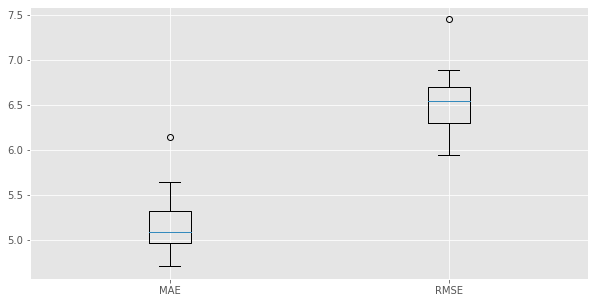

In [22]:
plt.rcParams['figure.figsize'] = (10, 5)
plt.boxplot([maes, rmses])
plt.xticks([1,2],['MAE', 'RMSE'])
plt.show()

Text(0.5, 1.0, 'Tom Brady Fantasy Points 2012, Predicted vs Actual (Online Training)')

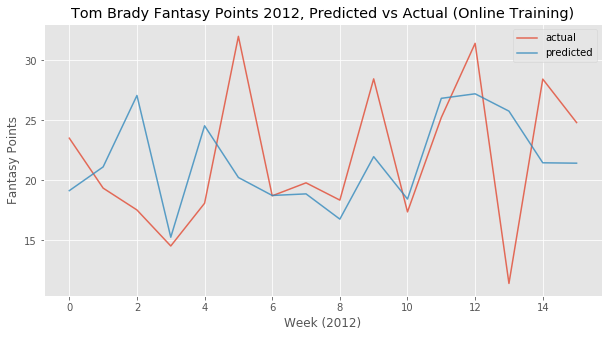

In [23]:
plt.rcParams['figure.figsize'] = (10, 5)
fig, ax = plt.subplots()
plot1 = ax.plot(y_inv, alpha = 0.8, label='actual')
plot1 = ax.plot(best_preds, alpha = 0.8, label='predicted')
ax.legend()
plt.xlabel('Week (2012)')
plt.ylabel('Fantasy Points')
plt.title('Tom Brady Fantasy Points 2012, Predicted vs Actual (Online Training)')

## LeSean McCoy

In [6]:
# Read in data
mccoy = pd.read_csv('../data/data_final/final/features_raw/mccoy.csv')
mccoy = mccoy.loc[:, features]
mccoy['date'] = pd.to_datetime(mccoy['date'])
mccoy = replace_nans_mean(mccoy, split_date)

In [7]:
# Train + test set indices
mccoy_played_only = mccoy.loc[mccoy['player_played']==1].copy().reset_index(drop=True)
train_idx = mccoy_played_only.loc[mccoy['date']<split_date].index.values
test_idx = mccoy_played_only.loc[mccoy_played_only['date']>split_date].index.values

# Scale Features
mccoy.drop('date', axis=1, inplace=True)
scaler = MinMaxScaler()
scaler.fit(mccoy)
mccoy = scaler.transform(mccoy)

# Train + test sets
train, test = mccoy[train_idx], mccoy[test_idx]

In [8]:
# Create train and test sets
window = 5

X, y = build_lstm_data(mccoy, window)
X = X[y!=0] # Keep games not played for time series, but do not make predictions
y = y[y!=0]

X_train, y_train = X[(train_idx-window)[window:]], y[(train_idx-window)[window:]]
X_test, y_test = X[(test_idx-window)], y[(test_idx-window)]

In [9]:
# Invert scaling of y for testing comparison
y_inv = np.concatenate((y_test.reshape(len(y_test),1), test[:,1:]), axis=1)
y_inv = scaler.inverse_transform(y_inv)
y_inv = y_inv[:,0]

In [22]:
%%time
# Build networks. Loop n times to deal with ranodmness.
n_loops = 10
rmses, maes = [], []
best_rmse, best_mae = 100, 100
best_model = None
best_preds = []

for i in range(0, n_loops):
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(Dropout(.3))
    model.add(LSTM(20))
    model.add(Dropout(.3))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    
    # Fit network
    lstm_model = model.fit(X_train, y_train, epochs=500, batch_size=13, validation_data = (X_test, y_test), verbose=2, shuffle=False)
    
    # Make predictions for test set
    preds = model.predict(X_test)
    
    # Invert scaling for preds
    preds_inv = np.concatenate((preds, test[:,1:]), axis=1)
    preds_inv = scaler.inverse_transform(preds_inv)
    preds_inv = preds_inv[:,0]
    
    # Calculate RMSE and MAE
    rmses.append(np.sqrt(mean_squared_error(y_inv, preds_inv)))
    maes.append(mean_absolute_error(y_inv, preds_inv))
    
    if maes[i] < best_mae:
        best_rmse = rmses[i]
        best_mae = maes[i]
        best_model = lstm_model
        best_preds = preds_inv
        
    gc.collect()


Train on 25 samples, validate on 11 samples
Epoch 1/500
 - 1s - loss: 0.4502 - val_loss: 0.1143
Epoch 2/500
 - 0s - loss: 0.2074 - val_loss: 0.2144
Epoch 3/500
 - 0s - loss: 0.2470 - val_loss: 0.3374
Epoch 4/500
 - 0s - loss: 0.2504 - val_loss: 0.2720
Epoch 5/500
 - 0s - loss: 0.2275 - val_loss: 0.1669
Epoch 6/500
 - 0s - loss: 0.2013 - val_loss: 0.0986
Epoch 7/500
 - 0s - loss: 0.1722 - val_loss: 0.0941
Epoch 8/500
 - 0s - loss: 0.1867 - val_loss: 0.0956
Epoch 9/500
 - 0s - loss: 0.1891 - val_loss: 0.1019
Epoch 10/500
 - 0s - loss: 0.1738 - val_loss: 0.1401
Epoch 11/500
 - 0s - loss: 0.1920 - val_loss: 0.1840
Epoch 12/500
 - 0s - loss: 0.2072 - val_loss: 0.2197
Epoch 13/500
 - 0s - loss: 0.1823 - val_loss: 0.2190
Epoch 14/500
 - 0s - loss: 0.2067 - val_loss: 0.1888
Epoch 15/500
 - 0s - loss: 0.1898 - val_loss: 0.1568
Epoch 16/500
 - 0s - loss: 0.1629 - val_loss: 0.1339
Epoch 17/500
 - 0s - loss: 0.1815 - val_loss: 0.1404
Epoch 18/500
 - 0s - loss: 0.1945 - val_loss: 0.1676
Epoch 19/50

Epoch 154/500
 - 0s - loss: 0.0668 - val_loss: 0.3602
Epoch 155/500
 - 0s - loss: 0.0803 - val_loss: 0.3391
Epoch 156/500
 - 0s - loss: 0.0754 - val_loss: 0.3622
Epoch 157/500
 - 0s - loss: 0.0886 - val_loss: 0.3457
Epoch 158/500
 - 0s - loss: 0.0597 - val_loss: 0.3346
Epoch 159/500
 - 0s - loss: 0.0697 - val_loss: 0.3935
Epoch 160/500
 - 0s - loss: 0.0790 - val_loss: 0.3515
Epoch 161/500
 - 0s - loss: 0.0627 - val_loss: 0.3627
Epoch 162/500
 - 0s - loss: 0.0621 - val_loss: 0.3873
Epoch 163/500
 - 0s - loss: 0.0508 - val_loss: 0.3687
Epoch 164/500
 - 0s - loss: 0.0682 - val_loss: 0.4121
Epoch 165/500
 - 0s - loss: 0.0802 - val_loss: 0.4642
Epoch 166/500
 - 0s - loss: 0.0747 - val_loss: 0.3284
Epoch 167/500
 - 0s - loss: 0.1102 - val_loss: 0.3821
Epoch 168/500
 - 0s - loss: 0.0678 - val_loss: 0.4852
Epoch 169/500
 - 0s - loss: 0.0741 - val_loss: 0.3980
Epoch 170/500
 - 0s - loss: 0.0727 - val_loss: 0.3432
Epoch 171/500
 - 0s - loss: 0.0680 - val_loss: 0.3955
Epoch 172/500
 - 0s - loss: 

Epoch 306/500
 - 0s - loss: 0.0329 - val_loss: 0.3938
Epoch 307/500
 - 0s - loss: 0.0444 - val_loss: 0.3928
Epoch 308/500
 - 0s - loss: 0.0448 - val_loss: 0.4006
Epoch 309/500
 - 0s - loss: 0.0442 - val_loss: 0.4086
Epoch 310/500
 - 0s - loss: 0.0406 - val_loss: 0.3916
Epoch 311/500
 - 0s - loss: 0.0358 - val_loss: 0.3496
Epoch 312/500
 - 0s - loss: 0.0565 - val_loss: 0.3200
Epoch 313/500
 - 0s - loss: 0.0590 - val_loss: 0.3328
Epoch 314/500
 - 0s - loss: 0.0471 - val_loss: 0.3614
Epoch 315/500
 - 0s - loss: 0.0479 - val_loss: 0.3512
Epoch 316/500
 - 0s - loss: 0.0308 - val_loss: 0.3256
Epoch 317/500
 - 0s - loss: 0.0508 - val_loss: 0.3441
Epoch 318/500
 - 0s - loss: 0.0424 - val_loss: 0.3840
Epoch 319/500
 - 0s - loss: 0.0536 - val_loss: 0.3407
Epoch 320/500
 - 0s - loss: 0.0471 - val_loss: 0.3034
Epoch 321/500
 - 0s - loss: 0.0542 - val_loss: 0.3472
Epoch 322/500
 - 0s - loss: 0.0451 - val_loss: 0.3927
Epoch 323/500
 - 0s - loss: 0.0662 - val_loss: 0.3775
Epoch 324/500
 - 0s - loss: 

Epoch 458/500
 - 0s - loss: 0.0755 - val_loss: 0.2913
Epoch 459/500
 - 0s - loss: 0.0502 - val_loss: 0.3598
Epoch 460/500
 - 0s - loss: 0.0513 - val_loss: 0.3938
Epoch 461/500
 - 0s - loss: 0.0623 - val_loss: 0.3284
Epoch 462/500
 - 0s - loss: 0.0460 - val_loss: 0.2904
Epoch 463/500
 - 0s - loss: 0.0639 - val_loss: 0.3094
Epoch 464/500
 - 0s - loss: 0.0429 - val_loss: 0.3571
Epoch 465/500
 - 0s - loss: 0.0464 - val_loss: 0.3589
Epoch 466/500
 - 0s - loss: 0.0374 - val_loss: 0.3164
Epoch 467/500
 - 0s - loss: 0.0468 - val_loss: 0.3109
Epoch 468/500
 - 0s - loss: 0.0374 - val_loss: 0.3429
Epoch 469/500
 - 0s - loss: 0.0363 - val_loss: 0.3592
Epoch 470/500
 - 0s - loss: 0.0400 - val_loss: 0.3247
Epoch 471/500
 - 0s - loss: 0.0437 - val_loss: 0.3085
Epoch 472/500
 - 0s - loss: 0.0371 - val_loss: 0.3624
Epoch 473/500
 - 0s - loss: 0.0408 - val_loss: 0.3903
Epoch 474/500
 - 0s - loss: 0.0610 - val_loss: 0.3557
Epoch 475/500
 - 0s - loss: 0.0359 - val_loss: 0.3253
Epoch 476/500
 - 0s - loss: 

Epoch 111/500
 - 0s - loss: 0.0952 - val_loss: 0.2764
Epoch 112/500
 - 0s - loss: 0.1265 - val_loss: 0.2930
Epoch 113/500
 - 0s - loss: 0.1021 - val_loss: 0.3833
Epoch 114/500
 - 0s - loss: 0.1106 - val_loss: 0.4863
Epoch 115/500
 - 0s - loss: 0.1397 - val_loss: 0.4221
Epoch 116/500
 - 0s - loss: 0.0914 - val_loss: 0.3378
Epoch 117/500
 - 0s - loss: 0.1094 - val_loss: 0.2972
Epoch 118/500
 - 0s - loss: 0.1180 - val_loss: 0.3462
Epoch 119/500
 - 0s - loss: 0.0981 - val_loss: 0.4211
Epoch 120/500
 - 0s - loss: 0.0989 - val_loss: 0.3928
Epoch 121/500
 - 0s - loss: 0.0979 - val_loss: 0.3630
Epoch 122/500
 - 0s - loss: 0.0848 - val_loss: 0.3753
Epoch 123/500
 - 0s - loss: 0.0681 - val_loss: 0.4074
Epoch 124/500
 - 0s - loss: 0.0953 - val_loss: 0.4294
Epoch 125/500
 - 0s - loss: 0.0875 - val_loss: 0.4240
Epoch 126/500
 - 0s - loss: 0.1091 - val_loss: 0.4234
Epoch 127/500
 - 0s - loss: 0.0737 - val_loss: 0.4277
Epoch 128/500
 - 0s - loss: 0.0845 - val_loss: 0.4602
Epoch 129/500
 - 0s - loss: 

Epoch 263/500
 - 0s - loss: 0.0476 - val_loss: 0.4163
Epoch 264/500
 - 0s - loss: 0.0519 - val_loss: 0.4245
Epoch 265/500
 - 0s - loss: 0.0507 - val_loss: 0.3951
Epoch 266/500
 - 0s - loss: 0.0520 - val_loss: 0.3811
Epoch 267/500
 - 0s - loss: 0.0589 - val_loss: 0.4092
Epoch 268/500
 - 0s - loss: 0.0541 - val_loss: 0.3845
Epoch 269/500
 - 0s - loss: 0.0585 - val_loss: 0.3539
Epoch 270/500
 - 0s - loss: 0.0528 - val_loss: 0.3890
Epoch 271/500
 - 0s - loss: 0.0462 - val_loss: 0.4207
Epoch 272/500
 - 0s - loss: 0.0761 - val_loss: 0.3728
Epoch 273/500
 - 0s - loss: 0.0367 - val_loss: 0.3127
Epoch 274/500
 - 0s - loss: 0.0732 - val_loss: 0.3222
Epoch 275/500
 - 0s - loss: 0.0569 - val_loss: 0.3964
Epoch 276/500
 - 0s - loss: 0.0627 - val_loss: 0.3972
Epoch 277/500
 - 0s - loss: 0.0497 - val_loss: 0.3373
Epoch 278/500
 - 0s - loss: 0.0549 - val_loss: 0.3591
Epoch 279/500
 - 0s - loss: 0.0456 - val_loss: 0.4057
Epoch 280/500
 - 0s - loss: 0.0513 - val_loss: 0.3560
Epoch 281/500
 - 0s - loss: 

Epoch 415/500
 - 0s - loss: 0.0313 - val_loss: 0.3231
Epoch 416/500
 - 0s - loss: 0.0834 - val_loss: 0.3344
Epoch 417/500
 - 0s - loss: 0.0436 - val_loss: 0.3855
Epoch 418/500
 - 0s - loss: 0.0443 - val_loss: 0.3919
Epoch 419/500
 - 0s - loss: 0.0564 - val_loss: 0.3388
Epoch 420/500
 - 0s - loss: 0.0458 - val_loss: 0.3115
Epoch 421/500
 - 0s - loss: 0.0501 - val_loss: 0.3210
Epoch 422/500
 - 0s - loss: 0.0437 - val_loss: 0.3731
Epoch 423/500
 - 0s - loss: 0.0471 - val_loss: 0.3784
Epoch 424/500
 - 0s - loss: 0.0392 - val_loss: 0.3514
Epoch 425/500
 - 0s - loss: 0.0419 - val_loss: 0.3415
Epoch 426/500
 - 0s - loss: 0.0638 - val_loss: 0.3741
Epoch 427/500
 - 0s - loss: 0.0472 - val_loss: 0.3742
Epoch 428/500
 - 0s - loss: 0.0297 - val_loss: 0.3704
Epoch 429/500
 - 0s - loss: 0.0392 - val_loss: 0.3857
Epoch 430/500
 - 0s - loss: 0.0486 - val_loss: 0.3828
Epoch 431/500
 - 0s - loss: 0.0320 - val_loss: 0.3844
Epoch 432/500
 - 0s - loss: 0.0427 - val_loss: 0.3935
Epoch 433/500
 - 0s - loss: 

Epoch 68/500
 - 0s - loss: 0.1420 - val_loss: 0.3016
Epoch 69/500
 - 0s - loss: 0.1320 - val_loss: 0.2234
Epoch 70/500
 - 0s - loss: 0.1315 - val_loss: 0.2428
Epoch 71/500
 - 0s - loss: 0.1190 - val_loss: 0.2998
Epoch 72/500
 - 0s - loss: 0.1252 - val_loss: 0.3290
Epoch 73/500
 - 0s - loss: 0.1296 - val_loss: 0.3362
Epoch 74/500
 - 0s - loss: 0.1347 - val_loss: 0.2948
Epoch 75/500
 - 0s - loss: 0.1273 - val_loss: 0.2752
Epoch 76/500
 - 0s - loss: 0.1368 - val_loss: 0.3050
Epoch 77/500
 - 0s - loss: 0.1262 - val_loss: 0.3287
Epoch 78/500
 - 0s - loss: 0.0994 - val_loss: 0.3321
Epoch 79/500
 - 0s - loss: 0.1046 - val_loss: 0.3124
Epoch 80/500
 - 0s - loss: 0.1240 - val_loss: 0.2436
Epoch 81/500
 - 0s - loss: 0.1183 - val_loss: 0.2725
Epoch 82/500
 - 0s - loss: 0.1036 - val_loss: 0.3018
Epoch 83/500
 - 0s - loss: 0.1072 - val_loss: 0.3385
Epoch 84/500
 - 0s - loss: 0.1206 - val_loss: 0.3205
Epoch 85/500
 - 0s - loss: 0.1001 - val_loss: 0.2816
Epoch 86/500
 - 0s - loss: 0.1120 - val_loss: 

Epoch 221/500
 - 0s - loss: 0.0832 - val_loss: 0.3504
Epoch 222/500
 - 0s - loss: 0.0878 - val_loss: 0.3779
Epoch 223/500
 - 0s - loss: 0.0632 - val_loss: 0.4651
Epoch 224/500
 - 0s - loss: 0.0720 - val_loss: 0.4446
Epoch 225/500
 - 0s - loss: 0.0674 - val_loss: 0.3790
Epoch 226/500
 - 0s - loss: 0.0740 - val_loss: 0.3914
Epoch 227/500
 - 0s - loss: 0.0377 - val_loss: 0.4289
Epoch 228/500
 - 0s - loss: 0.0556 - val_loss: 0.3951
Epoch 229/500
 - 0s - loss: 0.0620 - val_loss: 0.3821
Epoch 230/500
 - 0s - loss: 0.0657 - val_loss: 0.4121
Epoch 231/500
 - 0s - loss: 0.0501 - val_loss: 0.4080
Epoch 232/500
 - 0s - loss: 0.0457 - val_loss: 0.4101
Epoch 233/500
 - 0s - loss: 0.0368 - val_loss: 0.4491
Epoch 234/500
 - 0s - loss: 0.0505 - val_loss: 0.4233
Epoch 235/500
 - 0s - loss: 0.0531 - val_loss: 0.3959
Epoch 236/500
 - 0s - loss: 0.0647 - val_loss: 0.4385
Epoch 237/500
 - 0s - loss: 0.0604 - val_loss: 0.4523
Epoch 238/500
 - 0s - loss: 0.0435 - val_loss: 0.4298
Epoch 239/500
 - 0s - loss: 

Epoch 373/500
 - 0s - loss: 0.0429 - val_loss: 0.3748
Epoch 374/500
 - 0s - loss: 0.0448 - val_loss: 0.3485
Epoch 375/500
 - 0s - loss: 0.0625 - val_loss: 0.3604
Epoch 376/500
 - 0s - loss: 0.0484 - val_loss: 0.3849
Epoch 377/500
 - 0s - loss: 0.0463 - val_loss: 0.3707
Epoch 378/500
 - 0s - loss: 0.0420 - val_loss: 0.3512
Epoch 379/500
 - 0s - loss: 0.0451 - val_loss: 0.3763
Epoch 380/500
 - 0s - loss: 0.0362 - val_loss: 0.4325
Epoch 381/500
 - 0s - loss: 0.0453 - val_loss: 0.4308
Epoch 382/500
 - 0s - loss: 0.0402 - val_loss: 0.3646
Epoch 383/500
 - 0s - loss: 0.0573 - val_loss: 0.3440
Epoch 384/500
 - 0s - loss: 0.0506 - val_loss: 0.3970
Epoch 385/500
 - 0s - loss: 0.0492 - val_loss: 0.4122
Epoch 386/500
 - 0s - loss: 0.0459 - val_loss: 0.3492
Epoch 387/500
 - 0s - loss: 0.0392 - val_loss: 0.3279
Epoch 388/500
 - 0s - loss: 0.0552 - val_loss: 0.3353
Epoch 389/500
 - 0s - loss: 0.0409 - val_loss: 0.3730
Epoch 390/500
 - 0s - loss: 0.0496 - val_loss: 0.3962
Epoch 391/500
 - 0s - loss: 

Epoch 25/500
 - 0s - loss: 0.1651 - val_loss: 0.1503
Epoch 26/500
 - 0s - loss: 0.1618 - val_loss: 0.1580
Epoch 27/500
 - 0s - loss: 0.1622 - val_loss: 0.1887
Epoch 28/500
 - 0s - loss: 0.1735 - val_loss: 0.2367
Epoch 29/500
 - 0s - loss: 0.1568 - val_loss: 0.2888
Epoch 30/500
 - 0s - loss: 0.1717 - val_loss: 0.2707
Epoch 31/500
 - 0s - loss: 0.1603 - val_loss: 0.2265
Epoch 32/500
 - 0s - loss: 0.1455 - val_loss: 0.1821
Epoch 33/500
 - 0s - loss: 0.1837 - val_loss: 0.2024
Epoch 34/500
 - 0s - loss: 0.1584 - val_loss: 0.2416
Epoch 35/500
 - 0s - loss: 0.1539 - val_loss: 0.2667
Epoch 36/500
 - 0s - loss: 0.1452 - val_loss: 0.2637
Epoch 37/500
 - 0s - loss: 0.1486 - val_loss: 0.2371
Epoch 38/500
 - 0s - loss: 0.1342 - val_loss: 0.2532
Epoch 39/500
 - 0s - loss: 0.1348 - val_loss: 0.2921
Epoch 40/500
 - 0s - loss: 0.1448 - val_loss: 0.2770
Epoch 41/500
 - 0s - loss: 0.1432 - val_loss: 0.2555
Epoch 42/500
 - 0s - loss: 0.1619 - val_loss: 0.1852
Epoch 43/500
 - 0s - loss: 0.1649 - val_loss: 

 - 0s - loss: 0.0790 - val_loss: 0.4635
Epoch 179/500
 - 0s - loss: 0.1027 - val_loss: 0.4000
Epoch 180/500
 - 0s - loss: 0.1023 - val_loss: 0.3306
Epoch 181/500
 - 0s - loss: 0.0957 - val_loss: 0.3858
Epoch 182/500
 - 0s - loss: 0.0954 - val_loss: 0.4491
Epoch 183/500
 - 0s - loss: 0.0899 - val_loss: 0.4147
Epoch 184/500
 - 0s - loss: 0.0702 - val_loss: 0.3626
Epoch 185/500
 - 0s - loss: 0.0670 - val_loss: 0.4056
Epoch 186/500
 - 0s - loss: 0.0648 - val_loss: 0.4318
Epoch 187/500
 - 0s - loss: 0.0561 - val_loss: 0.4085
Epoch 188/500
 - 0s - loss: 0.0850 - val_loss: 0.4321
Epoch 189/500
 - 0s - loss: 0.0882 - val_loss: 0.3964
Epoch 190/500
 - 0s - loss: 0.0639 - val_loss: 0.4034
Epoch 191/500
 - 0s - loss: 0.0570 - val_loss: 0.4222
Epoch 192/500
 - 0s - loss: 0.0598 - val_loss: 0.4306
Epoch 193/500
 - 0s - loss: 0.0657 - val_loss: 0.4057
Epoch 194/500
 - 0s - loss: 0.0611 - val_loss: 0.4105
Epoch 195/500
 - 0s - loss: 0.0762 - val_loss: 0.4129
Epoch 196/500
 - 0s - loss: 0.0760 - val_l

Epoch 330/500
 - 0s - loss: 0.0461 - val_loss: 0.3929
Epoch 331/500
 - 0s - loss: 0.0477 - val_loss: 0.4205
Epoch 332/500
 - 0s - loss: 0.0600 - val_loss: 0.3730
Epoch 333/500
 - 0s - loss: 0.0411 - val_loss: 0.3259
Epoch 334/500
 - 0s - loss: 0.0675 - val_loss: 0.3408
Epoch 335/500
 - 0s - loss: 0.0471 - val_loss: 0.3940
Epoch 336/500
 - 0s - loss: 0.0507 - val_loss: 0.3849
Epoch 337/500
 - 0s - loss: 0.0509 - val_loss: 0.3337
Epoch 338/500
 - 0s - loss: 0.0558 - val_loss: 0.3324
Epoch 339/500
 - 0s - loss: 0.0376 - val_loss: 0.3550
Epoch 340/500
 - 0s - loss: 0.0507 - val_loss: 0.4008
Epoch 341/500
 - 0s - loss: 0.0601 - val_loss: 0.3846
Epoch 342/500
 - 0s - loss: 0.0528 - val_loss: 0.3314
Epoch 343/500
 - 0s - loss: 0.0664 - val_loss: 0.3169
Epoch 344/500
 - 0s - loss: 0.0634 - val_loss: 0.3442
Epoch 345/500
 - 0s - loss: 0.0557 - val_loss: 0.3654
Epoch 346/500
 - 0s - loss: 0.0573 - val_loss: 0.3558
Epoch 347/500
 - 0s - loss: 0.0558 - val_loss: 0.3225
Epoch 348/500
 - 0s - loss: 

Epoch 482/500
 - 0s - loss: 0.0213 - val_loss: 0.3319
Epoch 483/500
 - 0s - loss: 0.0344 - val_loss: 0.3221
Epoch 484/500
 - 0s - loss: 0.0246 - val_loss: 0.3388
Epoch 485/500
 - 0s - loss: 0.0437 - val_loss: 0.3522
Epoch 486/500
 - 0s - loss: 0.0389 - val_loss: 0.3467
Epoch 487/500
 - 0s - loss: 0.0340 - val_loss: 0.3211
Epoch 488/500
 - 0s - loss: 0.0504 - val_loss: 0.3181
Epoch 489/500
 - 0s - loss: 0.0349 - val_loss: 0.3434
Epoch 490/500
 - 0s - loss: 0.0571 - val_loss: 0.3600
Epoch 491/500
 - 0s - loss: 0.0502 - val_loss: 0.3372
Epoch 492/500
 - 0s - loss: 0.0267 - val_loss: 0.3193
Epoch 493/500
 - 0s - loss: 0.0289 - val_loss: 0.3222
Epoch 494/500
 - 0s - loss: 0.0281 - val_loss: 0.3460
Epoch 495/500
 - 0s - loss: 0.0423 - val_loss: 0.3457
Epoch 496/500
 - 0s - loss: 0.0453 - val_loss: 0.3189
Epoch 497/500
 - 0s - loss: 0.0491 - val_loss: 0.3219
Epoch 498/500
 - 0s - loss: 0.0515 - val_loss: 0.3390
Epoch 499/500
 - 0s - loss: 0.0436 - val_loss: 0.3215
Epoch 500/500
 - 0s - loss: 

Epoch 135/500
 - 0s - loss: 0.1023 - val_loss: 0.3930
Epoch 136/500
 - 0s - loss: 0.0790 - val_loss: 0.3357
Epoch 137/500
 - 0s - loss: 0.0836 - val_loss: 0.3182
Epoch 138/500
 - 0s - loss: 0.1013 - val_loss: 0.3384
Epoch 139/500
 - 0s - loss: 0.0725 - val_loss: 0.3566
Epoch 140/500
 - 0s - loss: 0.0795 - val_loss: 0.3118
Epoch 141/500
 - 0s - loss: 0.0814 - val_loss: 0.2921
Epoch 142/500
 - 0s - loss: 0.0952 - val_loss: 0.3209
Epoch 143/500
 - 0s - loss: 0.0852 - val_loss: 0.3604
Epoch 144/500
 - 0s - loss: 0.0818 - val_loss: 0.3394
Epoch 145/500
 - 0s - loss: 0.0736 - val_loss: 0.2986
Epoch 146/500
 - 0s - loss: 0.0924 - val_loss: 0.3042
Epoch 147/500
 - 0s - loss: 0.0970 - val_loss: 0.3829
Epoch 148/500
 - 0s - loss: 0.0822 - val_loss: 0.4007
Epoch 149/500
 - 0s - loss: 0.0856 - val_loss: 0.3554
Epoch 150/500
 - 0s - loss: 0.0561 - val_loss: 0.2964
Epoch 151/500
 - 0s - loss: 0.0800 - val_loss: 0.3305
Epoch 152/500
 - 0s - loss: 0.0825 - val_loss: 0.3753
Epoch 153/500
 - 0s - loss: 

Epoch 287/500
 - 0s - loss: 0.0631 - val_loss: 0.2975
Epoch 288/500
 - 0s - loss: 0.0519 - val_loss: 0.3311
Epoch 289/500
 - 0s - loss: 0.0471 - val_loss: 0.2985
Epoch 290/500
 - 0s - loss: 0.0492 - val_loss: 0.2793
Epoch 291/500
 - 0s - loss: 0.0541 - val_loss: 0.3075
Epoch 292/500
 - 0s - loss: 0.0563 - val_loss: 0.3598
Epoch 293/500
 - 0s - loss: 0.0555 - val_loss: 0.2904
Epoch 294/500
 - 0s - loss: 0.0553 - val_loss: 0.2629
Epoch 295/500
 - 0s - loss: 0.0516 - val_loss: 0.3135
Epoch 296/500
 - 0s - loss: 0.0492 - val_loss: 0.3574
Epoch 297/500
 - 0s - loss: 0.0597 - val_loss: 0.3137
Epoch 298/500
 - 0s - loss: 0.0503 - val_loss: 0.2716
Epoch 299/500
 - 0s - loss: 0.0667 - val_loss: 0.3040
Epoch 300/500
 - 0s - loss: 0.0405 - val_loss: 0.3456
Epoch 301/500
 - 0s - loss: 0.0352 - val_loss: 0.3164
Epoch 302/500
 - 0s - loss: 0.0504 - val_loss: 0.3142
Epoch 303/500
 - 0s - loss: 0.0440 - val_loss: 0.3095
Epoch 304/500
 - 0s - loss: 0.0587 - val_loss: 0.3162
Epoch 305/500
 - 0s - loss: 

Epoch 439/500
 - 0s - loss: 0.0454 - val_loss: 0.2994
Epoch 440/500
 - 0s - loss: 0.0402 - val_loss: 0.3042
Epoch 441/500
 - 0s - loss: 0.0527 - val_loss: 0.3017
Epoch 442/500
 - 0s - loss: 0.0368 - val_loss: 0.2929
Epoch 443/500
 - 0s - loss: 0.0409 - val_loss: 0.2924
Epoch 444/500
 - 0s - loss: 0.0404 - val_loss: 0.2957
Epoch 445/500
 - 0s - loss: 0.0412 - val_loss: 0.3008
Epoch 446/500
 - 0s - loss: 0.0443 - val_loss: 0.3136
Epoch 447/500
 - 0s - loss: 0.0451 - val_loss: 0.3105
Epoch 448/500
 - 0s - loss: 0.0304 - val_loss: 0.2785
Epoch 449/500
 - 0s - loss: 0.0458 - val_loss: 0.2919
Epoch 450/500
 - 0s - loss: 0.0366 - val_loss: 0.3076
Epoch 451/500
 - 0s - loss: 0.0485 - val_loss: 0.2913
Epoch 452/500
 - 0s - loss: 0.0379 - val_loss: 0.2934
Epoch 453/500
 - 0s - loss: 0.0291 - val_loss: 0.3038
Epoch 454/500
 - 0s - loss: 0.0397 - val_loss: 0.2814
Epoch 455/500
 - 0s - loss: 0.0380 - val_loss: 0.2666
Epoch 456/500
 - 0s - loss: 0.0491 - val_loss: 0.3037
Epoch 457/500
 - 0s - loss: 

Epoch 92/500
 - 0s - loss: 0.0869 - val_loss: 0.5669
Epoch 93/500
 - 0s - loss: 0.1028 - val_loss: 0.4813
Epoch 94/500
 - 0s - loss: 0.1020 - val_loss: 0.3835
Epoch 95/500
 - 0s - loss: 0.1075 - val_loss: 0.4720
Epoch 96/500
 - 0s - loss: 0.0883 - val_loss: 0.4884
Epoch 97/500
 - 0s - loss: 0.0975 - val_loss: 0.4149
Epoch 98/500
 - 0s - loss: 0.1036 - val_loss: 0.4686
Epoch 99/500
 - 0s - loss: 0.1109 - val_loss: 0.4722
Epoch 100/500
 - 0s - loss: 0.0903 - val_loss: 0.4292
Epoch 101/500
 - 0s - loss: 0.0817 - val_loss: 0.4475
Epoch 102/500
 - 0s - loss: 0.0787 - val_loss: 0.5261
Epoch 103/500
 - 0s - loss: 0.0953 - val_loss: 0.4380
Epoch 104/500
 - 0s - loss: 0.0812 - val_loss: 0.4480
Epoch 105/500
 - 0s - loss: 0.1091 - val_loss: 0.4798
Epoch 106/500
 - 0s - loss: 0.0971 - val_loss: 0.4377
Epoch 107/500
 - 0s - loss: 0.1133 - val_loss: 0.4741
Epoch 108/500
 - 0s - loss: 0.0986 - val_loss: 0.5434
Epoch 109/500
 - 0s - loss: 0.0923 - val_loss: 0.5015
Epoch 110/500
 - 0s - loss: 0.0938 -

Epoch 244/500
 - 0s - loss: 0.0570 - val_loss: 0.4154
Epoch 245/500
 - 0s - loss: 0.0423 - val_loss: 0.4208
Epoch 246/500
 - 0s - loss: 0.0417 - val_loss: 0.4078
Epoch 247/500
 - 0s - loss: 0.0747 - val_loss: 0.3796
Epoch 248/500
 - 0s - loss: 0.0486 - val_loss: 0.3682
Epoch 249/500
 - 0s - loss: 0.0663 - val_loss: 0.4016
Epoch 250/500
 - 0s - loss: 0.0427 - val_loss: 0.4001
Epoch 251/500
 - 0s - loss: 0.0389 - val_loss: 0.3986
Epoch 252/500
 - 0s - loss: 0.0452 - val_loss: 0.3757
Epoch 253/500
 - 0s - loss: 0.0416 - val_loss: 0.4026
Epoch 254/500
 - 0s - loss: 0.0520 - val_loss: 0.3636
Epoch 255/500
 - 0s - loss: 0.0484 - val_loss: 0.3644
Epoch 256/500
 - 0s - loss: 0.0468 - val_loss: 0.3810
Epoch 257/500
 - 0s - loss: 0.0511 - val_loss: 0.3952
Epoch 258/500
 - 0s - loss: 0.0498 - val_loss: 0.3566
Epoch 259/500
 - 0s - loss: 0.0348 - val_loss: 0.3697
Epoch 260/500
 - 0s - loss: 0.0548 - val_loss: 0.3662
Epoch 261/500
 - 0s - loss: 0.0701 - val_loss: 0.3866
Epoch 262/500
 - 0s - loss: 

Epoch 396/500
 - 0s - loss: 0.0687 - val_loss: 0.4188
Epoch 397/500
 - 0s - loss: 0.0734 - val_loss: 0.3485
Epoch 398/500
 - 0s - loss: 0.0425 - val_loss: 0.3260
Epoch 399/500
 - 0s - loss: 0.0374 - val_loss: 0.3493
Epoch 400/500
 - 0s - loss: 0.0465 - val_loss: 0.3918
Epoch 401/500
 - 0s - loss: 0.0417 - val_loss: 0.3922
Epoch 402/500
 - 0s - loss: 0.0455 - val_loss: 0.3683
Epoch 403/500
 - 0s - loss: 0.0544 - val_loss: 0.3693
Epoch 404/500
 - 0s - loss: 0.0457 - val_loss: 0.3951
Epoch 405/500
 - 0s - loss: 0.0363 - val_loss: 0.4026
Epoch 406/500
 - 0s - loss: 0.0367 - val_loss: 0.3778
Epoch 407/500
 - 0s - loss: 0.0488 - val_loss: 0.3605
Epoch 408/500
 - 0s - loss: 0.0455 - val_loss: 0.4077
Epoch 409/500
 - 0s - loss: 0.0609 - val_loss: 0.4354
Epoch 410/500
 - 0s - loss: 0.0626 - val_loss: 0.3763
Epoch 411/500
 - 0s - loss: 0.0386 - val_loss: 0.3490
Epoch 412/500
 - 0s - loss: 0.0566 - val_loss: 0.3849
Epoch 413/500
 - 0s - loss: 0.0341 - val_loss: 0.4202
Epoch 414/500
 - 0s - loss: 

Epoch 48/500
 - 0s - loss: 0.1501 - val_loss: 0.2268
Epoch 49/500
 - 0s - loss: 0.1477 - val_loss: 0.2254
Epoch 50/500
 - 0s - loss: 0.1335 - val_loss: 0.2235
Epoch 51/500
 - 0s - loss: 0.1325 - val_loss: 0.2154
Epoch 52/500
 - 0s - loss: 0.1547 - val_loss: 0.2081
Epoch 53/500
 - 0s - loss: 0.1466 - val_loss: 0.2312
Epoch 54/500
 - 0s - loss: 0.1204 - val_loss: 0.2986
Epoch 55/500
 - 0s - loss: 0.1420 - val_loss: 0.2887
Epoch 56/500
 - 0s - loss: 0.1383 - val_loss: 0.1989
Epoch 57/500
 - 0s - loss: 0.1621 - val_loss: 0.1695
Epoch 58/500
 - 0s - loss: 0.1473 - val_loss: 0.2188
Epoch 59/500
 - 0s - loss: 0.1412 - val_loss: 0.3005
Epoch 60/500
 - 0s - loss: 0.1515 - val_loss: 0.2737
Epoch 61/500
 - 0s - loss: 0.1351 - val_loss: 0.2464
Epoch 62/500
 - 0s - loss: 0.1356 - val_loss: 0.2258
Epoch 63/500
 - 0s - loss: 0.1367 - val_loss: 0.2125
Epoch 64/500
 - 0s - loss: 0.1253 - val_loss: 0.2509
Epoch 65/500
 - 0s - loss: 0.1207 - val_loss: 0.3065
Epoch 66/500
 - 0s - loss: 0.1233 - val_loss: 

Epoch 201/500
 - 0s - loss: 0.0597 - val_loss: 0.3274
Epoch 202/500
 - 0s - loss: 0.0929 - val_loss: 0.3663
Epoch 203/500
 - 0s - loss: 0.0688 - val_loss: 0.4532
Epoch 204/500
 - 0s - loss: 0.0936 - val_loss: 0.4151
Epoch 205/500
 - 0s - loss: 0.0545 - val_loss: 0.3297
Epoch 206/500
 - 0s - loss: 0.0752 - val_loss: 0.3417
Epoch 207/500
 - 0s - loss: 0.0679 - val_loss: 0.4312
Epoch 208/500
 - 0s - loss: 0.0819 - val_loss: 0.4126
Epoch 209/500
 - 0s - loss: 0.0805 - val_loss: 0.3331
Epoch 210/500
 - 0s - loss: 0.0743 - val_loss: 0.3364
Epoch 211/500
 - 0s - loss: 0.0614 - val_loss: 0.3789
Epoch 212/500
 - 0s - loss: 0.0720 - val_loss: 0.3997
Epoch 213/500
 - 0s - loss: 0.0711 - val_loss: 0.3817
Epoch 214/500
 - 0s - loss: 0.0650 - val_loss: 0.3456
Epoch 215/500
 - 0s - loss: 0.0598 - val_loss: 0.3436
Epoch 216/500
 - 0s - loss: 0.0517 - val_loss: 0.3964
Epoch 217/500
 - 0s - loss: 0.0470 - val_loss: 0.4300
Epoch 218/500
 - 0s - loss: 0.0727 - val_loss: 0.4044
Epoch 219/500
 - 0s - loss: 

Epoch 353/500
 - 0s - loss: 0.0401 - val_loss: 0.3438
Epoch 354/500
 - 0s - loss: 0.0384 - val_loss: 0.3426
Epoch 355/500
 - 0s - loss: 0.0271 - val_loss: 0.3547
Epoch 356/500
 - 0s - loss: 0.0359 - val_loss: 0.3685
Epoch 357/500
 - 0s - loss: 0.0311 - val_loss: 0.3653
Epoch 358/500
 - 0s - loss: 0.0490 - val_loss: 0.3409
Epoch 359/500
 - 0s - loss: 0.0419 - val_loss: 0.3574
Epoch 360/500
 - 0s - loss: 0.0454 - val_loss: 0.3607
Epoch 361/500
 - 0s - loss: 0.0400 - val_loss: 0.3397
Epoch 362/500
 - 0s - loss: 0.0495 - val_loss: 0.3309
Epoch 363/500
 - 0s - loss: 0.0366 - val_loss: 0.3628
Epoch 364/500
 - 0s - loss: 0.0495 - val_loss: 0.3262
Epoch 365/500
 - 0s - loss: 0.0379 - val_loss: 0.3267
Epoch 366/500
 - 0s - loss: 0.0492 - val_loss: 0.3548
Epoch 367/500
 - 0s - loss: 0.0480 - val_loss: 0.3363
Epoch 368/500
 - 0s - loss: 0.0433 - val_loss: 0.3468
Epoch 369/500
 - 0s - loss: 0.0339 - val_loss: 0.3547
Epoch 370/500
 - 0s - loss: 0.0374 - val_loss: 0.3398
Epoch 371/500
 - 0s - loss: 

Epoch 5/500
 - 0s - loss: 0.1801 - val_loss: 0.1125
Epoch 6/500
 - 0s - loss: 0.1867 - val_loss: 0.1004
Epoch 7/500
 - 0s - loss: 0.2192 - val_loss: 0.1007
Epoch 8/500
 - 0s - loss: 0.1894 - val_loss: 0.1056
Epoch 9/500
 - 0s - loss: 0.1929 - val_loss: 0.1431
Epoch 10/500
 - 0s - loss: 0.1820 - val_loss: 0.2041
Epoch 11/500
 - 0s - loss: 0.1513 - val_loss: 0.2140
Epoch 12/500
 - 0s - loss: 0.1792 - val_loss: 0.1824
Epoch 13/500
 - 0s - loss: 0.1808 - val_loss: 0.1547
Epoch 14/500
 - 0s - loss: 0.1619 - val_loss: 0.1339
Epoch 15/500
 - 0s - loss: 0.1669 - val_loss: 0.1356
Epoch 16/500
 - 0s - loss: 0.1690 - val_loss: 0.1551
Epoch 17/500
 - 0s - loss: 0.1783 - val_loss: 0.1780
Epoch 18/500
 - 0s - loss: 0.1615 - val_loss: 0.1826
Epoch 19/500
 - 0s - loss: 0.1799 - val_loss: 0.1715
Epoch 20/500
 - 0s - loss: 0.1704 - val_loss: 0.1480
Epoch 21/500
 - 0s - loss: 0.1652 - val_loss: 0.1558
Epoch 22/500
 - 0s - loss: 0.1633 - val_loss: 0.1851
Epoch 23/500
 - 0s - loss: 0.1505 - val_loss: 0.234

Epoch 159/500
 - 0s - loss: 0.0998 - val_loss: 0.3003
Epoch 160/500
 - 0s - loss: 0.0840 - val_loss: 0.4000
Epoch 161/500
 - 0s - loss: 0.0829 - val_loss: 0.3893
Epoch 162/500
 - 0s - loss: 0.0596 - val_loss: 0.3311
Epoch 163/500
 - 0s - loss: 0.0874 - val_loss: 0.3419
Epoch 164/500
 - 0s - loss: 0.0660 - val_loss: 0.3972
Epoch 165/500
 - 0s - loss: 0.0839 - val_loss: 0.3882
Epoch 166/500
 - 0s - loss: 0.0631 - val_loss: 0.3543
Epoch 167/500
 - 0s - loss: 0.0708 - val_loss: 0.4098
Epoch 168/500
 - 0s - loss: 0.0886 - val_loss: 0.4628
Epoch 169/500
 - 0s - loss: 0.1001 - val_loss: 0.3740
Epoch 170/500
 - 0s - loss: 0.0719 - val_loss: 0.3275
Epoch 171/500
 - 0s - loss: 0.0840 - val_loss: 0.3409
Epoch 172/500
 - 0s - loss: 0.0607 - val_loss: 0.3692
Epoch 173/500
 - 0s - loss: 0.0563 - val_loss: 0.3817
Epoch 174/500
 - 0s - loss: 0.0799 - val_loss: 0.3114
Epoch 175/500
 - 0s - loss: 0.0884 - val_loss: 0.2957
Epoch 176/500
 - 0s - loss: 0.0720 - val_loss: 0.3487
Epoch 177/500
 - 0s - loss: 

Epoch 311/500
 - 0s - loss: 0.0478 - val_loss: 0.3422
Epoch 312/500
 - 0s - loss: 0.0407 - val_loss: 0.3481
Epoch 313/500
 - 0s - loss: 0.0454 - val_loss: 0.2928
Epoch 314/500
 - 0s - loss: 0.0550 - val_loss: 0.2979
Epoch 315/500
 - 0s - loss: 0.0460 - val_loss: 0.3846
Epoch 316/500
 - 0s - loss: 0.0923 - val_loss: 0.3815
Epoch 317/500
 - 0s - loss: 0.0609 - val_loss: 0.3129
Epoch 318/500
 - 0s - loss: 0.0496 - val_loss: 0.3078
Epoch 319/500
 - 0s - loss: 0.0585 - val_loss: 0.3652
Epoch 320/500
 - 0s - loss: 0.0422 - val_loss: 0.3816
Epoch 321/500
 - 0s - loss: 0.0418 - val_loss: 0.3527
Epoch 322/500
 - 0s - loss: 0.0521 - val_loss: 0.3410
Epoch 323/500
 - 0s - loss: 0.0481 - val_loss: 0.3703
Epoch 324/500
 - 0s - loss: 0.0513 - val_loss: 0.3704
Epoch 325/500
 - 0s - loss: 0.0528 - val_loss: 0.3293
Epoch 326/500
 - 0s - loss: 0.0407 - val_loss: 0.3183
Epoch 327/500
 - 0s - loss: 0.0436 - val_loss: 0.3278
Epoch 328/500
 - 0s - loss: 0.0503 - val_loss: 0.3584
Epoch 329/500
 - 0s - loss: 

Epoch 463/500
 - 0s - loss: 0.0394 - val_loss: 0.3235
Epoch 464/500
 - 0s - loss: 0.0384 - val_loss: 0.3532
Epoch 465/500
 - 0s - loss: 0.0332 - val_loss: 0.3310
Epoch 466/500
 - 0s - loss: 0.0444 - val_loss: 0.3014
Epoch 467/500
 - 0s - loss: 0.0495 - val_loss: 0.3037
Epoch 468/500
 - 0s - loss: 0.0519 - val_loss: 0.3670
Epoch 469/500
 - 0s - loss: 0.0555 - val_loss: 0.3646
Epoch 470/500
 - 0s - loss: 0.0445 - val_loss: 0.3078
Epoch 471/500
 - 0s - loss: 0.0473 - val_loss: 0.2976
Epoch 472/500
 - 0s - loss: 0.0603 - val_loss: 0.3168
Epoch 473/500
 - 0s - loss: 0.0444 - val_loss: 0.3544
Epoch 474/500
 - 0s - loss: 0.0503 - val_loss: 0.3389
Epoch 475/500
 - 0s - loss: 0.0388 - val_loss: 0.2928
Epoch 476/500
 - 0s - loss: 0.0556 - val_loss: 0.2958
Epoch 477/500
 - 0s - loss: 0.0423 - val_loss: 0.3294
Epoch 478/500
 - 0s - loss: 0.0430 - val_loss: 0.3393
Epoch 479/500
 - 0s - loss: 0.0343 - val_loss: 0.3157
Epoch 480/500
 - 0s - loss: 0.0346 - val_loss: 0.3028
Epoch 481/500
 - 0s - loss: 

Epoch 116/500
 - 0s - loss: 0.1007 - val_loss: 0.4215
Epoch 117/500
 - 0s - loss: 0.1019 - val_loss: 0.3369
Epoch 118/500
 - 0s - loss: 0.0879 - val_loss: 0.2737
Epoch 119/500
 - 0s - loss: 0.1305 - val_loss: 0.2779
Epoch 120/500
 - 0s - loss: 0.1139 - val_loss: 0.3450
Epoch 121/500
 - 0s - loss: 0.0872 - val_loss: 0.3897
Epoch 122/500
 - 0s - loss: 0.1146 - val_loss: 0.3638
Epoch 123/500
 - 0s - loss: 0.1002 - val_loss: 0.3236
Epoch 124/500
 - 0s - loss: 0.0981 - val_loss: 0.3107
Epoch 125/500
 - 0s - loss: 0.0861 - val_loss: 0.3598
Epoch 126/500
 - 0s - loss: 0.0934 - val_loss: 0.3731
Epoch 127/500
 - 0s - loss: 0.0729 - val_loss: 0.3267
Epoch 128/500
 - 0s - loss: 0.1077 - val_loss: 0.3437
Epoch 129/500
 - 0s - loss: 0.0848 - val_loss: 0.3896
Epoch 130/500
 - 0s - loss: 0.0929 - val_loss: 0.3780
Epoch 131/500
 - 0s - loss: 0.0789 - val_loss: 0.3184
Epoch 132/500
 - 0s - loss: 0.1001 - val_loss: 0.3256
Epoch 133/500
 - 0s - loss: 0.0757 - val_loss: 0.3943
Epoch 134/500
 - 0s - loss: 

Epoch 268/500
 - 0s - loss: 0.0559 - val_loss: 0.3934
Epoch 269/500
 - 0s - loss: 0.0500 - val_loss: 0.3999
Epoch 270/500
 - 0s - loss: 0.0487 - val_loss: 0.4375
Epoch 271/500
 - 0s - loss: 0.0593 - val_loss: 0.4143
Epoch 272/500
 - 0s - loss: 0.0560 - val_loss: 0.3627
Epoch 273/500
 - 0s - loss: 0.0400 - val_loss: 0.3691
Epoch 274/500
 - 0s - loss: 0.0596 - val_loss: 0.3987
Epoch 275/500
 - 0s - loss: 0.0587 - val_loss: 0.3645
Epoch 276/500
 - 0s - loss: 0.0542 - val_loss: 0.3578
Epoch 277/500
 - 0s - loss: 0.0484 - val_loss: 0.3623
Epoch 278/500
 - 0s - loss: 0.0603 - val_loss: 0.3729
Epoch 279/500
 - 0s - loss: 0.0525 - val_loss: 0.3939
Epoch 280/500
 - 0s - loss: 0.0408 - val_loss: 0.3659
Epoch 281/500
 - 0s - loss: 0.0675 - val_loss: 0.3553
Epoch 282/500
 - 0s - loss: 0.0458 - val_loss: 0.4021
Epoch 283/500
 - 0s - loss: 0.0485 - val_loss: 0.4354
Epoch 284/500
 - 0s - loss: 0.0678 - val_loss: 0.3682
Epoch 285/500
 - 0s - loss: 0.0535 - val_loss: 0.3800
Epoch 286/500
 - 0s - loss: 

Epoch 420/500
 - 0s - loss: 0.0423 - val_loss: 0.3611
Epoch 421/500
 - 0s - loss: 0.0549 - val_loss: 0.3592
Epoch 422/500
 - 0s - loss: 0.0557 - val_loss: 0.3324
Epoch 423/500
 - 0s - loss: 0.0366 - val_loss: 0.3172
Epoch 424/500
 - 0s - loss: 0.0474 - val_loss: 0.3548
Epoch 425/500
 - 0s - loss: 0.0393 - val_loss: 0.3918
Epoch 426/500
 - 0s - loss: 0.0488 - val_loss: 0.3734
Epoch 427/500
 - 0s - loss: 0.0387 - val_loss: 0.3564
Epoch 428/500
 - 0s - loss: 0.0475 - val_loss: 0.3578
Epoch 429/500
 - 0s - loss: 0.0401 - val_loss: 0.3391
Epoch 430/500
 - 0s - loss: 0.0380 - val_loss: 0.3228
Epoch 431/500
 - 0s - loss: 0.0473 - val_loss: 0.3443
Epoch 432/500
 - 0s - loss: 0.0462 - val_loss: 0.3636
Epoch 433/500
 - 0s - loss: 0.0468 - val_loss: 0.3493
Epoch 434/500
 - 0s - loss: 0.0505 - val_loss: 0.3135
Epoch 435/500
 - 0s - loss: 0.0537 - val_loss: 0.3239
Epoch 436/500
 - 0s - loss: 0.0504 - val_loss: 0.3634
Epoch 437/500
 - 0s - loss: 0.0368 - val_loss: 0.3571
Epoch 438/500
 - 0s - loss: 

Epoch 73/500
 - 0s - loss: 0.1106 - val_loss: 0.2969
Epoch 74/500
 - 0s - loss: 0.1290 - val_loss: 0.2723
Epoch 75/500
 - 0s - loss: 0.1411 - val_loss: 0.3230
Epoch 76/500
 - 0s - loss: 0.1287 - val_loss: 0.4265
Epoch 77/500
 - 0s - loss: 0.1272 - val_loss: 0.3650
Epoch 78/500
 - 0s - loss: 0.1249 - val_loss: 0.2719
Epoch 79/500
 - 0s - loss: 0.1198 - val_loss: 0.3055
Epoch 80/500
 - 0s - loss: 0.1171 - val_loss: 0.3898
Epoch 81/500
 - 0s - loss: 0.1224 - val_loss: 0.4001
Epoch 82/500
 - 0s - loss: 0.1313 - val_loss: 0.3539
Epoch 83/500
 - 0s - loss: 0.1020 - val_loss: 0.3357
Epoch 84/500
 - 0s - loss: 0.1236 - val_loss: 0.3805
Epoch 85/500
 - 0s - loss: 0.1124 - val_loss: 0.4034
Epoch 86/500
 - 0s - loss: 0.0912 - val_loss: 0.3987
Epoch 87/500
 - 0s - loss: 0.1037 - val_loss: 0.3740
Epoch 88/500
 - 0s - loss: 0.1007 - val_loss: 0.4552
Epoch 89/500
 - 0s - loss: 0.1168 - val_loss: 0.4846
Epoch 90/500
 - 0s - loss: 0.1252 - val_loss: 0.3884
Epoch 91/500
 - 0s - loss: 0.1187 - val_loss: 

 - 0s - loss: 0.0603 - val_loss: 0.4643
Epoch 226/500
 - 0s - loss: 0.1141 - val_loss: 0.4152
Epoch 227/500
 - 0s - loss: 0.0749 - val_loss: 0.2725
Epoch 228/500
 - 0s - loss: 0.1180 - val_loss: 0.2365
Epoch 229/500
 - 0s - loss: 0.1120 - val_loss: 0.2886
Epoch 230/500
 - 0s - loss: 0.0628 - val_loss: 0.3757
Epoch 231/500
 - 0s - loss: 0.1072 - val_loss: 0.4064
Epoch 232/500
 - 0s - loss: 0.0986 - val_loss: 0.3461
Epoch 233/500
 - 0s - loss: 0.0675 - val_loss: 0.2617
Epoch 234/500
 - 0s - loss: 0.0963 - val_loss: 0.2439
Epoch 235/500
 - 0s - loss: 0.0972 - val_loss: 0.3001
Epoch 236/500
 - 0s - loss: 0.0690 - val_loss: 0.3905
Epoch 237/500
 - 0s - loss: 0.0767 - val_loss: 0.4115
Epoch 238/500
 - 0s - loss: 0.0835 - val_loss: 0.3515
Epoch 239/500
 - 0s - loss: 0.0512 - val_loss: 0.2924
Epoch 240/500
 - 0s - loss: 0.0803 - val_loss: 0.3129
Epoch 241/500
 - 0s - loss: 0.0585 - val_loss: 0.3970
Epoch 242/500
 - 0s - loss: 0.0817 - val_loss: 0.3912
Epoch 243/500
 - 0s - loss: 0.0625 - val_l

Epoch 377/500
 - 0s - loss: 0.0513 - val_loss: 0.3251
Epoch 378/500
 - 0s - loss: 0.0422 - val_loss: 0.3167
Epoch 379/500
 - 0s - loss: 0.0359 - val_loss: 0.3203
Epoch 380/500
 - 0s - loss: 0.0426 - val_loss: 0.3579
Epoch 381/500
 - 0s - loss: 0.0405 - val_loss: 0.3685
Epoch 382/500
 - 0s - loss: 0.0404 - val_loss: 0.3136
Epoch 383/500
 - 0s - loss: 0.0448 - val_loss: 0.2824
Epoch 384/500
 - 0s - loss: 0.0631 - val_loss: 0.3068
Epoch 385/500
 - 0s - loss: 0.0427 - val_loss: 0.3793
Epoch 386/500
 - 0s - loss: 0.0969 - val_loss: 0.3582
Epoch 387/500
 - 0s - loss: 0.0610 - val_loss: 0.2605
Epoch 388/500
 - 0s - loss: 0.0895 - val_loss: 0.2296
Epoch 389/500
 - 0s - loss: 0.0886 - val_loss: 0.2555
Epoch 390/500
 - 0s - loss: 0.0473 - val_loss: 0.3282
Epoch 391/500
 - 0s - loss: 0.0657 - val_loss: 0.3345
Epoch 392/500
 - 0s - loss: 0.0521 - val_loss: 0.2890
Epoch 393/500
 - 0s - loss: 0.0328 - val_loss: 0.2672
Epoch 394/500
 - 0s - loss: 0.0620 - val_loss: 0.2762
Epoch 395/500
 - 0s - loss: 

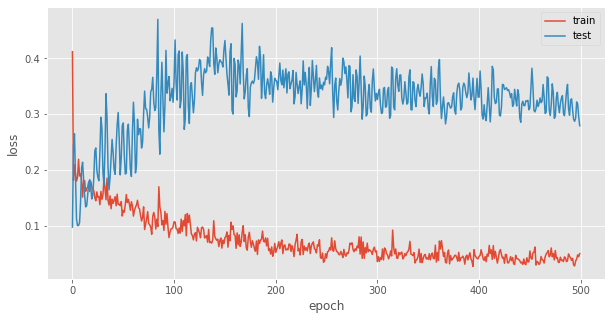

In [23]:
# Plot loss curve for best model
plt.rcParams['figure.figsize'] = (10, 5)

plt.plot(best_model.history['loss'], label='train')
plt.plot(best_model.history['val_loss'], label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [24]:
# Print RMSES and MAES
print('Best RMSE: {:.2f}'.format(best_rmse))
print('Best MAE: {:.2f}'.format(best_mae))
print('Average RMSE: {:.2f}'.format(np.mean(rmses)))
print('Average MAE: {:.2f}'.format(np.mean(maes)))

Best RMSE: 10.63
Best MAE: 8.94
Average RMSE: 12.43
Average MAE: 10.39


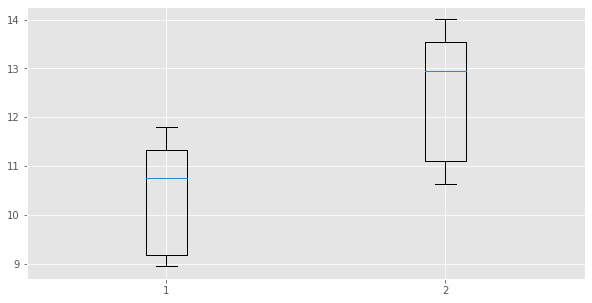

In [25]:
plt.boxplot([maes, rmses])
plt.show()

Text(0.5, 1.0, 'LeSean McCoy Fantasy Points 2012, Predicted vs Actual')

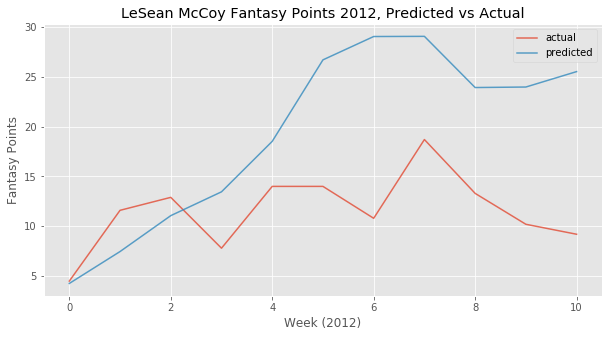

In [26]:
plt.rcParams['figure.figsize'] = (10, 5)
fig, ax = plt.subplots()
plot1 = ax.plot(y_inv, alpha = 0.8, label='actual')
plot1 = ax.plot(best_preds, alpha = 0.8, label='predicted')
ax.legend()
plt.xlabel('Week (2012)')
plt.ylabel('Fantasy Points')
plt.title('LeSean McCoy Fantasy Points 2012, Predicted vs Actual')

#### Online Training

In [ ]:
%%time
# Rebuild network for iterative training - stateful model with one batch
n_loops = 10
rmses, maes = [], []
best_rmse, best_mae = 100, 100
best_model = None
best_preds = []

for i in range(0, n_loops):
    model = Sequential()
    model.add(LSTM(50, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), return_sequences=True, stateful=True))
    model.add(Dropout(0.3))
    model.add(LSTM(20))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    # Fit network
    n_iters = 1000
    for k in range(n_iters):
        t0 = time.time()
        model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=0, shuffle=False)
        print('Epoch {}/{}'.format(k+1, n_iters))
        print('{:.2f}s'.format(time.time()-t0))
        model.reset_states()   
        
                
    # Make predictions for test set
    preds = []
    for j in range(len(y_test)):
        X_test_formatted = X_test[j].reshape(1, X_test[j].shape[0], X_test[j].shape[1])
        preds.append(model.predict(X_test_formatted)[0])
        X_train_upd = np.append(X_train, X_test_formatted, axis=0)
        y_train_upd = np.append(y_train, y_test[j])
        model.fit(X_train_upd, y_train_upd, epochs=10, batch_size=1, verbose=0, shuffle=False)
        model.reset_states()    

    # Invert scaling for preds
    preds_inv = np.concatenate((preds, test[:,1:]), axis=1)
    preds_inv = scaler.inverse_transform(preds_inv)
    preds_inv = preds_inv[:,0]
    
    # Calculate RMSE and MAE
    rmses.append(np.sqrt(mean_squared_error(y_inv, preds_inv)))
    maes.append(mean_absolute_error(y_inv, preds_inv))
    
    if maes[i] < best_mae:
        best_rmse = rmses[i]
        best_mae = maes[i]
        best_model = model
        best_preds = preds_inv
        
    gc.collect()
             

Epoch 1/1000
14.25s
Epoch 2/1000
0.15s
Epoch 3/1000
0.17s
Epoch 4/1000
0.15s
Epoch 5/1000
0.16s
Epoch 6/1000
0.18s
Epoch 7/1000
0.17s
Epoch 8/1000
0.14s
Epoch 9/1000
0.17s
Epoch 10/1000
0.18s
Epoch 11/1000
0.17s
Epoch 12/1000
0.15s
Epoch 13/1000
0.13s
Epoch 14/1000
0.13s
Epoch 15/1000
0.12s
Epoch 16/1000
0.14s
Epoch 17/1000
0.12s
Epoch 18/1000
0.11s
Epoch 19/1000
0.11s
Epoch 20/1000
0.13s
Epoch 21/1000
0.11s
Epoch 22/1000
0.11s
Epoch 23/1000
0.10s
Epoch 24/1000
0.11s
Epoch 25/1000
0.11s
Epoch 26/1000
0.15s
Epoch 27/1000
0.17s
Epoch 28/1000
0.17s
Epoch 29/1000
0.16s
Epoch 30/1000
0.16s
Epoch 31/1000
0.17s
Epoch 32/1000
0.15s
Epoch 33/1000
0.16s
Epoch 34/1000
0.11s
Epoch 35/1000
0.10s
Epoch 36/1000
0.12s
Epoch 37/1000
0.10s
Epoch 38/1000
0.16s
Epoch 39/1000
0.15s
Epoch 40/1000
0.15s
Epoch 41/1000
0.15s
Epoch 42/1000
0.11s
Epoch 43/1000
0.10s
Epoch 44/1000
0.11s
Epoch 45/1000
0.14s
Epoch 46/1000
0.13s
Epoch 47/1000
0.12s
Epoch 48/1000
0.11s
Epoch 49/1000
0.12s
Epoch 50/1000
0.13s
Epoch 51

Epoch 397/1000
0.10s
Epoch 398/1000
0.09s
Epoch 399/1000
0.09s
Epoch 400/1000
0.09s
Epoch 401/1000
0.09s
Epoch 402/1000
0.09s
Epoch 403/1000
0.10s
Epoch 404/1000
0.09s
Epoch 405/1000
0.09s
Epoch 406/1000
0.09s
Epoch 407/1000
0.09s
Epoch 408/1000
0.09s
Epoch 409/1000
0.10s
Epoch 410/1000
0.09s
Epoch 411/1000
0.09s
Epoch 412/1000
0.10s
Epoch 413/1000
0.09s
Epoch 414/1000
0.09s
Epoch 415/1000
0.09s
Epoch 416/1000
0.09s
Epoch 417/1000
0.09s
Epoch 418/1000
0.10s
Epoch 419/1000
0.09s
Epoch 420/1000
0.09s
Epoch 421/1000
0.10s
Epoch 422/1000
0.09s
Epoch 423/1000
0.09s
Epoch 424/1000
0.10s
Epoch 425/1000
0.10s
Epoch 426/1000
0.09s
Epoch 427/1000
0.10s
Epoch 428/1000
0.09s
Epoch 429/1000
0.09s
Epoch 430/1000
0.10s
Epoch 431/1000
0.09s
Epoch 432/1000
0.09s
Epoch 433/1000
0.10s
Epoch 434/1000
0.09s
Epoch 435/1000
0.09s
Epoch 436/1000
0.10s
Epoch 437/1000
0.10s
Epoch 438/1000
0.09s
Epoch 439/1000
0.10s
Epoch 440/1000
0.10s
Epoch 441/1000
0.10s
Epoch 442/1000
0.10s
Epoch 443/1000
0.10s
Epoch 444/100

Epoch 790/1000
0.11s
Epoch 791/1000
0.11s
Epoch 792/1000
0.11s
Epoch 793/1000
0.12s
Epoch 794/1000
0.15s
Epoch 795/1000
0.14s
Epoch 796/1000
0.14s
Epoch 797/1000
0.10s
Epoch 798/1000
0.09s
Epoch 799/1000
0.10s
Epoch 800/1000
0.10s
Epoch 801/1000
0.11s
Epoch 802/1000
0.11s
Epoch 803/1000
0.12s
Epoch 804/1000
0.10s
Epoch 805/1000
0.10s
Epoch 806/1000
0.12s
Epoch 807/1000
0.11s
Epoch 808/1000
0.10s
Epoch 809/1000
0.09s
Epoch 810/1000
0.10s
Epoch 811/1000
0.11s
Epoch 812/1000
0.10s
Epoch 813/1000
0.09s
Epoch 814/1000
0.10s
Epoch 815/1000
0.09s
Epoch 816/1000
0.09s
Epoch 817/1000
0.09s
Epoch 818/1000
0.10s
Epoch 819/1000
0.10s
Epoch 820/1000
0.10s
Epoch 821/1000
0.10s
Epoch 822/1000
0.10s
Epoch 823/1000
0.10s
Epoch 824/1000
0.09s
Epoch 825/1000
0.11s
Epoch 826/1000
0.09s
Epoch 827/1000
0.09s
Epoch 828/1000
0.10s
Epoch 829/1000
0.10s
Epoch 830/1000
0.10s
Epoch 831/1000
0.11s
Epoch 832/1000
0.11s
Epoch 833/1000
0.10s
Epoch 834/1000
0.09s
Epoch 835/1000
0.09s
Epoch 836/1000
0.10s
Epoch 837/100

Epoch 186/1000
0.09s
Epoch 187/1000
0.09s
Epoch 188/1000
0.09s
Epoch 189/1000
0.09s
Epoch 190/1000
0.09s
Epoch 191/1000
0.09s
Epoch 192/1000
0.09s
Epoch 193/1000
0.09s
Epoch 194/1000
0.09s
Epoch 195/1000
0.09s
Epoch 196/1000
0.09s
Epoch 197/1000
0.09s
Epoch 198/1000
0.09s
Epoch 199/1000
0.09s
Epoch 200/1000
0.09s
Epoch 201/1000
0.10s
Epoch 202/1000
0.09s
Epoch 203/1000
0.09s
Epoch 204/1000
0.09s
Epoch 205/1000
0.09s
Epoch 206/1000
0.09s
Epoch 207/1000
0.09s
Epoch 208/1000
0.09s
Epoch 209/1000
0.09s
Epoch 210/1000
0.09s
Epoch 211/1000
0.09s
Epoch 212/1000
0.09s
Epoch 213/1000
0.09s
Epoch 214/1000
0.10s
Epoch 215/1000
0.09s
Epoch 216/1000
0.09s
Epoch 217/1000
0.09s
Epoch 218/1000
0.09s
Epoch 219/1000
0.09s
Epoch 220/1000
0.09s
Epoch 221/1000
0.09s
Epoch 222/1000
0.09s
Epoch 223/1000
0.10s
Epoch 224/1000
0.12s
Epoch 225/1000
0.10s
Epoch 226/1000
0.09s
Epoch 227/1000
0.10s
Epoch 228/1000
0.09s
Epoch 229/1000
0.09s
Epoch 230/1000
0.09s
Epoch 231/1000
0.09s
Epoch 232/1000
0.09s
Epoch 233/100

Epoch 579/1000
0.09s
Epoch 580/1000
0.09s
Epoch 581/1000
0.09s
Epoch 582/1000
0.10s
Epoch 583/1000
0.09s
Epoch 584/1000
0.10s
Epoch 585/1000
0.09s
Epoch 586/1000
0.10s
Epoch 587/1000
0.09s
Epoch 588/1000
0.10s
Epoch 589/1000
0.09s
Epoch 590/1000
0.10s
Epoch 591/1000
0.09s
Epoch 592/1000
0.10s
Epoch 593/1000
0.10s
Epoch 594/1000
0.10s
Epoch 595/1000
0.09s
Epoch 596/1000
0.09s
Epoch 597/1000
0.09s
Epoch 598/1000
0.09s
Epoch 599/1000
0.10s
Epoch 600/1000
0.09s
Epoch 601/1000
0.09s
Epoch 602/1000
0.09s
Epoch 603/1000
0.09s
Epoch 604/1000
0.09s
Epoch 605/1000
0.10s
Epoch 606/1000
0.09s
Epoch 607/1000
0.09s
Epoch 608/1000
0.12s
Epoch 609/1000
0.11s
Epoch 610/1000
0.10s
Epoch 611/1000
0.09s
Epoch 612/1000
0.09s
Epoch 613/1000
0.11s
Epoch 614/1000
0.11s
Epoch 615/1000
0.11s
Epoch 616/1000
0.11s
Epoch 617/1000
0.11s
Epoch 618/1000
0.11s
Epoch 619/1000
0.11s
Epoch 620/1000
0.11s
Epoch 621/1000
0.10s
Epoch 622/1000
0.11s
Epoch 623/1000
0.11s
Epoch 624/1000
0.10s
Epoch 625/1000
0.10s
Epoch 626/100

Epoch 970/1000
0.11s
Epoch 971/1000
0.10s
Epoch 972/1000
0.11s
Epoch 973/1000
0.11s
Epoch 974/1000
0.11s
Epoch 975/1000
0.11s
Epoch 976/1000
0.11s
Epoch 977/1000
0.11s
Epoch 978/1000
0.11s
Epoch 979/1000
0.11s
Epoch 980/1000
0.11s
Epoch 981/1000
0.10s
Epoch 982/1000
0.11s
Epoch 983/1000
0.11s
Epoch 984/1000
0.10s
Epoch 985/1000
0.11s
Epoch 986/1000
0.11s
Epoch 987/1000
0.10s
Epoch 988/1000
0.11s
Epoch 989/1000
0.09s
Epoch 990/1000
0.09s
Epoch 991/1000
0.09s
Epoch 992/1000
0.09s
Epoch 993/1000
0.09s
Epoch 994/1000
0.09s
Epoch 995/1000
0.10s
Epoch 996/1000
0.09s
Epoch 997/1000
0.09s
Epoch 998/1000
0.09s
Epoch 999/1000
0.10s
Epoch 1000/1000
0.09s
Epoch 1/1000
12.75s
Epoch 2/1000
0.10s
Epoch 3/1000
0.10s
Epoch 4/1000
0.10s
Epoch 5/1000
0.09s
Epoch 6/1000
0.09s
Epoch 7/1000
0.09s
Epoch 8/1000
0.09s
Epoch 9/1000
0.12s
Epoch 10/1000
0.15s
Epoch 11/1000
0.12s
Epoch 12/1000
0.09s
Epoch 13/1000
0.09s
Epoch 14/1000
0.10s
Epoch 15/1000
0.09s
Epoch 16/1000
0.09s
Epoch 17/1000
0.10s
Epoch 18/1000
0.

Epoch 367/1000
0.09s
Epoch 368/1000
0.09s
Epoch 369/1000
0.10s
Epoch 370/1000
0.10s
Epoch 371/1000
0.09s
Epoch 372/1000
0.09s
Epoch 373/1000
0.09s
Epoch 374/1000
0.11s
Epoch 375/1000
0.11s
Epoch 376/1000
0.10s
Epoch 377/1000
0.09s
Epoch 378/1000
0.09s
Epoch 379/1000
0.09s
Epoch 380/1000
0.12s
Epoch 381/1000
0.10s
Epoch 382/1000
0.10s
Epoch 383/1000
0.10s
Epoch 384/1000
0.12s
Epoch 385/1000
0.10s
Epoch 386/1000
0.11s
Epoch 387/1000
0.10s
Epoch 388/1000
0.10s
Epoch 389/1000
0.09s
Epoch 390/1000
0.09s
Epoch 391/1000
0.10s
Epoch 392/1000
0.10s
Epoch 393/1000
0.10s
Epoch 394/1000
0.10s
Epoch 395/1000
0.09s
Epoch 396/1000
0.09s
Epoch 397/1000
0.10s
Epoch 398/1000
0.09s
Epoch 399/1000
0.10s
Epoch 400/1000
0.09s
Epoch 401/1000
0.10s
Epoch 402/1000
0.13s
Epoch 403/1000
0.10s
Epoch 404/1000
0.12s
Epoch 405/1000
0.10s
Epoch 406/1000
0.10s
Epoch 407/1000
0.10s
Epoch 408/1000
0.10s
Epoch 409/1000
0.09s
Epoch 410/1000
0.09s
Epoch 411/1000
0.09s
Epoch 412/1000
0.09s
Epoch 413/1000
0.09s
Epoch 414/100

Epoch 759/1000
0.19s
Epoch 760/1000
0.13s
Epoch 761/1000
0.14s
Epoch 762/1000
0.13s
Epoch 763/1000
0.12s
Epoch 764/1000
0.10s
Epoch 765/1000
0.10s
Epoch 766/1000
0.09s
Epoch 767/1000
0.10s
Epoch 768/1000
0.10s
Epoch 769/1000
0.10s
Epoch 770/1000
0.09s
Epoch 771/1000
0.09s
Epoch 772/1000
0.09s
Epoch 773/1000
0.11s
Epoch 774/1000
0.09s
Epoch 775/1000
0.09s
Epoch 776/1000
0.09s
Epoch 777/1000
0.09s
Epoch 778/1000
0.09s
Epoch 779/1000
0.09s
Epoch 780/1000
0.12s
Epoch 781/1000
0.09s
Epoch 782/1000
0.12s
Epoch 783/1000
0.11s
Epoch 784/1000
0.09s
Epoch 785/1000
0.09s
Epoch 786/1000
0.09s
Epoch 787/1000
0.09s
Epoch 788/1000
0.09s
Epoch 789/1000
0.09s
Epoch 790/1000
0.10s
Epoch 791/1000
0.09s
Epoch 792/1000
0.10s
Epoch 793/1000
0.09s
Epoch 794/1000
0.11s
Epoch 795/1000
0.12s
Epoch 796/1000
0.13s
Epoch 797/1000
0.10s
Epoch 798/1000
0.10s
Epoch 799/1000
0.13s
Epoch 800/1000
0.11s
Epoch 801/1000
0.10s
Epoch 802/1000
0.12s
Epoch 803/1000
0.11s
Epoch 804/1000
0.13s
Epoch 805/1000
0.11s
Epoch 806/100

Epoch 155/1000
0.10s
Epoch 156/1000
0.10s
Epoch 157/1000
0.10s
Epoch 158/1000
0.14s
Epoch 159/1000
0.13s
Epoch 160/1000
0.09s
Epoch 161/1000
0.10s
Epoch 162/1000
0.11s
Epoch 163/1000
0.12s
Epoch 164/1000
0.11s
Epoch 165/1000
0.15s
Epoch 166/1000
0.11s
Epoch 167/1000
0.12s
Epoch 168/1000
0.10s
Epoch 169/1000
0.10s
Epoch 170/1000
0.09s
Epoch 171/1000
0.09s
Epoch 172/1000
0.10s
Epoch 173/1000
0.09s
Epoch 174/1000
0.10s
Epoch 175/1000
0.10s
Epoch 176/1000
0.10s
Epoch 177/1000
0.10s
Epoch 178/1000
0.09s
Epoch 179/1000
0.09s
Epoch 180/1000
0.10s
Epoch 181/1000
0.09s
Epoch 182/1000
0.09s
Epoch 183/1000
0.10s
Epoch 184/1000
0.09s
Epoch 185/1000
0.10s
Epoch 186/1000
0.09s
Epoch 187/1000
0.10s
Epoch 188/1000
0.09s
Epoch 189/1000
0.09s
Epoch 190/1000
0.10s
Epoch 191/1000
0.09s
Epoch 192/1000
0.09s
Epoch 193/1000
0.09s
Epoch 194/1000
0.09s
Epoch 195/1000
0.09s
Epoch 196/1000
0.09s
Epoch 197/1000
0.09s
Epoch 198/1000
0.09s
Epoch 199/1000
0.09s
Epoch 200/1000
0.11s
Epoch 201/1000
0.11s
Epoch 202/100

Epoch 547/1000
0.09s
Epoch 548/1000
0.10s
Epoch 549/1000
0.10s
Epoch 550/1000
0.10s
Epoch 551/1000
0.13s
Epoch 552/1000
0.12s
Epoch 553/1000
0.12s
Epoch 554/1000
0.14s
Epoch 555/1000
0.11s
Epoch 556/1000
0.10s
Epoch 557/1000
0.14s
Epoch 558/1000
0.14s
Epoch 559/1000
0.13s
Epoch 560/1000
0.12s
Epoch 561/1000
0.10s
Epoch 562/1000
0.10s
Epoch 563/1000
0.10s
Epoch 564/1000
0.11s
Epoch 565/1000
0.12s
Epoch 566/1000
0.13s
Epoch 567/1000
0.12s
Epoch 568/1000
0.14s
Epoch 569/1000
0.16s
Epoch 570/1000
0.15s
Epoch 571/1000
0.16s
Epoch 572/1000
0.17s
Epoch 573/1000
0.16s
Epoch 574/1000
0.15s
Epoch 575/1000
0.11s
Epoch 576/1000
0.10s
Epoch 577/1000
0.10s
Epoch 578/1000
0.10s
Epoch 579/1000
0.13s
Epoch 580/1000
0.12s
Epoch 581/1000
0.13s
Epoch 582/1000
0.16s
Epoch 583/1000
0.17s
Epoch 584/1000
0.15s
Epoch 585/1000
0.11s
Epoch 586/1000
0.11s
Epoch 587/1000
0.12s
Epoch 588/1000
0.12s
Epoch 589/1000
0.15s
Epoch 590/1000
0.14s
Epoch 591/1000
0.14s
Epoch 592/1000
0.15s
Epoch 593/1000
0.15s
Epoch 594/100

Epoch 939/1000
0.13s
Epoch 940/1000
0.12s
Epoch 941/1000
0.12s
Epoch 942/1000
0.10s
Epoch 943/1000
0.12s
Epoch 944/1000
0.14s
Epoch 945/1000
0.11s
Epoch 946/1000
0.12s
Epoch 947/1000
0.12s
Epoch 948/1000
0.11s
Epoch 949/1000
0.12s
Epoch 950/1000
0.11s
Epoch 951/1000
0.10s
Epoch 952/1000
0.10s
Epoch 953/1000
0.11s
Epoch 954/1000
0.11s
Epoch 955/1000
0.11s
Epoch 956/1000
0.10s
Epoch 957/1000
0.10s
Epoch 958/1000
0.10s
Epoch 959/1000
0.12s
Epoch 960/1000
0.11s
Epoch 961/1000
0.10s
Epoch 962/1000
0.11s
Epoch 963/1000
0.10s
Epoch 964/1000
0.12s
Epoch 965/1000
0.12s
Epoch 966/1000
0.12s
Epoch 967/1000
0.10s
Epoch 968/1000
0.11s
Epoch 969/1000
0.12s
Epoch 970/1000
0.13s
Epoch 971/1000
0.11s
Epoch 972/1000
0.12s
Epoch 973/1000
0.10s
Epoch 974/1000
0.10s
Epoch 975/1000
0.11s
Epoch 976/1000
0.10s
Epoch 977/1000
0.12s
Epoch 978/1000
0.15s
Epoch 979/1000
0.15s
Epoch 980/1000
0.14s
Epoch 981/1000
0.12s
Epoch 982/1000
0.11s
Epoch 983/1000
0.13s
Epoch 984/1000
0.11s
Epoch 985/1000
0.12s
Epoch 986/100

Epoch 335/1000
0.12s
Epoch 336/1000
0.11s
Epoch 337/1000
0.10s
Epoch 338/1000
0.12s
Epoch 339/1000
0.17s
Epoch 340/1000
0.15s
Epoch 341/1000
0.10s
Epoch 342/1000
0.09s
Epoch 343/1000
0.09s
Epoch 344/1000
0.09s
Epoch 345/1000
0.09s
Epoch 346/1000
0.09s
Epoch 347/1000
0.09s
Epoch 348/1000
0.09s
Epoch 349/1000
0.09s
Epoch 350/1000
0.09s
Epoch 351/1000
0.09s
Epoch 352/1000
0.09s
Epoch 353/1000
0.09s
Epoch 354/1000
0.10s
Epoch 355/1000
0.09s
Epoch 356/1000
0.11s
Epoch 357/1000
0.11s
Epoch 358/1000
0.10s
Epoch 359/1000
0.10s
Epoch 360/1000
0.11s
Epoch 361/1000
0.11s
Epoch 362/1000
0.09s
Epoch 363/1000
0.10s
Epoch 364/1000
0.14s
Epoch 365/1000
0.12s
Epoch 366/1000
0.13s
Epoch 367/1000
0.12s
Epoch 368/1000
0.11s
Epoch 369/1000
0.11s
Epoch 370/1000
0.10s
Epoch 371/1000
0.09s
Epoch 372/1000
0.10s
Epoch 373/1000
0.11s
Epoch 374/1000
0.10s
Epoch 375/1000
0.12s
Epoch 376/1000
0.11s
Epoch 377/1000
0.10s
Epoch 378/1000
0.10s
Epoch 379/1000
0.10s
Epoch 380/1000
0.09s
Epoch 381/1000
0.09s
Epoch 382/100

Epoch 726/1000
0.10s
Epoch 727/1000
0.09s
Epoch 728/1000
0.10s
Epoch 729/1000
0.10s
Epoch 730/1000
0.09s
Epoch 731/1000
0.09s
Epoch 732/1000
0.10s
Epoch 733/1000
0.09s
Epoch 734/1000
0.09s
Epoch 735/1000
0.10s
Epoch 736/1000
0.10s
Epoch 737/1000
0.10s
Epoch 738/1000
0.11s
Epoch 739/1000
0.10s
Epoch 740/1000
0.10s
Epoch 741/1000
0.11s
Epoch 742/1000
0.11s
Epoch 743/1000
0.11s
Epoch 744/1000
0.11s
Epoch 745/1000
0.11s
Epoch 746/1000
0.10s
Epoch 747/1000
0.10s
Epoch 748/1000
0.10s
Epoch 749/1000
0.11s
Epoch 750/1000
0.09s
Epoch 751/1000
0.11s
Epoch 752/1000
0.10s
Epoch 753/1000
0.11s
Epoch 754/1000
0.10s
Epoch 755/1000
0.11s
Epoch 756/1000
0.11s
Epoch 757/1000
0.11s
Epoch 758/1000
0.09s
Epoch 759/1000
0.11s
Epoch 760/1000
0.10s
Epoch 761/1000
0.10s
Epoch 762/1000
0.11s
Epoch 763/1000
0.10s
Epoch 764/1000
0.09s
Epoch 765/1000
0.11s
Epoch 766/1000
0.09s
Epoch 767/1000
0.09s
Epoch 768/1000
0.11s
Epoch 769/1000
0.10s
Epoch 770/1000
0.10s
Epoch 771/1000
0.11s
Epoch 772/1000
0.10s
Epoch 773/100

Epoch 124/1000
0.11s
Epoch 125/1000
0.11s
Epoch 126/1000
0.10s
Epoch 127/1000
0.10s
Epoch 128/1000
0.10s
Epoch 129/1000
0.10s
Epoch 130/1000
0.09s
Epoch 131/1000
0.09s
Epoch 132/1000
0.10s
Epoch 133/1000
0.09s
Epoch 134/1000
0.10s
Epoch 135/1000
0.10s
Epoch 136/1000
0.09s
Epoch 137/1000
0.10s
Epoch 138/1000
0.10s
Epoch 139/1000
0.09s
Epoch 140/1000
0.10s
Epoch 141/1000
0.10s
Epoch 142/1000
0.10s
Epoch 143/1000
0.09s
Epoch 144/1000
0.10s
Epoch 145/1000
0.09s
Epoch 146/1000
0.09s
Epoch 147/1000
0.10s
Epoch 148/1000
0.09s
Epoch 149/1000
0.09s
Epoch 150/1000
0.10s
Epoch 151/1000
0.09s
Epoch 152/1000
0.09s
Epoch 153/1000
0.10s
Epoch 154/1000
0.09s
Epoch 155/1000
0.09s
Epoch 156/1000
0.10s
Epoch 157/1000
0.10s
Epoch 158/1000
0.10s
Epoch 159/1000
0.10s
Epoch 160/1000
0.09s
Epoch 161/1000
0.09s
Epoch 162/1000
0.10s
Epoch 163/1000
0.09s
Epoch 164/1000
0.10s
Epoch 165/1000
0.10s
Epoch 166/1000
0.09s
Epoch 167/1000
0.09s
Epoch 168/1000
0.10s
Epoch 169/1000
0.09s
Epoch 170/1000
0.09s
Epoch 171/100

Epoch 517/1000
0.09s
Epoch 518/1000
0.09s
Epoch 519/1000
0.09s
Epoch 520/1000
0.09s
Epoch 521/1000
0.09s
Epoch 522/1000
0.09s
Epoch 523/1000
0.12s
Epoch 524/1000
0.14s
Epoch 525/1000
0.10s
Epoch 526/1000
0.09s
Epoch 527/1000
0.09s
Epoch 528/1000
0.11s
Epoch 529/1000
0.10s
Epoch 530/1000
0.10s
Epoch 531/1000
0.11s
Epoch 532/1000
0.10s
Epoch 533/1000
0.09s
Epoch 534/1000
0.10s
Epoch 535/1000
0.11s
Epoch 536/1000
0.09s
Epoch 537/1000
0.10s
Epoch 538/1000
0.09s
Epoch 539/1000
0.09s
Epoch 540/1000
0.09s
Epoch 541/1000
0.09s
Epoch 542/1000
0.09s
Epoch 543/1000
0.09s
Epoch 544/1000
0.10s
Epoch 545/1000
0.10s
Epoch 546/1000
0.10s
Epoch 547/1000
0.09s
Epoch 548/1000
0.09s
Epoch 549/1000
0.09s
Epoch 550/1000
0.09s
Epoch 551/1000
0.09s
Epoch 552/1000
0.09s
Epoch 553/1000
0.09s
Epoch 554/1000
0.09s
Epoch 555/1000
0.09s
Epoch 556/1000
0.09s
Epoch 557/1000
0.09s
Epoch 558/1000
0.09s
Epoch 559/1000
0.09s
Epoch 560/1000
0.09s
Epoch 561/1000
0.09s
Epoch 562/1000
0.09s
Epoch 563/1000
0.09s
Epoch 564/100

Epoch 908/1000
0.11s
Epoch 909/1000
0.10s
Epoch 910/1000
0.10s
Epoch 911/1000
0.10s
Epoch 912/1000
0.10s
Epoch 913/1000
0.10s
Epoch 914/1000
0.10s
Epoch 915/1000
0.10s
Epoch 916/1000
0.10s
Epoch 917/1000
0.09s
Epoch 918/1000
0.09s
Epoch 919/1000
0.10s
Epoch 920/1000
0.10s
Epoch 921/1000
0.11s
Epoch 922/1000
0.10s
Epoch 923/1000
0.10s
Epoch 924/1000
0.10s
Epoch 925/1000
0.09s
Epoch 926/1000
0.09s
Epoch 927/1000
0.09s
Epoch 928/1000
0.10s
Epoch 929/1000
0.11s
Epoch 930/1000
0.09s
Epoch 931/1000
0.12s
Epoch 932/1000
0.10s
Epoch 933/1000
0.10s
Epoch 934/1000
0.11s
Epoch 935/1000
0.11s
Epoch 936/1000
0.10s
Epoch 937/1000
0.10s
Epoch 938/1000
0.11s
Epoch 939/1000
0.12s
Epoch 940/1000
0.12s
Epoch 941/1000
0.12s
Epoch 942/1000
0.12s
Epoch 943/1000
0.13s
Epoch 944/1000
0.12s
Epoch 945/1000
0.11s
Epoch 946/1000
0.11s
Epoch 947/1000
0.11s
Epoch 948/1000
0.10s
Epoch 949/1000
0.09s
Epoch 950/1000
0.09s
Epoch 951/1000
0.09s
Epoch 952/1000
0.10s
Epoch 953/1000
0.11s
Epoch 954/1000
0.11s
Epoch 955/100

Epoch 305/1000
0.10s
Epoch 306/1000
0.14s
Epoch 307/1000
0.16s
Epoch 308/1000
0.16s
Epoch 309/1000
0.15s
Epoch 310/1000
0.10s
Epoch 311/1000
0.16s
Epoch 312/1000
0.16s
Epoch 313/1000
0.16s
Epoch 314/1000
0.15s
Epoch 315/1000
0.16s
Epoch 316/1000
0.13s
Epoch 317/1000
0.12s
Epoch 318/1000
0.16s
Epoch 319/1000
0.17s
Epoch 320/1000
0.16s
Epoch 321/1000
0.14s
Epoch 322/1000
0.10s
Epoch 323/1000
0.10s
Epoch 324/1000
0.09s
Epoch 325/1000
0.10s
Epoch 326/1000
0.10s
Epoch 327/1000
0.10s
Epoch 328/1000
0.11s
Epoch 329/1000
0.12s
Epoch 330/1000
0.12s
Epoch 331/1000
0.12s
Epoch 332/1000
0.12s
Epoch 333/1000
0.13s
Epoch 334/1000
0.12s
Epoch 335/1000
0.11s
Epoch 336/1000
0.09s
Epoch 337/1000
0.09s
Epoch 338/1000
0.09s
Epoch 339/1000
0.09s
Epoch 340/1000
0.10s
Epoch 341/1000
0.10s
Epoch 342/1000
0.10s
Epoch 343/1000
0.10s
Epoch 344/1000
0.09s
Epoch 345/1000
0.09s
Epoch 346/1000
0.09s
Epoch 347/1000
0.11s
Epoch 348/1000
0.13s
Epoch 349/1000
0.12s
Epoch 350/1000
0.09s
Epoch 351/1000
0.09s
Epoch 352/100

Epoch 697/1000
0.11s
Epoch 698/1000
0.09s
Epoch 699/1000
0.09s
Epoch 700/1000
0.12s
Epoch 701/1000
0.12s
Epoch 702/1000
0.10s
Epoch 703/1000
0.09s
Epoch 704/1000
0.10s
Epoch 705/1000
0.09s
Epoch 706/1000
0.09s
Epoch 707/1000
0.09s
Epoch 708/1000
0.10s
Epoch 709/1000
0.10s
Epoch 710/1000
0.09s
Epoch 711/1000
0.10s
Epoch 712/1000
0.09s
Epoch 713/1000
0.09s
Epoch 714/1000
0.09s
Epoch 715/1000
0.09s
Epoch 716/1000
0.09s
Epoch 717/1000
0.09s
Epoch 718/1000
0.09s
Epoch 719/1000
0.09s
Epoch 720/1000
0.09s
Epoch 721/1000
0.09s
Epoch 722/1000
0.09s
Epoch 723/1000
0.09s
Epoch 724/1000
0.09s
Epoch 725/1000
0.09s
Epoch 726/1000
0.09s
Epoch 727/1000
0.09s
Epoch 728/1000
0.09s
Epoch 729/1000
0.09s
Epoch 730/1000
0.09s
Epoch 731/1000
0.09s
Epoch 732/1000
0.09s
Epoch 733/1000
0.09s
Epoch 734/1000
0.09s
Epoch 735/1000
0.09s
Epoch 736/1000
0.09s
Epoch 737/1000
0.09s
Epoch 738/1000
0.09s
Epoch 739/1000
0.09s
Epoch 740/1000
0.09s
Epoch 741/1000
0.09s
Epoch 742/1000
0.09s
Epoch 743/1000
0.09s
Epoch 744/100

Epoch 93/1000
0.11s
Epoch 94/1000
0.13s
Epoch 95/1000
0.13s
Epoch 96/1000
0.11s
Epoch 97/1000
0.12s
Epoch 98/1000
0.12s
Epoch 99/1000
0.15s
Epoch 100/1000
0.11s
Epoch 101/1000
0.10s
Epoch 102/1000
0.11s
Epoch 103/1000
0.10s
Epoch 104/1000
0.14s
Epoch 105/1000
0.11s
Epoch 106/1000
0.10s
Epoch 107/1000
0.11s
Epoch 108/1000
0.11s
Epoch 109/1000
0.11s
Epoch 110/1000
0.10s


In [ ]:
# Print RMSES and MAES
print('Best RMSE: {:.2f}'.format(best_rmse))
print('Best MAE: {:.2f}'.format(best_mae))
print('Average RMSE: {:.2f}'.format(np.mean(rmses)))
print('Average MAE: {:.2f}'.format(np.mean(maes)))

In [ ]:
plt.boxplot([maes, rmses])
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = (10, 5)
fig, ax = plt.subplots()
plot1 = ax.plot(y_inv, alpha = 0.8, label='actual')
plot1 = ax.plot(best_preds, alpha = 0.8, label='predicted')
ax.legend()
plt.xlabel('Week (2012)')
plt.ylabel('Fantasy Points')
plt.title('LeSean McCoy Fantasy Points 2012, Predicted vs Actual')